In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import eden
import matplotlib.pyplot as plt
from eden.util import configure_logging
import logging

/home/ikea/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/ikea/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ikea/miniconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarni

In [ ]:
from itertools import tee, chain, islice
import numpy as np
import random
from time import time
import datetime
from graphlearn.graphlearn import Sampler as GraphLearnSampler
from eden.util import fit,estimate
from eden.path import Vectorizer
import random
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
import random
'''
GET RNA DATA
'''
from eden.converter.fasta import fasta_to_sequence
import itertools

def rfam_uri(family_id):
    return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)
def rfam_uri(family_id):
    return '%s.fa'%(family_id)
 

from eden.converter.fasta import fasta_to_sequence
def get_sequences_with_names(filename='RF00005.fa'):
    sequences = fasta_to_sequence("../toolsdata/"+filename)
    return sequences


def get_graphs(fname,size):
    graphs=[g for g in get_sequences_with_names(fname)]
    random.shuffle(graphs)
    return graphs[:size]

# formerly:
#get_graphs(dataset_fname, size=100)

In [ ]:
import random
import graphlearn.abstract_graphs.RNA as rna
from  graphlearn.feasibility import FeasibilityChecker as Checker
from graphlearn.estimator import Wrapper as estimatorwrapper
import graphlearn.utils.draw as draw
from graphlearn.graphlearn import Sampler as GLS
import itertools



def fit_sample(graphs, random_state=random.random()):
    '''
    graphs -> more graphs
    '''
    graphs = list(graphs)
    estimator=estimatorwrapper( nu=.5, cv=2, n_jobs=-1)
    sampler=rna.AbstractSampler(radius_list=[0,1],
                                thickness_list=[2], 
                                min_cip_count=1, 
                                min_interface_count=2, 
                                preprocessor=rna.PreProcessor(base_thickness_list=[1],ignore_inserts=True), 
                                postprocessor=rna.PostProcessor(),
                                estimator=estimator
                                #feasibility_checker=feasibility
                               )
    sampler.fit(graphs,grammar_n_jobs=4,grammar_batch_size=1)
    
    
    logger.info('graph grammar stats:')
    dataset_size, interface_counts, core_counts, cip_counts = sampler.grammar().size()
    logger.info('#instances:%d   #interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (dataset_size, interface_counts, core_counts, cip_counts))
    
    
    graphs = [ b for a ,b in graphs  ]
    
    graphs = sampler.sample(graphs,
                            n_samples=3,
                            batch_size=1,
                            n_steps=50,
                            n_jobs=4,
                            quick_skip_orig_cip=True,
                            probabilistic_core_choice=True,
                            burnin=10,
                            improving_threshold=0.9,
                            improving_linear_start=0.3,
                            max_size_diff=20,
                            accept_min_similarity=0.65,
                            select_cip_max_tries=30,
                            keep_duplicates=False,
                            include_seed=False,
                            backtrack=10,
                            monitor=False)
    result=[]
    for graphlist in graphs:
        result+=graphlist
    # note that this is a list [('',sequ),..]
    return result

In [ ]:
def fit_and_evaluate(pos_original, neg_original,
                     pos_sampled, neg_sampled,
                     pos_test, neg_test,
                     random_state=42):
    '''
    pos + neg orig+sampled testsets -> orig_roc , sampled_roc, augmented_roc
    '''
    
    # create graph sets...orig augmented and sampled
    pos_orig,pos_orig_ = tee(pos_original)
    neg_orig,neg_orig_ = tee(neg_original)
    
    pos_sampled, pos_sampled_ = tee(pos_sampled)
    neg_sampled, neg_sampled_ = tee(neg_sampled)
    
    pos_augmented = chain(pos_orig_,pos_sampled_)
    neg_augmented = chain(neg_orig_,neg_sampled_)

    predictive_performances = []
    for desc,pos_train,neg_train in [('original',pos_orig, neg_orig),
                                     ('sample',pos_sampled,neg_sampled),
                                     ('original+sample',pos_augmented, neg_augmented)]:
        pos_train,pos_train_ = tee(pos_train)
        neg_train,neg_train_ = tee(neg_train)
        pos_size=sum(1 for x in pos_train_)
        neg_size=sum(1 for x in neg_train_)

        logger.info( "-"*80)
        logger.info('working on %s'%(desc))
        logger.info('training set sizes: #pos: %d #neg: %d'%(pos_size, neg_size))

        if pos_size == 0 or neg_size == 0:
            logger.info('WARNING: empty dataset')
            predictive_performances.append(0)            
        else:
            start=time()
            pos_test,pos_test_ = tee(pos_test)
            neg_test,neg_test_ = tee(neg_test)
            
            local_estimator = fit(pos_train, neg_train, Vectorizer(4), n_jobs=-1, n_iter_search=1)
            apr, roc = estimate(pos_test_, neg_test_, local_estimator, Vectorizer(4))
            predictive_performances.append(roc)
            logger.info( 'elapsed: %.1f sec'%(time()-start))
    return predictive_performances

In [ ]:
def evaluate(pos_fname, neg_fname, size=None, percentages=None, n_repetitions=None, train_test_split=None):
    # initializing 
    graphs_pos = get_graphs(pos_fname, size=size)
    graphs_neg = get_graphs(neg_fname, size=size)

    # train/test split
    from eden.util import random_bipartition_iter
    pos_train_global,pos_test_global = random_bipartition_iter(graphs_pos,train_test_split,random_state=random.random()*1000)
    neg_train_global,neg_test_global = random_bipartition_iter(graphs_neg,train_test_split,random_state=random.random()*1000)


    original_repetitions = []
    original_sample_repetitions = []
    sample_repetitions = []

    for percentage in percentages:
        originals = []
        originals_samples = []
        samples = []
        for repetition in range(n_repetitions):
            random_state = int(313379*percentage+repetition) 
            random.seed(random_state)
            pos_train_global,pos_train_global_ = tee(pos_train_global)
            neg_train_global,neg_train_global_ = tee(neg_train_global)
            pos_test_global,pos_test_global_ = tee(pos_test_global)
            neg_test_global,neg_test_global_ = tee(neg_test_global)

            # use shuffled list to create test and sample set
            pos,pos_reminder = random_bipartition_iter(pos_train_global_,percentage)
            pos,pos_ = tee(pos)
            neg,neg_reminder = random_bipartition_iter(neg_train_global_,percentage)
            neg,neg_ = tee(neg)

            #sample independently from the 2 classes
            logger.info('Positive')
            sampled_pos = fit_sample(pos_, random_state=random_state)
            logger.info('Negative')
            sampled_neg = fit_sample(neg_, random_state=random_state)

            #evaluate the predictive performance on held out test set
            start=time()
            logger.info( "="*80)
            logger.info( 'repetition: %d/%d'%(repetition+1, n_repetitions))
            logger.info( "training percentage:"+str(percentage))
            perf_orig,\
            perf_samp,\
            perf_orig_samp = fit_and_evaluate(pos,neg,
                                              sampled_pos,sampled_neg,
                                              pos_test_global_,neg_test_global_)
            logger.info( 'Time elapsed for full repetition: %.1f sec'%((time()-start)))
            originals.append(perf_orig)
            originals_samples.append(perf_orig_samp)
            samples.append(perf_samp)

        original_repetitions.append(originals)
        original_sample_repetitions.append(originals_samples)
        sample_repetitions.append(samples)
    
    return original_repetitions, original_sample_repetitions, sample_repetitions

In [ ]:
def plot(dataset, percentages, original_sample_repetitions, original_repetitions, sample_repetitions):
    gc={'color':'g'}
    rc={'color':'r'}
    bc={'color':'b'}
    FONTSIZE=20
    ws = 1
    os = np.mean(original_sample_repetitions, axis=1)
    o = np.mean(original_repetitions, axis=1)
    s = np.mean(sample_repetitions, axis=1)
    plt.figure(figsize=(18,8))
    ax = plt.subplot() 
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(20)
    
    
    plt.grid()
    plt.boxplot(original_sample_repetitions, positions=percentages, widths=ws, capprops=gc, medianprops=gc, boxprops=gc, whiskerprops=gc, flierprops=gc)
    plt.plot(percentages,os, color='g', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='g', markerfacecolor='w', label='original+sample')

    plt.boxplot(original_repetitions, positions=percentages, widths=ws, capprops=rc, medianprops=rc, boxprops=rc, whiskerprops=rc, flierprops=rc)
    plt.plot(percentages,o, color='r', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='r', markerfacecolor='w', label='original')

    plt.boxplot(sample_repetitions, positions=percentages, widths=ws, capprops=bc, medianprops=bc, boxprops=bc, whiskerprops=bc, flierprops=bc)
    plt.plot(percentages,s, color='b', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='b', markerfacecolor='w', label='sample')

    plt.xlim(percentages[0]-.05,percentages[-1]+.05)
    plt.xlim(2,15)
    #plt.ylim(0.99,1.005)
    plt.ylim(0.0,1.005)
    plt.title(dataset+'\n',fontsize=20)
    plt.legend(loc='lower right',fontsize=18)
    plt.ylabel('ROC AUC',fontsize=18)
    plt.xlabel('Training set size per family',fontsize=18)
    plt.savefig('%s_plot_predictive_performance_of_samples.pdf' % dataset)

#load("DATAS")
#plot("RF00162 vs RF00005 learning curve", percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)

In [ ]:
'''
def save_results(result_fname,percentages, original_repetitions,original_sample_repetitions,sample_repetitions):
    with open(result_fname,'w') as f:
        f.write('dataset sizes list:\n')
        for perc in percentages:
            f.write('%s '% perc)
        f.write('\n')
        f.write('AUC scores:\n')
        for repetitions in original_repetitions,original_sample_repetitions,sample_repetitions:
            f.write('%s\n' % len(repetitions))
            for repetition in repetitions:
                for auc in repetition:
                    f.write('%s ' % auc)
                f.write('\n')
    
def load_results(result_fname):
    with open(result_fname) as f:
        comment = next(f)
        line = next(f)
        percentages = [float(x) for x in line.split()]
        comment = next(f)

        original_repetitions = []
        size = int(next(f))
        for i in range(size):
            line = next(f)
            repetition = [float(x) for x in line.split()]
            original_repetitions.append(repetition)

        original_sample_repetitions = []
        size = int(next(f))
        for i in range(size):
            line = next(f)
            repetition = [float(x) for x in line.split()]
            original_sample_repetitions.append(repetition)


        sample_repetitions = []
        size = int(next(f))
        for i in range(size):
            line = next(f)
            repetition = [float(x) for x in line.split()]
            sample_repetitions.append(repetition)
            
    return percentages, original_repetitions,original_sample_repetitions,sample_repetitions
'''

#Experimental pipeline

In [ ]:
#plot("RF00162 vs RF01725", percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)

#print '%s_predictive_performance_of_samples.data'%dataset
#!cat "RF00162 vs RF00005 training curve_predictive_performance_of_samples.data"

In [ ]:
#percentages_l, original_repetitions_l,original_sample_repetitions_l,sample_repetitions_l = load_results('%s_predictive_performance_of_samples.data'%dataset)
#plot(dataset, percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)

In [ ]:
'''
%%time
#special case: bursi

dataset='RF00162 vs RF00005 training curve'
#logging
logger = logging.getLogger()
if True:
    logger_fname = '%s_predictive_performance_of_samples.log'%dataset
else:
    logger_fname = None
configure_logging(logger,verbosity=1, filename=logger_fname)

#main 
start=time()
print( 'Working with dataset: %s' % dataset )

logger.info( 'Working with dataset: %s' % dataset )
pos_dataset_fname = 'RF00005.fa'
neg_dataset_fname = 'mixed.fa'

pos_dataset_fname = 'RF00162.fa'
neg_dataset_fname = 'RF01725.fa'

percentages=[.08,.2,.4,.6,.8,.95]
percentages=[.07,0.1,0.15,0.2]
percentages=[.07,.1]


# set size to 900 in production
original_repetitions,\
original_sample_repetitions,\
sample_repetitions = evaluate(pos_dataset_fname,
                              neg_dataset_fname,
                              size=100,
                              percentages=percentages,
                              n_repetitions=6, # ORIG = 10
                              train_test_split=0.7)
#save and display results
result_fname='%s_predictive_performance_of_samples.data'%dataset
save_results(result_fname,percentages, original_repetitions,original_sample_repetitions,sample_repetitions) 


percentages_l, original_repetitions_l,original_sample_repetitions_l,sample_repetitions_l = load_results('%s_predictive_performance_of_samples.data'%dataset)
plot(dataset, percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)

print('Time elapsed: %s'%(datetime.timedelta(seconds=(time() - start))))
'''

In [ ]:
'''time
for dataset in dataset_names:
    #logging
    logger = logging.getLogger()
    if True:
        logger_fname = '%s_predictive_performance_of_samples.log'%dataset
    else:
        logger_fname = None
    configure_logging(logger,verbosity=1, filename=logger_fname)
    
    #main 
    start=time()
    print( 'Working with dataset: %s' % dataset )

    logger.info( 'Working with dataset: %s' % dataset )
    pos_dataset_fname = "RF00005.fa"
    neg_dataset_fname = 'mixed.fa

    percentages=[.05,.2,.4,.6,.8,.95]
    percentages=[.05,.2]

    original_repetitions,\
    original_sample_repetitions,\
    sample_repetitions = evaluate(pos_dataset_fname,
                                  neg_dataset_fname,
                                  size=400,
                                  percentages=percentages,
                                  n_repetitions=3,
                                  train_test_split=0.7)
    #save and display results
    result_fname='%s_predictive_performance_of_samples.data'%dataset
    save_results(result_fname,percentages, original_repetitions,original_sample_repetitions,sample_repetitions)    
    percentages_l, original_repetitions_l,original_sample_repetitions_l,sample_repetitions_l = load_results(result_fname)
    plot(dataset, percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)
    
    print('Time elapsed: %s'%(datetime.timedelta(seconds=(time() - start))))
'''

In [ ]:
#display
'''
for dataset in dataset_names:
    result_fname='%s_predictive_performance_of_samples.data'%dataset
    percentages_l, original_repetitions_l,original_sample_repetitions_l,sample_repetitions_l = load_results(result_fname)
    plot(dataset, percentages_l, original_sample_repetitions_l, original_repetitions_l, sample_repetitions_l)
''' 

.

In [ ]:
from eden.converter.fasta import fasta_to_sequence
import matplotlib.pyplot as plt
# we always want a test and a train set to omou
def get_seq_tups(fname,size,sizeb):
    kram = fasta_to_sequence("../toolsdata/"+fname)
    graphs=[g for g in kram]
    random.shuffle(graphs)
    return graphs[:size],graphs[size:size+sizeb]

def plot(dataset, percentages, original_sample_repetitions, original_repetitions, sample_repetitions): # note that the var names are not real anymore.
    gc={'color':'g'}
    rc={'color':'r'}
    bc={'color':'b'}
    FONTSIZE=20
    ws = .3
    os = np.mean(original_sample_repetitions, axis=1)
    o = np.mean(original_repetitions, axis=1)
    s = np.mean(sample_repetitions, axis=1)
    plt.figure(figsize=(18,8))
    ax = plt.subplot() 
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(20)
    
    plt.grid()
    plt.boxplot(original_sample_repetitions, positions=percentages, widths=ws, capprops=gc, medianprops=gc, boxprops=gc, whiskerprops=gc, flierprops=gc)
    plt.plot(percentages,os, color='g', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='g', markerfacecolor='w', label='original')

    plt.boxplot(original_repetitions, positions=percentages, widths=ws, capprops=rc, medianprops=rc, boxprops=rc, whiskerprops=rc, flierprops=rc)
    plt.plot(percentages,o, color='r', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='r', markerfacecolor='w', label='sample')

    plt.boxplot(sample_repetitions, positions=percentages, widths=ws, capprops=bc, medianprops=bc, boxprops=bc, whiskerprops=bc, flierprops=bc)
    plt.plot(percentages,s, color='b', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='b', markerfacecolor='w', label='sample+orig')

    # testing to plot some dots
    global similarity_scores
    plt.plot(percentages,similarity_scores,'bo')
    
    plt.xlim(percentages[0]-.05,percentages[-1]+.05)
    plt.xlim(5,20)
    plt.ylim(0.0,1.005)
    plt.title(dataset+'\n',fontsize=20)
    plt.legend(loc='lower right',fontsize=18)
    plt.ylabel('ROC AUC',fontsize=18)
    plt.xlabel('Training set size per family',fontsize=18)
    plt.savefig('%s_plot_predictive_performance_of_samples.pdf' % dataset)

#load("DATAS")
#plot("RF00162 vs RF00005 learning curve", [30,70], [[.30,.30],[.20,.20]] , [[.40,.40],[.30,.30]],[[.70,.35],[.25,.25]])
import random
import graphlearn.abstract_graphs.RNA as rna
from  graphlearn.feasibility import FeasibilityChecker as Checker
from graphlearn.estimator import Wrapper as estimatorwrapper
import graphlearn.utils.draw as draw
from graphlearn.graphlearn import Sampler as GLS
import itertools



def fit_sample(graphs, random_state=random.random()):
    '''
    graphs -> more graphs
    '''
    graphs = list(graphs)
    estimator=estimatorwrapper( nu=.5, cv=2, n_jobs=-1)
    sampler=rna.AbstractSampler(radius_list=[0,1],
                                thickness_list=[2], 
                                min_cip_count=1, 
                                min_interface_count=2, 
                                preprocessor=rna.PreProcessor(base_thickness_list=[1],ignore_inserts=True), 
                                postprocessor=rna.PostProcessor(),
                                estimator=estimator
                                #feasibility_checker=feasibility
                               )
    sampler.fit(graphs,grammar_n_jobs=4,grammar_batch_size=1)
    graphs = [ b for a ,b in graphs  ]
    graphs = sampler.sample(graphs,
                            n_samples=3,
                            batch_size=1,
                            n_steps=50,
                            n_jobs=4,
                            quick_skip_orig_cip=True,
                            probabilistic_core_choice=True,
                            burnin=10,
                            improving_threshold=0.3,
                            improving_linear_start=0.2,
                            max_size_diff=20,
                            accept_min_similarity=0.65,
                            select_cip_max_tries=30,
                            keep_duplicates=False,
                            include_seed=False,
                            backtrack=2,
                            monitor=False)
    result=[]
    for graphlist in graphs:
        result+=graphlist
    # note that this is a list [('',sequ),..]
    return result


In [ ]:
from copy import deepcopy
import numpy as np
#  ok erstmal ueber alle x values, ne
size_test=20
dataset_a='RF00005.fa'
dataset_a='RF01725.fa'
dataset_b='RF00162.fa'
sizes=[7,8,9,10,11,12,13,14,15]
sizes=[7,8]
repeats=1

# calc everything
def get_results():
    li = [ get_datapoint(size) for size in sizes ]
    # transpose , should work OO 
    print 'li:',li
    return [list(i) for i in zip(*li)]

from graphlearn import sumsim
# calc for one "size", go over repeats
def get_datapoint(size):
    ra=[]
    rb=[]
    rab=[]
    similarities=[]
    global similarity_scores
    
    for rep in range(repeats):
        train_a,test_a = get_seq_tups(dataset_a,size,size_test)
        train_b,test_b = get_seq_tups(dataset_b,size,size_test)
        a,b,ab,similarity = evaluate_point(train_a,train_b,test_a,test_b)
        ra.append(a)
        rab.append(ab)
        rb.append(b)
        similarities.append(similarity)

    similarity_scores.append( (sum(similarities)/float(len(similarities))))
    return ra,rb,rab


def evaluate_point(train_a,train_b,test_a,test_b):
    res=[]
    res.append(  test(deepcopy(train_a),deepcopy(train_b),deepcopy(test_a),deepcopy(test_b)) )
    train_aa = fit_sample(train_a)
    train_bb = fit_sample(train_b)
    
    eins=sumsim.calcsimset(deepcopy(train_aa),deepcopy(train_a))   
    zwei=sumsim.calcsimset(deepcopy(train_bb),deepcopy(train_b))   
    drei = (eins+zwei)/2.0
    res.append(  test(deepcopy(train_aa),deepcopy(train_bb),deepcopy(test_a),deepcopy(test_b)) )
    res.append(  test(deepcopy(train_a)+deepcopy(train_aa),deepcopy(train_b)+train_bb,deepcopy(test_a),deepcopy(test_b)) )
    res.append(drei)
    return res



### just evaluate the stuff
from sklearn.linear_model import SGDClassifier
from eden.path import Vectorizer

def train_esti(neg,pos):
        v=Vectorizer()
        matrix=v.transform(neg+pos)
        res=SGDClassifier(shuffle=True)
        res.fit(matrix, np.asarray(  [-1]*len(neg)+[1]*len(pos)  ) )
        return res

def eva(esti,ne,po):
    v=Vectorizer()
    matrix=v.transform(ne)
    correct= sum(  [1 for res in esti.predict(matrix) if res == -1] ) 
    matrix2=v.transform(po)            
    correct+= sum(  [1 for res in esti.predict(matrix2) if res == 1] )
    return correct

def test(a,b,ta,tb):
    est=train_esti(a,b)
    correct=eva(est,ta,tb)
    return correct/float(size_test*2) # fraction correct
    

global similarity_scores
similarity_scores=[]
r=get_results()

In [ ]:
plot('somename', sizes, *r)

print similarity_scores
print sizes
print r


In [ ]:
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)
    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]


def sim(s1,s2):
    l = float( max(len(s1),len(s2))) 
    lp = l - float(levenshtein(s1,s2))
    return lp/l 


print 'testing sim eq', sim(s1[0],s1[0])
print 'testing sim dif', sim(s2[0],s1[0])

s1=['asdasd','asdasd','abc']
s2=['zxczxc','asdasd','abc']


def simsum(a,b,del_diag=False):
    res=0.0
    for i, ea in enumerate(a):
        for j, eb in enumerate(b):
            if del_diag and i==j:
                continue
            res+=simmilarity(ea,eb)
    return res


print 'testing simsum eq',simsum(s1,s1,True)
print 'testing simsum neq',simsum(s2,s1)

import math
def calcsimset(a,b):
    print 'calcsimset'
    ab=simsum(s1,s2,False)
    aa=simsum(a,a,False) 
    bb=simsum(b,b,False)
    print ab,aa,bb
    cc=aa*bb
    print cc
    print ab/math.sqrt(cc)

    
calcsimset(s1,s2)


In [ ]:
from graphlearn import sumsim
print sumsim.__file__
s1=['asdasd','asdasd','abc']
s2=['zxczxc','asdasd','abc']
sumsim.calcsimset(s1,s2)
sumsim.similarity_mean(s1,s2)

In [ ]:
%load_ext autoreload
s1 = [('', 'CUCUUAUUGAGAGCGGUGGAGGGACUGGCCCUGUGAAACCCGGCAACCUUCAAACGAAAUGUUUGAAACGGUGCUAAUACCUGCAAAACGAAUGUUUUGCAUAAUAAGAG'), ('', 'CUCUUAUCCUGAGUGGCGGAGGGACAGGCCCAAUGAAGCCCAGCAACCUCUUCUUAAUUGAAGAAAGGUGCCAAACCGUUUGCAGACAAAUAGCGUCUGAACGAUAAGAG'), ('', 'CUCUUAUCCUGAGUGGCGGAGGGAAAGGCCCAAUGAAGCCCAGCAACCUCUUCUUAAUUGAAGAAAGGUGCCAAACCGUUUGCAGACAAAUAGCGUCUGAACGAUAAGAG'), ('', 'CUCUUAUCCUGAGUGGCGGAGGGAAACGGCCCAAUGAAGCCCAGCAACCUCUUCUUAAUUGAAGAAAGGUGCCAAACCGUUUGCAGACAAAUAGCGUCUGAACGAUAAGAG'), ('', 'AGCUCAUCCAGAGGGGCAGAGGGAAACGGCCCGAUGAAGCCCCGGCAACCCUCCAGUCGGUACUCGUAGGUCACUGAUUAUGAUAGGGAAGGUGCCAAAUCCGUCUCACGGCGAGAUGCGUCGUGAGGAAGAUGAGGA'), ('', 'UGCUUAUCUAGAGUGGCGGAGGGAAACGGCCCUUUGAAGCCCAGCAACCUCUUCUUAAUUGAAGAAAGGUGCCAAUUCCAGACAGAUGAGGA'), ('', 'UUCUUAUCAAGAGUUGGCGGAGAUACAAGGAUCUGUGAUGCCACAGCAACCUAUAUUUAUUAUGUGGUGCUAAUUCCUUUUGGCAAAAUCUAAGCCUGAAAGAUGAGAA'), ('', 'CUUUUAUCCAGAGAUGGCGGAGGGACAGGCCCGAAGAAGCCCAGCAACCUCUUCUUAAUUGAAGAAAGGUGCCAACCUGCAGAAUGCUCGGCGUUCUGGAAGAUAAGAG'), ('', 'CUUUUAUCCAGAGAUGGCGGAGGGAAAGGCCCGAAGAAGCCCAGCAACCUCUUCGUAACGAAGAAAGGUGCCAACCUGCAGAAUGCUCGGCGUUCUGGAAGAUAAGAG'), ('', 'AGCUUAUCGAGAGUUGGCGGAGAUACAAGGAUCUGUGAUGCCACAGCAACCUAUAUUUAUUAUGUGGUGCUAAUUCCCAUCCCGAAUAUUCGGGAAUAGAUGAGCG')] 
s2 = [('ACEZ01000126.1/65345-65190', 'AGCUCAUCCAGAGGGGCAGAGGGAAACGGCCCGAUGAAGCCCCGGCAACCCUCCAGUCGGUACUCGUAGGUCACUGGCGACCACUUCGCGAGGCUCCCGACUAGGGAAGGUGCCAAAUCCGUCUCACGGCGAGAUGCGUCGUGAGGAAGAUGAGGA'), ('AP008934.1/1011112-1011223', 'CUCUUAUCCUGAGUGGCGGAGGGACAUGGACCCAAUGAAGCCCAGCAACCUCUUCUUAAUUGAAGAAAGGUGCCAAACCGUUUGCAGACAAAUAGCGUCUGAACGAUAAGAG'), ('AAVL02000036.1/100921-100817', 'CUCUUAUUAAGAGUUGGCGGAGAUACAAGGAUCUGUGAUGCCACGGCAACCCCCGAUUAUGAUGGAAGGUGCCCACCGGAGCAAUGCAAUAUUGAUCAAUAAGAG'), ('AE017225.1/4074580-4074471', 'CUCUUAUUGAGAGCGGUGGAGGGAAAGGCCCUGUGAAACCCGGCAACCUUCAAACGAAAUGUUUGAAACGGUGCUAAUACCUGCAAAACGAAUGUUUUGCAUAAUAAGAG'), ('ABDQ01000003.1/211832-211918', 'UGCUUAUCUAGAGUGGCGGAGGGACUGGCCCUUUGAAGCCCAGCAACCUAUAUUUAUUAUGUGGUGCUAAUUCCAGACAGAUGAGGA'), ('AP006627.1/3008449-3008342', 'CUUUUAUCCAGAGAUGGCGGAGGGACAGGCCCGAAGAAGCCCAGCAACCAACACGUAACGUGUAAAGGUGCUAACCUGCAGAAUGCUCGGCGUUCUGGAAGAUAAGAG'), ('AAXV01000005.1/126573-126679', 'UUCUUAUCAAGAGAGACGGAGGGAUCGGCCCGAUGAAGUCUCAGCAACCAGCUCAAUCAGUAUGGUGCUAAUUCCUUUUGGCAAAAUCUAAGCCUGAAAGAUGAGAA'), ('AAXU02000001.1/3185191-3185093', 'AGCUUAUCGAGAAAGACUGAGGGAAGGGCCCGACGACGUCUUAGCAACCUGUAACCAAGGUGCUAAUUCCCAUCCCGAAUAUUCGGGAAUAGAUGAGCG')]


from Valium import sumsim as ss
print ss.__file__
#sumsim.calcsimset(s1,s2)
#ss.score(s1,s2)
a,b = ss.vectorize(s1,s2)
dist= ss.compdistr(a,b)
print dist
sim = ss.simset(a,b)
print 'sim',sim
print dist-sim

In [ ]:
import numpy as np
a=np.ones(4)

In [ ]:
np.sum(a)

In [ ]:
def get_datapoint(size):
    ra=[]
    rb=[]
    rab=[]
    similarities=[]
    global similarity_scores
    for rep in range(repeats):


        a,b,ab,similarity = evaluate_point(size)
        ra.append(a)
        rab.append(ab)
        rb.append(b)
        similarities.append(similarity)
        
    similarity_scores.append( 
        (sum(similarities)/float(len(similarities)))
        )
    return ra,rb,rab

In [ ]:
def evaluate_point(size):
    res=[]

    train_aa,train_a,test_a = get_trainthings(size,dataset_a)
    train_bb,train_b,test_b = get_trainthings(size,dataset_b)


    res.append(  
        test(deepcopy(train_a),deepcopy(train_b),deepcopy(test_a),deepcopy(test_b)) 
    )
    eins=sumsim.simset(deepcopy(train_aa),deepcopy(train_a))
    zwei=sumsim.simset(deepcopy(train_bb),deepcopy(train_b)) 
    drei = (eins+zwei)/2.0
    res.append(  test(deepcopy(train_aa),deepcopy(train_bb),deepcopy(test_a),deepcopy(test_b)) )
    res.append(  test(deepcopy(train_a)+deepcopy(train_aa),deepcopy(train_b)+train_bb,deepcopy(test_a),deepcopy(test_b)) )
    res.append(drei)
    return res

In [ ]:
import curve

sizes = [20, 25]
result = [[[0.95], [1.0]], [[0.975], [0.9]], [[0.95], [1.0]]]

sizes = [20, 25]
result = [[[1.0, 0.95, 1.0], [1.0, 0.975, 1.0]], [[0.775, 0.775, 0.925], [1.0, 1.0, 0.925]], [[0.975, 0.95, 0.975], [0.875, 0.975, 1.0]]]
similarity_scores = [1.0297192402202902, 1.0271841248414073]
curve.similarity_scores = similarity_scores 

result = [
            [
                [1.0, 1.0, 0.975, 0.975, 0.95, 1.0, 1.0, 1.0, 1.0], 
                [1.0, 0.95, 1.0, 1.0, 1.0, 0.975, 0.975, 1.0, 0.975], 
                [0.975, 1.0, 1.0, 0.975, 0.95, 1.0, 1.0, 1.0, 1.0],
                [1.0, 1.0, 1.0, 0.975, 1.0, 1.0, 1.0, 1.0, 1.0], 
                [0.925, 0.95, 0.975, 1.0, 1.0, 0.975, 1.0, 1.0, 0.975], 
                [1.0, 0.975, 1.0, 1.0, 1.0, 1.0, 0.975, 1.0, 1.0], 
                [0.975, 1.0, 1.0, 1.0, 0.975, 1.0, 1.0, 1.0, 1.0]], 
            [
                [0.825, 1.0, 0.9, 1.0, 0.975, 0.825, 0.725, 0.6, 1.0], 
                [0.675, 0.9, 0.775, 1.0, 0.85, 1.0, 0.8, 0.85, 0.975], 
                [1.0, 1.0, 0.975, 0.975, 0.9, 0.975, 1.0, 1.0, 1.0], 
                [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.975, 1.0], 
                [1.0, 1.0, 1.0, 0.975, 0.95, 1.0, 1.0, 1.0, 1.0], 
                [0.975, 0.975, 1.0, 1.0, 0.975, 0.975, 0.975, 0.975, 1.0], 
                [1.0, 1.0, 0.975, 1.0, 1.0, 1.0, 1.0, 1.0, 0.975]], 
           [
                [0.975, 0.975, 1.0, 0.975, 0.975, 1.0, 1.0, 1.0, 1.0], 
                [1.0, 1.0, 1.0, 1.0, 1.0, 0.975, 0.95, 1.0, 1.0], 
                [1.0, 1.0, 0.95, 0.975, 0.975, 1.0, 0.95, 1.0, 1.0], 
                [1.0, 0.975, 1.0, 0.975, 1.0, 0.975, 1.0, 1.0, 1.0], 
                [0.975, 1.0, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0], 
                [1.0, 0.975, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 
                [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
        ]
similarity_scores = [1.0232968855718843, 1.0007455908832672, 0.99180448653574027, 0.98595714838649307, 0.9916254516732721, 0.98422063083413702, 0.98257742970417483]

result = [[[1.0, 0.975, 0.975, 1.0, 0.975, 0.975, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 0.975, 1.0, 1.0, 1.0, 1.0], [0.95, 1.0, 0.975, 1.0, 0.975, 1.0, 0.975, 0.975, 1.0], [1.0, 0.925, 1.0, 1.0, 1.0, 1.0, 1.0, 0.975, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.975], [1.0, 1.0, 1.0, 0.975, 1.0, 1.0, 1.0, 1.0, 0.975]], [[0.975, 0.975, 1.0, 0.825, 0.925, 0.925, 0.95, 1.0, 0.975], [1.0, 1.0, 1.0, 0.875, 1.0, 1.0, 0.95, 1.0, 0.975], [1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.975], [1.0, 0.975, 0.95, 1.0, 1.0, 1.0, 0.975, 1.0, 1.0], [0.975, 0.95, 0.975, 1.0, 1.0, 0.975, 0.975, 0.975, 0.975], [1.0, 1.0, 1.0, 1.0, 0.975, 0.95, 1.0, 1.0, 0.925], [1.0, 1.0, 1.0, 0.975, 1.0, 0.975, 1.0, 1.0, 0.975]], [[1.0, 1.0, 0.975, 1.0, 1.0, 1.0, 0.85, 1.0, 1.0], [1.0, 1.0, 0.975, 0.975, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 0.975, 1.0, 1.0, 0.975, 1.0, 1.0, 0.95], [1.0, 1.0, 0.825, 1.0, 1.0, 1.0, 0.975, 0.975, 1.0], [0.975, 1.0, 0.975, 0.975, 0.875, 1.0, 0.975, 1.0, 0.975], [1.0, 1.0, 1.0, 0.975, 1.0, 0.95, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]]
similarity_scores = [1.0168101311663511, 1.0150377354846287, 1.0009668568440384, 1.0013156444262343, 0.99809664727147385, 0.99622003788844737, 0.99512742871661353]

numgr=[20 ,25 ,30, 35, 40, 45, 50]

result = [[[0.99, 0.985, 0.985, 0.99, 0.99, 0.985, 0.985], [0.955, 0.985, 1.0, 0.99, 0.97, 0.975, 0.975], [0.985, 0.975, 0.95, 0.965, 0.965, 0.985, 0.96], [0.975, 0.955, 0.975, 0.995, 0.98, 0.975, 0.995], [0.99, 0.99, 0.99, 0.985, 0.98, 0.99, 0.985], [0.98, 0.965, 0.975, 0.98, 0.97, 0.985, 0.99], [0.995, 0.975, 0.98, 0.99, 0.995, 0.985, 0.995]], [[0.995, 0.985, 0.835, 0.78, 0.91, 0.965, 0.975], [0.995, 0.93, 0.985, 0.99, 0.98, 0.985, 0.98], [0.965, 0.845, 0.98, 0.95, 0.925, 0.975, 0.985], [0.975, 0.985, 0.975, 0.97, 0.955, 0.985, 0.985], [0.995, 0.99, 0.995, 0.985, 0.99, 0.98, 0.99], [0.99, 1.0, 0.985, 0.99, 0.995, 0.98, 0.995], [0.99, 0.985, 0.945, 0.945, 0.985, 0.99, 0.985]], [[0.99, 0.995, 1.0, 0.995, 0.99, 0.995, 1.0], [1.0, 0.98, 0.975, 0.945, 0.99, 1.0, 0.98], [0.985, 0.985, 0.975, 0.995, 0.98, 0.975, 0.97], [0.995, 0.985, 0.985, 0.985, 0.98, 0.975, 0.975], [0.985, 0.995, 0.985, 0.995, 0.995, 0.995, 0.98], [0.985, 0.995, 0.995, 0.99, 0.98, 0.99, 0.995], [0.995, 0.99, 0.995, 0.99, 0.995, 0.98, 0.985]]]
similarity_scores = [1.009134975438486, 1.0020476673182956, 0.99512728715033838, 0.9902838600590177, 0.98878387701645598, 0.98004841660025499, 0.97223030477865113]

curve.similarity_scores=similarity_scores
curve.plot("%s vs %s discriminative performance" % (curve.dataset_a[:-3],curve.dataset_b[:-3]),numgr,*result)

In [ ]:
l=np.array(range(4))
l.tolist()*7

[ 25  50  75 100]


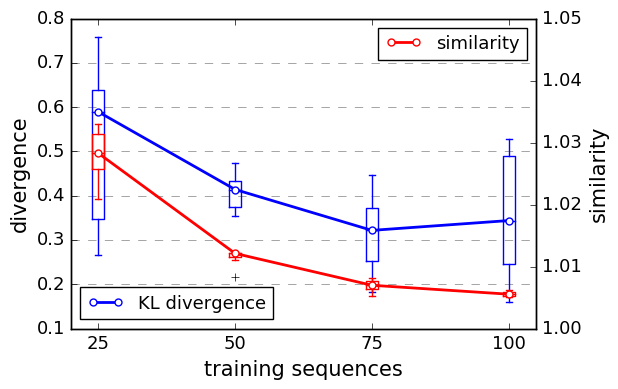

In [30]:

import oneclasscurve  as occ
sizes=[25,50,75,100]
#a,b = occ.get_results(repeats=2,sizes=sizes,njobs=4,argparam=1)

# THIS IS DRAWING THE STATE OF THE ART
result = [[[0.37799476857464187, 0.54617825293749689, 0.27904495772945098, 0.26726236373200735, 0.7082906777723178, 0.88213010308630257, 0.30718978262183866], [0.71592692669059554, 0.45831299551679167, 0.62742015798579531, 0.86002217013241988, 0.26140983066258033, 1.2127382746093192, 0.7320360542511205], [0.49551921864299003, 0.47734822972852786, 0.67660650677255985, 0.48828968805553546, 0.7092441404697386, 0.50073173552853234, 0.6123034760720153], [0.45016715764666043, 0.30331671045058001, 0.40127660584526365, 0.3416881146740347, 0.53615314676926862, 0.37887860416347841, 0.46004368267982215]], [[0.98295827417909365, 0.97154166543215337, 0.97236304957694397, 0.97203934413364934, 0.98299547013786148, 0.96072107422558317, 0.96651766101384773], [0.98952169525875544, 0.98905964300189153, 0.98203250029083267, 0.98595880837129612, 0.98944016582153804, 0.98304493418383632, 0.9848283499472017], [0.99002114078156878, 0.98870216096830477, 0.99004208636574897, 0.99162461252946699, 0.9908342160839203, 0.9839681324192131, 0.9869723984266513], [0.99484527254050859, 0.99639316402315259, 0.99662636719935771, 0.99760673107527276, 0.99471462464849558, 0.99482957900409275, 0.99374490041417418]]]


re= '''result = [[[0.37581779388964992, 0.72168206070861629, 0.36688498098995437, 0.58635464167451878, 0.52868202157837174, 0.42588967888706625, 0.63069316853441115], [0.58100875202534652, 0.30737263242588381, 0.64618155436767166, 0.63810747055001504, 0.31680206276217376, 0.46787767276715697, 0.56725633271362408], [0.3236698813874283, 0.41333311978935766, 0.53890150128962411, 0.41138805774059745, 0.39532070062971097, 0.43858653778234641, 0.51057238868654153], [0.7366091402233792, 0.45160063174280513, 0.52888148661776835, 0.45797015826526932, 0.4902035011780958, 0.28182270347308103, 0.39308711755403714]], [[1.0123666539562044, 0.988777307515185, 1.0057677198641259, 0.99749671148775254, 1.0041478130577048, 1.0104662378566382, 0.99901312903919193], [0.99594780388783677, 0.99582849488719194, 0.99593431605443494, 0.99537863937998428, 0.99336432100739869, 0.9955101402251767, 0.99354337095642176], [0.99703779825546412, 0.99188943312651645, 0.99507348751439373, 0.99125712556991175, 0.99625827670230127, 0.9951029222150104, 0.9956579199025235], [0.99607321035249841, 0.99410558339687849, 0.99529507707687792, 0.99482216678231927, 0.99453122330268762, 0.99502692102005841, 0.99450856631658946]]]
result = [[[0.18256729676510322, 0.71627851642233831, 0.60797092056967672, 0.77282817401370052, 0.55538118218315791, 0.23931018366694023, 0.37885263626368032], [0.3250043493527619, 0.82074933206918976, 0.47778675985258756, 0.20585708094961105, 0.13215492231967907, 0.43859022059622554, 0.37430651322857944], [0.53773560552580657, 0.45542866246784158, 0.65382853999947288, 0.39749751202384348, 0.36077924211506135, 0.25203820286993811, 0.58122788783658175], [0.36844853186673271, 0.61546509632095314, 0.64616534123475056, 0.44129074238248628, 0.66975861704664974, 0.54643966785988074, 0.52084902471188699]], [[0.97504580990472123, 0.97547759323134842, 0.99185081489860094, 0.98454388797048065, 0.98770969894779481, 0.98434633006786787, 0.98077629118179799], [0.98928824050828967, 0.99206993464294302, 0.99095093754759545, 0.98711298681802495, 0.98800004652821061, 0.9878746097098281, 0.99195839694663168], [0.99424956497998318, 0.99489218967887461, 0.99165748964699407, 0.99196987927108538, 0.99489456937152498, 0.99374953763576102, 0.9935237062295581], [0.99657217768780082, 0.99545616809521353, 0.99475036242790871, 0.99418724444515594, 0.99591086564855547, 0.99527771252465924, 0.9950725797733031]]]
result = [[[0.17533236082556028, 0.55217818673607377, 0.29807919626864959, 0.55938766020400699, 0.23836410129520022, 0.21562555226166139, 0.30771754974511195], [0.33161058741427502, 0.52979591217214816, 0.59922820966793233, 0.16173564117750958, 0.35863004835707796, 0.53843763940644196, 0.26658050129567373], [0.54125429297576122, 0.35374717325417082, 0.2096774424132328, 0.2933309932164534, 0.37338214859355628, 0.41772035779959826, 0.41250341710126309], [0.40089103641191187, 0.47005866722685835, 0.47669138532096683, 0.78644813990381246, 0.5918442173477404, 0.70905116366616616, 0.54411120067645868]], [[0.983179375665031, 0.97534716481900963, 0.99095216217970894, 0.99438523388379052, 0.98380018380899692, 0.99384257218961669, 0.9750913083607603], [0.98665119639945997, 0.98503634755464131, 0.98759102960922895, 0.98295719743447407, 0.99309052533115327, 0.98850076384256558, 0.98630746687948534], [0.9600240414363127, 0.95701946877258715, 0.97479742973692474, 0.97498159218873182, 0.95775093570576775, 0.96600857658118311, 0.9648885755749812], [0.97756183330472923, 0.96553105335356237, 0.97370487145781048, 0.97792474442068411, 0.97808059905028133, 0.96934698388759044, 0.97431687816973644]]]
result = [[[0.73799673068876803, 0.39202160707778461, 0.65325280927254237, 0.33036151321493906, 0.51259572523486308, 0.43939239915092293, 0.44085572063647677], [0.3091938389543834, 0.31243487107604379, 0.65527837950997436, 0.42945775135520492, 0.30120831467091774, 0.52472351791826999, 0.67970564203528783], [0.42086360761611497, 0.33611272754535432, 0.30338345433492159, 0.43987482475583373, 0.33084664618696324, 0.6944268598556812, 0.64631903758197751], [0.47262471286050012, 0.47584137658572656, 0.34472424857229883, 0.4122562614705847, 0.40894810616906824, 0.52847022337857541, 0.4938300539298453]], [[1.0099345920250833, 1.0127304136021329, 1.0136043680528191, 1.0148569944216352, 1.0068998949558534, 1.0104197048592551, 1.0104689752507507], [1.0022762266098857, 0.99911924538017427, 1.0027874593994177, 1.0014218019005749, 1.0032686983556052, 1.0018650162129776, 1.0029673995194697], [0.99899159884597466, 0.99673273438935694, 0.9972920800089814, 0.99574253723509221, 0.99754347007121469, 0.99626003085153969, 0.99383972449013513], [0.99320375167369956, 0.9952560187620284, 0.99678316803152633, 0.99505605531736629, 0.99774003470529793, 0.99653708879271652, 0.99468647592611681]]]
result = [[[0.37946672295895362, 0.25570532168065702, 0.40709577278309855, 0.44630672458884063, 0.51731026824214688, 0.28508964590533464, 0.34081153359857902], [0.50361725635414456, 0.31140022003742834, 0.73730546136970831, 0.5752227664755365, 0.47689277852115824, 0.31081038641150077, 0.39841622540545441], [0.51578339320695155, 0.53155477286596264, 0.28181074294045932, 0.31455562400374665, 0.54616222839807305, 0.47131150993497356, 0.32687747141852469], [0.46477823197571322, 0.79695575492046811, 0.7219546101863048, 0.55032220346278482, 0.84030291265461254, 0.42434835227143658, 0.3849508690034058]], [[1.0226832878286725, 1.0120061138752066, 1.0152028049785646, 1.0039843799844947, 1.014387759149626, 1.0186188608800328, 0.99852930774201343], [0.99857835151312402, 1.0024859029711437, 1.0085303831251042, 1.0058636760189292, 1.0019157947968429, 0.99702553779632275, 1.0036177533067132], [0.98641661124707603, 0.98944333459674239, 0.98620396504985264, 0.99465821524500186, 0.98734613882526789, 0.98890558889894142, 0.98580741460685528], [0.97760690909295744, 0.98150897512640478, 0.98359608573153345, 0.97617779658077952, 0.97817899998694635, 0.98548969902987626, 0.97879987395456769]]]
result = [[[0.25332960785406466, 0.5430415194598367, 0.36724520287966717, 0.6578962941884946, 0.18128069757214901, 0.23398867968407114, 1.0348912017348579], [1.1007470545920048, 0.30856169147479118, 0.20125017430684808, 0.39861397483692707, 0.27002623713024693, 0.42172440258329819, 0.2172835025231078], [0.55035772640541725, 0.3499785075180048, 0.4237243862200466, 0.32342331153247567, 0.52141697467158166, 0.48834886207398503, 0.34645968762389939], [0.42935982267733336, 0.47925116815485308, 0.42327551997277357, 0.29056622995733622, 0.27621408936530883, 0.36165928954274973, 0.22782351876341767]], [[1.0127793467143313, 1.0175312264619341, 1.0154972772374733, 1.0214358436791844, 1.0205979956316695, 1.0035842821049166, 1.019145941792891], [1.008640404379846, 1.0063211828585064, 1.0071041588138359, 1.0045985241323334, 1.0064150716154203, 1.00945837980786, 1.0067150177281223], [1.0050704427407644, 1.0031823351381743, 1.0032065177019736, 1.0032435626293028, 1.0032023879696923, 1.0014790076816062, 1.0039849656832085], [1.0008426656804967, 1.0019410169911305, 1.0007078936647078, 1.0009583043358441, 1.001641713529003, 1.0008170661155904, 1.0015029574934347]]]
result = [[[0.44512372989682625, 0.5707202395072315, 0.56004628419330238, 0.24428194463393493, 0.32756366402746762, 0.24794938949574638, 0.22815519349577515], [0.27789580871723413, 0.29462167747489787, 0.19302550629929374, 0.15507780804779148, 0.24603880484547849, 0.21981206121869237, 0.29622650225775515], [0.56667028673794029, 0.48761203538820541, 0.47267756275085199, 0.69241815063348078, 0.61041762802801314, 0.77598064489005969, 0.25258475544578585], [0.56347593857378586, 0.52479562685795489, 0.63914082100278369, 0.49798636022378667, 0.48655032239891133, 0.38464747982950825, 0.38163850524331616]], [[1.0164875735708512, 1.0297981365876472, 1.0109744597443899, 1.0236003241573455, 1.0093901394585849, 1.0238909570745642, 1.0245544970574558], [1.0021669064177474, 0.99844067963223748, 1.0001098849024901, 0.99090933636963063, 1.0045041619830579, 1.0015989909335732, 0.9926877719979319], [0.99482826719112349, 0.99159378801049147, 0.9933654355239776, 0.99416846002910997, 0.99503964364070308, 0.99368472103231409, 0.99338301223497671], [0.99074944499661799, 0.99304857466580576, 0.99198922093451847, 0.99273710506526813, 0.99501523882095433, 0.99019572997483651, 0.99153650815582794]]]
result = [[[0.32445270531744463, 0.56103641580189878, 0.24530179019665821, 0.44363850724603804, 1.3496905497185854, 0.57740800620215971, 0.19856803725651859], [0.36812878329999071, 0.42671265842538592, 0.34000130610934437, 0.43560727695582058, 0.248754967177096, 0.33064287608467574, 0.62370954784235633], [0.48053919589707145, 0.49195333634668298, 0.44620051450327763, 0.87497936519617081, 0.95029741966865522, 0.52693003689644946, 0.42255522411829632], [0.37981795255255646, 0.40095379785905766, 0.2658882642972466, 0.30701586501929018, 0.37253849171211045, 0.38986176130090894, 0.44560142861429264]], [[0.99868908811471258, 1.0073994680640372, 1.0140864383166837, 1.0111547682231119, 1.0139506158337688, 1.0093952554261496, 1.010270831976835], [1.004454706536374, 1.0030473613853506, 1.003344213434447, 1.00028045975379, 0.99923212486115964, 1.0027387505593213, 1.0008640467615633], [0.99972927511713738, 1.0004701949449075, 1.0003910869591885, 0.99990668928929893, 0.99645259418654741, 0.99998894457490572, 0.99953359687602072], [0.99621755128559375, 0.99584207258574575, 0.99745279078343441, 0.9953780674441628, 0.99683650110041533, 0.99782355296119896, 0.99726262078545125]]]
result = [[[0.54548394560933011, 0.46684448147904689, 0.34050708857613093, 0.38177736800505557, 0.43366446810444143, 0.34729327874668564, 0.3688860251698684], [0.52447837592412183, 0.72714275083595181, 0.91448557791059037, 0.95998173546992172, 0.99956747049849304, 0.66491052487355706, 0.9198162549900526], [1.1857023900999675, 0.8987098482532242, 1.1946901536113366, 1.2175708083106083, 1.1413032292507588, 1.5278208040717136, 1.085568863508215], [1.1226518735090296, 0.72438297890661085, 0.74774075362532377, 0.89890375992533122, 0.52660964145548583, 0.68469567728313863, 1.128359625888071]], [[1.0141406673284603, 1.0146511001298653, 1.012854201239648, 1.0139813052270739, 1.0085995660891329, 1.0039244436199131, 1.0096246097761754], [0.96101363261793893, 0.95501081792197928, 0.96473281356929175, 0.95048888399451859, 0.95138108526829257, 0.96073639010369905, 0.96010333662026071], [0.95563398335423366, 0.94405036652331076, 0.94639181615275958, 0.96934765575836535, 0.95183357150104508, 0.96365611234335558, 0.95093160793656839], [0.96579189687797817, 0.97573218925595628, 0.96958925256423689, 0.96692402206719308, 0.97420848215192091, 0.96971523355794098, 0.96767597376408632]]]
result = [[[0.62145798641661143, 0.42536915857080082, 0.9704992209378025, 0.52800714894722267, 0.28158471482150932, 0.24813488550693519, 0.70063025258873024], [0.55948081013047313, 0.84621239898393241, 0.91753068141788197, 0.67708415996651283, 0.71604527223343473, 1.0617980980646677, 0.77277611521603884], [0.44042450245087439, 0.59084962381783412, 0.59607648219038245, 0.98004029501117407, 0.62290536203692948, 0.74736756062420528, 0.71692701682572857], [0.62793672736748152, 0.86583377733906841, 1.6327894155194069, 0.45833793222030966, 0.65091447866633811, 0.69855150650997488, 0.463988027952772]], [[1.0173362455958681, 1.0283078823445064, 1.0167469337564066, 1.0102851869312484, 1.0236760831900937, 1.0093060072063029, 1.0302634297841176], [0.93227363257761164, 0.93300942160170675, 0.92668071557859433, 0.93830681254754755, 0.92407105640789156, 0.91116094225327549, 0.9241874226672907], [0.93930967202151106, 0.92772062448719728, 0.93309737787886193, 0.91659145557119059, 0.93242917555497462, 0.9190030237861645, 0.91809868944332595], [0.94803774489680648, 0.93241254561816511, 0.93761305846839427, 0.93523109116258296, 0.93775077688199338, 0.93266644703586732, 0.93990995207570405]]]
result = [[[0.68009350309572625, 0.22372117525145599, 0.43449233281119953, 0.24497457955910554, 0.2689023301815775, 0.49260110394612483, 0.56276321358320536], [0.7440761796270593, 1.0159899492190805, 0.90625199656582611, 0.7326469658397694, 0.54210844379550138, 0.89553353117682111, 0.83021763110122249], [0.65876942989570852, 0.74675840455089715, 0.84945410508500585, 0.5057364892247822, 1.1914461855212475, 0.46090396667377348, 0.56461727280954366], [0.59450065008057562, 0.87209487910360195, 0.69699907012864537, 0.68808657882754221, 0.56483463482312157, 0.6141226003545458, 0.8708806356967701]], [[0.98993596521886795, 1.0240156217487724, 1.0021230744654857, 1.0307980011086975, 1.0086770550580673, 1.0257054584019805, 1.0324174135552739], [0.93158890883295975, 0.9495922238859259, 0.93112478026830914, 0.94678301931024789, 0.95504633363589631, 0.95956536916793578, 0.94178979565647836], [0.9369606414353997, 0.94530932971466264, 0.93072161629288397, 0.9448276662932904, 0.94740928583507011, 0.94141744776870873, 0.94027365878556424], [0.95896017990420801, 0.97494739605399316, 0.95238313778273131, 0.96552771825126726, 0.96012992319627843, 0.97006717047209379, 0.9520126796938494]]]
result = [[[0.27754260385175283, 0.1943753657475937, 0.29122508366935312, 0.86221518876940362, 0.36465631722191955, 0.43540357241368127, 0.30732765887608254], [0.58444904628081806, 1.0532954251006748, 0.671165232621727, 0.77481581611669503, 0.76742605498937821, 0.57103161490233323, 0.41030074220022206], [0.70190604283428115, 0.54558111448839508, 0.98670376306686736, 0.67954158821071609, 0.60162878042583989, 0.87245874908536958, 0.92643748961100858], [0.37558847726364708, 0.55978832637328091, 0.53504339312544558, 0.43056366696847365, 0.40640244689593857, 0.44940585129737015, 0.46129861066923822]], [[1.0164116420681546, 1.0049135946618306, 1.021678756632888, 1.0211538156243223, 1.0217501257564281, 1.0139564111407147, 1.0208286181364348], [0.98423657154711508, 0.97001718580687435, 0.95990863400539472, 0.96406620875804527, 0.96346680611950164, 0.96120588315488376, 0.96651136346376476], [0.96704085845052823, 0.96311096832581666, 0.95758014004002712, 0.96365400050021732, 0.96806964653611194, 0.95812385583736703, 0.96821958965209276], [0.98145976550583436, 0.98309261169155249, 0.97920777861173203, 0.98449057165979947, 0.97661313074547862, 0.98300358623552531, 0.97833898494440397]]]
result = [[[0.80823337736354528, 0.51598160296214679, 0.29004545275334503, 0.49300949034498903, 0.56670828535554307, 0.54503141764446572, 0.26391104824070305], [0.91885495341188994, 0.50239094508701099, 0.85778188443153791, 0.95487858896667444, 0.83071756500323179, 0.76120774499270671, 0.67570862615341587], [0.95670251885388724, 1.0920915853033859, 0.74559911194021911, 1.3835166069115743, 1.0560264849187742, 1.0380868881715009, 1.0387780038701357], [0.94832800290952146, 0.47496423179104691, 0.57221719682454497, 0.75533448992569996, 0.75834166633847044, 0.75708538073979703, 0.5182306808738063]], [[1.0032984947071073, 0.99871402858777047, 1.0061831676340123, 1.0080709661341078, 1.0005918981482782, 0.99770103922756892, 0.9981456825776539], [0.96280081309139265, 0.96031680635793382, 0.96416999304566031, 0.96245807891125401, 0.95305373427029516, 0.95445743998173638, 0.95560749066963302], [0.96562891022523156, 0.96830040826998309, 0.96867460425228546, 0.96128860256943016, 0.96393574400774473, 0.9570158074630275, 0.96650040476509014], [0.97790094670123362, 0.9848007855212898, 0.98186124953941345, 0.984292732908158, 0.98188018098359131, 0.97574215805166431, 0.98420722041168363]]]
result = [[[0.57994803339806866, 0.20627312001446022, 0.2614135005656365, 0.22087333405243381, 0.59993186830335243, 0.23113340814774952, 0.54350700582287603], [0.98748946351661215, 0.51055746992166462, 1.148512978105982, 0.80035688936279437, 1.0272202020085577, 0.67875921790294935, 1.5246259362902304], [0.85553835513140319, 0.92993533777157023, 0.8194682405069198, 0.70371890644976187, 0.83719233196138454, 1.2350523274613925, 0.83824229339709533], [1.1461282357324414, 1.1220888360343451, 1.3274944201197236, 0.7511919294717323, 0.92677388186284571, 1.0078170303699363, 0.87185139314580684]], [[0.9739413602475816, 1.0176492386755072, 1.0156840668009239, 1.0135330108134373, 1.0138059801256305, 1.0082435172457525, 1.0152544050816745], [0.92135625165659574, 0.91178548920271985, 0.91583848893087094, 0.90916652633105621, 0.91539025845534572, 0.92486848617582385, 0.91184775200872625], [0.92668869798077746, 0.93496186231895817, 0.94280976162657792, 0.96670643263161538, 0.93243281905077857, 0.94941214928662121, 0.93463773245144921], [0.95870350093465684, 0.95891379530116716, 0.97150847640017435, 0.97722723595584449, 0.95677412714279997, 0.95349006716175488, 0.9614571012912162]]]
result = [[[0.2750041287417056, 0.59447795662485048, 0.48092049594403341, 0.40579274547999461, 1.197921486032721, 0.20877549184340163, 0.52674204632450661], [0.74299364395020129, 0.42255556393446209, 1.1337029850104952, 1.3265565302511855, 0.44018234252350763, 1.0397803552834, 0.80870549189960361], [0.85807226362841804, 1.1021778472250581, 0.93065772735554619, 0.99640947141854408, 0.89539348080736192, 0.88714526373430225, 0.74536750855510492], [1.4107194213128045, 1.12721618208026, 1.1143948343329488, 1.3079173077422208, 1.1623194779060027, 1.2196788005083328, 0.90209699625407891]], [[0.97233823634512206, 1.0300445253103441, 1.0110995786893557, 1.0097077626028204, 1.0335727104040542, 1.0165682574867236, 1.0240555401031517], [0.88401507277167568, 0.88754737814945217, 0.83168649840232611, 0.86820421069414966, 0.86950504489760505, 0.84510887283762159, 0.81841242894464572], [0.88651813689504089, 0.93193031107728996, 0.93219351848615539, 0.93597661574154722, 0.90495391381295731, 0.8975209535614479, 0.93016572926629282], [0.93640915752751119, 0.92400380035918672, 0.92801547026103848, 0.94171789500048109, 0.93394682295556031, 0.95236975838181559, 0.93992665716747581]]]
result = [[[0.14450986939460311, 0.3803042481504772, 0.43008219902508832, 0.37598974739725538, 0.5392830933902738, 0.18427156404077297, 0.47705352510136545], [0.47004583294241314, 0.4584100884791093, 0.50552788351650069, 0.46268638245711097, 0.42593618554008145, 0.23886345035157652, 0.50737279572979099], [0.42983357535575722, 0.52852588726065619, 0.40835831197829159, 0.33906500108496723, 0.56207164193089854, 0.51666990939737301, 0.26563460515294207], [0.57665793012944599, 0.36268414009558381, 0.38502311534807304, 0.52871228449341923, 0.53365319158255264, 0.51127281679100867, 0.57440452712143431]], [[1.0304589046563297, 1.0230768982483076, 1.0280801149125278, 1.0346911600233468, 1.0293721827471212, 1.0354884006774847, 1.0236523663523089], [0.96676925614659071, 0.98311012282154842, 0.97617520489122533, 0.95658377748674872, 0.97517620776849057, 0.9729842158700327, 0.97140221084340228], [0.98382848613751162, 0.96606026291328106, 0.9833238851946372, 0.98062874983341519, 0.96958501361890537, 0.97155958315879543, 0.97180666661793225], [0.97731900845125308, 0.99238298894525778, 0.98619660747412941, 0.98051203276187493, 0.98716754468400469, 0.98458358300479543, 0.97795629821101016]]]
result = [[[0.52939402497567223, 0.36770306523157198, 0.21510450539965217, 0.084760776004408414, 0.33354886142208429, 0.32961949092167447, 0.2125145404330375], [0.78106855563665245, 0.64098457607083714, 0.45149995492727485, 0.53027423314574762, 0.54470603089659508, 0.62774364515505132, 0.54419594966216933], [0.41787710840595543, 0.58508923069831464, 0.90011387366062079, 0.68871506953205497, 0.57360955983274742, 0.48098661677689464, 0.57847409237848613], [0.4563689176385517, 0.66955165190575128, 0.5363002712012811, 0.55122849358132342, 0.56652170015614034, 0.62335272919606155, 0.61088767404768551]], [[0.96333519871003959, 1.0127385096927726, 1.0248545211858808, 1.034250235503434, 1.016631216372698, 1.0177528759524159, 1.0255029514089138], [0.97148813735132689, 0.980680535405827, 0.98620806045719234, 0.982220662634263, 0.98271618767766111, 0.97696472641984144, 0.9845613578467689], [0.9681150962362628, 0.96554719627388086, 0.9648177536271576, 0.97238788052986036, 0.97226893696466044, 0.96848452057358325, 0.97588203331071421], [0.98096917938584582, 0.9822822936011355, 0.98252143621878119, 0.97786665817321261, 0.98116494109488617, 0.97769801319877314, 0.98346891196352038]]]
result = [[[0.28862992254353043, 0.42019937646887257, 0.39451241589406388, 0.30041661474056042, 0.36266224731223379, 0.48813307712089177, 0.50793610636990871], [0.4114037099705814, 0.45046531489200409, 0.32802795012441893, 0.260350016127888, 0.30242773235019815, 0.34850445106008837, 0.29865031281796495], [0.51215009269156564, 0.55476650605499189, 0.52876813561113423, 0.26289626751076406, 0.55429586307532064, 0.59623362594208473, 0.75469840995458959], [0.3978786577486339, 0.63241068668323441, 0.6319734829030722, 0.42927178110955327, 0.47565143128310888, 0.45627029651824857, 0.44610333607362634]], [[0.90083822116807133, 1.0019386263754233, 0.99716547190709948, 0.98908333335083265, 0.99695954780098994, 0.99308157485427795, 1.0039075047391297], [0.98788585308658672, 0.99166104219329287, 0.99328950823579443, 0.99181516561457228, 0.99297788037111123, 0.99123840626124704, 0.99072533024287779], [0.99416657014085774, 0.99434305618556595, 0.99391501521178693, 0.99052375105515833, 0.99105532433726462, 0.98778514720491972, 0.98861329449089386], [0.99189512097115762, 0.98923209444814197, 0.99192124382312108, 0.99255783449161616, 0.99304701518378002, 0.99056854072290612, 0.99058270530797898]]]
result = [[[0.31614218348998302, 0.28961730898471844, 0.19962121259185386, 0.65990362902727429, 0.41364244505362774, 0.23800542306242023, 0.95473842327946434], [0.47136749032764252, 0.54984351026504052, 0.34008823156301932, 0.22282041973499597, 0.42065820707331286, 0.51522861069862314, 0.41346330130767711], [0.54576406122527377, 0.66685221350134516, 0.43159445496554355, 0.25436756364263291, 0.56164441283294508, 0.40441208330053541, 0.41605108558297249], [0.44091521316244003, 0.36485784071069616, 0.35207478680931054, 0.21711170207483044, 0.30353537936481095, 0.50889533255334596, 0.35236625732963284]], [[1.0090110360917661, 1.0089349355334019, 1.0100553299350166, 1.0096354626098771, 1.0138162740079479, 1.0150913568120592, 1.0052539666639693], [0.99771691033252807, 0.99600531009332516, 1.0039690971154989, 1.0025644274639187, 1.0057789614575476, 0.99909158829337152, 1.0007310181014606], [0.99857554923721281, 0.99796121350424771, 0.99625637862473437, 0.99906811367921389, 0.9958874586630998, 0.99872127390806287, 0.99850770967995073], [0.9959953021133201, 0.99561756268962842, 0.99340373371416146, 0.99511248666902286, 0.99727659727929896, 0.99711001377752539, 0.99801838485077865]]]
result = [[[0.37799476857464187, 0.54617825293749689, 0.27904495772945098, 0.26726236373200735, 0.7082906777723178, 0.88213010308630257, 0.30718978262183866], [0.71592692669059554, 0.45831299551679167, 0.62742015798579531, 0.86002217013241988, 0.26140983066258033, 1.2127382746093192, 0.7320360542511205], [0.49551921864299003, 0.47734822972852786, 0.67660650677255985, 0.48828968805553546, 0.7092441404697386, 0.50073173552853234, 0.6123034760720153], [0.45016715764666043, 0.30331671045058001, 0.40127660584526365, 0.3416881146740347, 0.53615314676926862, 0.37887860416347841, 0.46004368267982215]], [[0.98295827417909365, 0.97154166543215337, 0.97236304957694397, 0.97203934413364934, 0.98299547013786148, 0.96072107422558317, 0.96651766101384773], [0.98952169525875544, 0.98905964300189153, 0.98203250029083267, 0.98595880837129612, 0.98944016582153804, 0.98304493418383632, 0.9848283499472017], [0.99002114078156878, 0.98870216096830477, 0.99004208636574897, 0.99162461252946699, 0.9908342160839203, 0.9839681324192131, 0.9869723984266513], [0.99484527254050859, 0.99639316402315259, 0.99662636719935771, 0.99760673107527276, 0.99471462464849558, 0.99482957900409275, 0.99374490041417418]]]'''


re= '''result = [[[0.37581779388964992, 0.72168206070861629, 0.36688498098995437, 0.58635464167451878, 0.52868202157837174, 0.42588967888706625, 0.63069316853441115], [0.58100875202534652, 0.30737263242588381, 0.64618155436767166, 0.63810747055001504, 0.31680206276217376, 0.46787767276715697, 0.56725633271362408], [0.3236698813874283, 0.41333311978935766, 0.53890150128962411, 0.41138805774059745, 0.39532070062971097, 0.43858653778234641, 0.51057238868654153], [0.7366091402233792, 0.45160063174280513, 0.52888148661776835, 0.45797015826526932, 0.4902035011780958, 0.28182270347308103, 0.39308711755403714]], [[1.0123666539562044, 0.988777307515185, 1.0057677198641259, 0.99749671148775254, 1.0041478130577048, 1.0104662378566382, 0.99901312903919193], [0.99594780388783677, 0.99582849488719194, 0.99593431605443494, 0.99537863937998428, 0.99336432100739869, 0.9955101402251767, 0.99354337095642176], [0.99703779825546412, 0.99188943312651645, 0.99507348751439373, 0.99125712556991175, 0.99625827670230127, 0.9951029222150104, 0.9956579199025235], [0.99607321035249841, 0.99410558339687849, 0.99529507707687792, 0.99482216678231927, 0.99453122330268762, 0.99502692102005841, 0.99450856631658946]]]
result = [[[0.18256729676510322, 0.71627851642233831, 0.60797092056967672, 0.77282817401370052, 0.55538118218315791, 0.23931018366694023, 0.37885263626368032], [0.3250043493527619, 0.82074933206918976, 0.47778675985258756, 0.20585708094961105, 0.13215492231967907, 0.43859022059622554, 0.37430651322857944], [0.53773560552580657, 0.45542866246784158, 0.65382853999947288, 0.39749751202384348, 0.36077924211506135, 0.25203820286993811, 0.58122788783658175], [0.36844853186673271, 0.61546509632095314, 0.64616534123475056, 0.44129074238248628, 0.66975861704664974, 0.54643966785988074, 0.52084902471188699]], [[0.97504580990472123, 0.97547759323134842, 0.99185081489860094, 0.98454388797048065, 0.98770969894779481, 0.98434633006786787, 0.98077629118179799], [0.98928824050828967, 0.99206993464294302, 0.99095093754759545, 0.98711298681802495, 0.98800004652821061, 0.9878746097098281, 0.99195839694663168], [0.99424956497998318, 0.99489218967887461, 0.99165748964699407, 0.99196987927108538, 0.99489456937152498, 0.99374953763576102, 0.9935237062295581], [0.99657217768780082, 0.99545616809521353, 0.99475036242790871, 0.99418724444515594, 0.99591086564855547, 0.99527771252465924, 0.9950725797733031]]]
result = [[[0.2694614102393405, 0.47824603649141473, 0.39393548007900653, 0.60659823391671985, 0.5128502436016662, 0.59045542681670382, 0.55791703908444212], [0.31843554514699485, 0.7613566287628406, 0.86192741708440979, 0.53385855208461119, 0.76430873338653438, 0.80447070955426214, 0.78077152718006715], [0.52093039931488649, 0.41027925518401132, 0.52549534810390919, 0.46376658299393347, 0.57695089212956496, 0.70416768206960112, 0.32599827030452422], [0.72965519519182387, 0.49858843720698048, 0.61133793053462704, 0.93720194493772624, 0.68622851274082208, 0.67588918813560939, 0.74710171623879507]], [[0.99828614841741425, 1.005958939031274, 1.0057875349383869, 1.0046996018615375, 1.0010333737497865, 1.0042865933634255, 1.0040916480179927], [1.0009302692498017, 1.0013354426087493, 1.0002748073726344, 1.0012515784502776, 0.9994489818712724, 0.99932287351431037, 0.99952249037576857], [0.99816454062210835, 0.9972307762625946, 0.99800251770329196, 0.99495280513109441, 0.99648830267373267, 0.99565648467123069, 0.99630469301187163], [0.99498808097027225, 0.99327294172425462, 0.99536542592705501, 0.99373348333448097, 0.99753095243899625, 0.99576374591155437, 0.99589263237309977]]]
result = [[[0.49165982739750747, 0.56543047401793978, 0.59805442050766777, 0.36065073946060355, 0.61132052214245425, 0.4017006309741129, 0.30972190387657889], [0.55267667257773823, 1.2646514853416015, 0.39803609930698691, 0.50421516959433588, 0.26754153457957291, 0.99326818226761093, 0.5674681956995915], [1.2037899635860059, 0.88197755249645449, 0.40074088098303595, 0.4550305014933993, 0.79675492537593673, 0.5034380238200028, 0.41471942026144859], [0.64957076425240146, 0.67436523003876558, 0.73012604619031274, 0.53933630855309056, 0.97519830305832256, 0.73419546373409295, 0.63504132001934011]], [[1.0056309966364778, 1.0038934166684907, 1.0048751140705812, 1.0019485400377477, 1.0056336742874548, 1.0039593116392282, 1.010937310031307], [0.99705707102964547, 0.99848237983744503, 0.99502099637636321, 0.9984420899987666, 0.99661111004152647, 0.99441629841915169, 0.99755799181255267], [0.99003419050465635, 0.99332191331924147, 0.98920040753413319, 0.99368695037615029, 0.99488640598784794, 0.99408151725216354, 0.99630328191639528], [0.98314589908805738, 0.98080028708061118, 0.98668241227366815, 0.98552923735611053, 0.98861802982136771, 0.98428469985434552, 0.98331338241243504]]]
result = [[[0.44164682660396642, 0.34999169446280948, 0.37672410787126315, 0.24384404676731894, 0.29996879146695005, 0.68653215598040962, 0.40215668988425785], [0.56805838197492253, 0.24650042594055452, 0.32646580740554709, 0.39785263527381631, 0.33730186006653634, 1.0029229272322233, 0.43338745448228555], [0.71750890377065668, 0.97370022862602201, 0.47417194839314686, 0.53225247130449216, 0.46989578899124668, 0.43540552566960661, 0.7054777342759776], [0.49832032459776854, 0.66026360254040883, 0.52469861041946497, 0.47895110964633797, 0.35821551482083924, 0.5545225177811498, 0.46225915191109879]], [[0.99399806003835811, 1.0078071817003333, 1.0100509180556752, 1.0072374965151916, 1.0057435799799797, 1.0111121509467846, 1.0098562752261115], [0.99513062035619337, 0.99905518019362705, 0.99605039760732883, 0.9989530906407933, 1.0010364413211359, 0.99935517558829956, 1.0000262829210458], [0.99564996563988939, 0.99515796919836741, 0.99570357754721084, 0.99125303028696876, 0.99396558781234357, 0.99601982726410787, 0.99623722216279864], [0.98973305486383145, 0.99096197211504744, 0.9887131275770481, 0.98770698519087508, 0.98646699826894602, 0.99067562024944422, 0.9903323839223136]]]
result = [[[0.54230907156555797, 0.21674984389458851, 0.61494393186687479, 0.59771745120046171, 0.35568484535968753, 0.26775749551393208, 0.38776368093476798], [0.49646601393859063, 0.56344253530995003, 0.22413253318761683, 0.24069825004867865, 0.32377129494204876, 0.30464680690319984, 0.64946834530165198], [0.58839112635357604, 0.26252244982793549, 0.59172895919601476, 0.54278249564290382, 0.67092743773355856, 0.35381086113345755, 0.4391984567921649], [0.78196712977117244, 0.75104784809350023, 0.53112341623038573, 0.39168812430676403, 0.54154936242701723, 0.42912131240785967, 0.52855470430520923]], [[0.99639715200652668, 1.0105323138858056, 1.0071217663260508, 1.005496329007187, 1.008092102500534, 1.0093780931839436, 1.005171309714685], [0.99596483439531969, 0.99681236104056248, 0.99544234602150139, 0.99723315911864618, 0.99743346716743997, 0.99613468315830367, 0.99929628564463113], [0.99361187702658504, 0.99473987987061274, 0.99217731106577478, 0.99232399420074269, 0.99520135669081189, 0.99387929194971936, 0.99252824733348655], [0.98449533145015744, 0.99328455044841402, 0.98681795403357653, 0.99024101579658452, 0.98697114095213745, 0.98618295628850383, 0.98485761024429275]]]
result = [[[0.2738376297797474, 0.44960959340479739, 0.53051605120945677, 0.67397455149001517, 0.54529549572797642, 0.41993817366574965, 0.5005332866793829], [0.40963967802514584, 0.87748364347171515, 0.32535865337104436, 0.2823683175928044, 0.4879194616193801, 0.38840294308888795, 0.21936688451353537], [0.53482804657494853, 0.58748304909877902, 0.35509142421274992, 0.66855214525663487, 0.59132728507796584, 0.34536445194250637, 0.53097454625243501], [0.57297303332697191, 0.61414337522702578, 0.41186496567024539, 0.64473697576311439, 0.78180792515117759, 0.43024547902190208, 0.83479055682800496]], [[1.0086920896050537, 1.0082853681800603, 1.00655497810974, 1.0050977790070263, 1.0107730533201833, 1.007418771635104, 1.0071332798056567], [0.99393152139167229, 0.99612029398922453, 0.99424798799923053, 0.99862404164835317, 0.99263776863198827, 0.99427733934399121, 0.99324502908781087], [0.99206636536212156, 0.98784019622069918, 0.9865078145025229, 0.99068930259342247, 0.9903774752502682, 0.98859622130443681, 0.98348483171199574], [0.97650986033554266, 0.9793737387495558, 0.98415558603339393, 0.98321477320764927, 0.98582675678160303, 0.98189340135570047, 0.9815039687730539]]]
result = [[[0.58046503318961951, 0.34783147752896032, 0.41931400142796638, 0.71849832075287112, 0.71480232588044768, 0.37041786480067279, 0.33018918137053044], [0.60058904536252233, 0.47573884652064669, 0.27401776971290931, 0.64229838294113362, 0.27498913933192176, 0.46027879733814231, 0.49459170361747035], [0.28812279107463101, 0.96358992640305063, 0.21916898442608182, 0.70107751073309998, 0.48173401346098493, 0.6146005571775216, 0.70876360430222018], [0.69104497117271568, 0.66093092313039259, 0.38244023087753765, 0.61582600707565771, 0.50427657869646902, 0.56254521807789082, 0.41245718611991222]], [[1.0087246537040548, 1.0053591062850913, 1.0045453999389153, 1.0103620045538684, 1.0092801414521027, 1.0106012492116896, 1.0025330302456843], [1.0033356529697413, 1.0019530334512492, 1.0014551471330797, 0.99517628558715754, 1.000110760400597, 1.0024583651331886, 0.99865621890829759], [0.99963319295597985, 1.0007190829204207, 1.0004968820426314, 0.99884231899151343, 0.99915347475726091, 0.99761743943068859, 0.99855185908105826], [0.99759884518247832, 0.99803853206160553, 0.99820579927738584, 0.9981315480414944, 0.99760561370986267, 0.99753868188708816, 0.99645712715954249]]]
result = [[[0.5109333474388037, 0.56529038498504491, 0.41304583491914909, 0.46295051826703171, 0.58790973777600253, 0.29021995324115607, 0.15586458805463352], [0.55823945816319176, 0.61365612209775644, 0.88287891868026713, 0.64058380889969346, 0.44567525169045291, 0.66701454955904904, 0.40810490347979389], [0.57918344812553557, 0.81691385457573251, 0.60241490687289145, 0.96542547158202308, 0.52122285007749003, 0.44913543636179759, 0.51828428178767505], [0.55207377430888183, 0.51089629622658339, 0.52413870533062912, 1.1030069190008529, 0.53475279292460254, 0.41186685912759896, 0.71361661012654165]], [[0.99795824115679477, 1.0027335050029991, 1.0052377537962205, 1.0015368162029659, 1.0045847981202318, 1.0011773880770327, 1.0038650295721256], [0.99708418449262448, 0.99789481576417316, 0.99698800309774749, 0.99904834872600856, 0.9977067510241282, 0.99545888675210015, 0.99839944050950868], [0.99441041808070652, 0.99431021221465321, 0.99460315258560095, 0.99512051250491107, 0.99477062974275332, 0.9941250051239704, 0.99294668147579523], [0.99139643419514922, 0.99192325101862044, 0.99197793307470261, 0.99054191044035, 0.99169887431042825, 0.99085802815464086, 0.99248053666549163]]]
result = [[[0.29284167569586561, 0.50070729146297166, 0.38687452247145515, 0.24075753270515446, 0.36722197120561356, 0.5121748627076127, 0.32381788320905208], [0.28443015208232492, 0.47272158824954907, 0.59156603400563312, 0.63226721501424266, 0.29425959307234834, 0.74948803651577889, 0.51857253143572446], [0.49570371912804273, 0.40917199763159462, 0.45925623364533896, 0.51987118608617189, 0.44802391548413895, 0.54953815614725199, 0.33284302460191034], [0.57677446133962684, 0.66560301198011773, 0.47089047450024885, 0.57425781214419447, 0.56094653598007582, 0.52992346799069601, 0.69602332343079354]], [[1.0129438653997778, 1.0089923478899285, 1.004924860419089, 1.0047718388460671, 1.0081973187819566, 1.0003240773569073, 1.0027783405289645], [0.99983010390528038, 1.0028478298707404, 0.99783889824874328, 1.0037623028286524, 1.000562464327905, 0.99946374642261271, 0.99924372211462054], [1.0007975653477383, 0.99482096892345118, 0.99766153081894526, 1.0020076981654138, 1.0031035303878428, 0.99889147295178848, 1.0009534338684554], [1.001400113938147, 1.0021521186215485, 1.000476909130636, 1.0002733072985368, 1.0009031221678077, 1.0002668891070701, 1.0006976123515345]]]
result = [[[0.44237945573058873, 0.45919594468995101, 0.79647860067104181, 0.27107070138852851, 0.58275890442812983, 0.3003979544879618, 0.32340438676553701], [0.48138050993273701, 0.68452537005831859, 0.63794020238987104, 0.74358735304485302, 0.47041382705022422, 0.26976713820192794, 0.26793685268241441], [0.94369588129784443, 0.40405891432983254, 0.71350333539843058, 0.49807437522848325, 0.70768473218327665, 0.91363163045898188, 0.77641958377721065], [0.40874995766867322, 0.55049021918071828, 0.51814318006916393, 0.62879180044841532, 0.36618557043963224, 0.5056312278049665, 0.56114170692493814]], [[1.0063906823475315, 1.0062954679045235, 1.0080271639623453, 1.0036649640047977, 1.0067162886659098, 1.0058046114472974, 1.0071453765271432], [0.99681481052984777, 0.99731467435315813, 0.99926848290730619, 0.99697001538200436, 0.99965611540261945, 0.99780487862721279, 0.99789568910084514], [0.99500132333463376, 0.9964468305674723, 0.99378478346733645, 0.9954171201324965, 0.99536819935817378, 0.99674764297769025, 0.9942811695002679], [0.99284457133761783, 0.98359587052800246, 0.98896152711333274, 0.98808182311996284, 0.98851134535144347, 0.98974291663152991, 0.99102555716642138]]]
result = [[[0.61454599422032985, 0.8300654496058435, 0.75114694760524314, 0.26664307982270885, 0.42793855815106835, 0.47613003806426507, 0.95493038627304783], [0.70999841769347061, 0.62778094264490825, 0.31628314972316546, 0.45571694828853349, 0.50687755378352362, 0.72190505435512897, 0.44494655009866807], [0.29439480931831458, 0.41890409358132996, 0.83263401768461953, 0.57098003529047014, 0.75954672575084536, 0.60683579465098536, 0.37620818260432332], [0.61804982243902129, 0.62521325872260203, 0.5381119727634851, 0.50437953084517406, 0.81633352451970576, 0.54217240707596526, 0.58637909570887325]], [[1.0045269515806203, 1.0042346812004022, 1.0022143454571166, 1.0038995455731374, 1.0035146626430871, 1.0018608577708992, 1.0056140268953719], [1.0010062123413679, 1.0009140731036832, 1.001286322622581, 1.0012767793561645, 1.0001515587545671, 1.0004925293909084, 1.0006038145335732], [0.99769846399508022, 0.99808417365793689, 0.99779401641976484, 0.99953861656324317, 0.99768300567271928, 0.99804650566801634, 0.99764679733540285], [0.99816648278762132, 0.99790409533088886, 0.99691009035471601, 0.99756816080900179, 0.99651363877467092, 0.99612738990566785, 0.99713320161544938]]]
result = [[[0.30392084687833926, 0.15972269380996709, 0.52385499560456295, 0.31799733660451229, 0.33984655990154627, 0.24982385325623133, 0.42638920132619501], [0.38393183265149505, 0.53899841780045554, 0.3228482805757884, 0.19086306192828084, 0.42221689185077821, 0.38341738981536871, 0.23205219172409941], [0.33287945258220392, 0.43204767590089271, 0.42452160647373455, 0.38420314620974966, 0.29571983412365532, 0.4609695821876445, 0.36515860512631865], [0.38199351428590161, 0.42632465555392218, 0.49466045742925324, 0.60248807979931984, 0.37253421554138194, 0.30362093239342719, 0.52220967371802285]], [[1.025470761494045, 1.0277297047600749, 1.0340640054988495, 1.0187060258887946, 1.0244306384439694, 1.0257747383293905, 1.0222754716436098], [1.0049797231890083, 1.0052934443251427, 1.0038947958463695, 1.0045907647669901, 1.0004429530545373, 1.0089603726101783, 1.0039557253475462], [0.99140483889271447, 0.99577937221885882, 0.99431210400261572, 0.99442686646103939, 0.99438147275705902, 0.99469402015891528, 0.99317979471495754], [0.99202784435230451, 0.99481718824388243, 0.99088056689618031, 0.9921440095200037, 0.99407635766083779, 0.99610564924396605, 0.99196014762148932]]]
result = [[[0.5230307677844509, 0.51764327064031601, 0.41843012849888656, 0.42736661896503109, 0.56960377694755426, 0.65015448502694773, 0.34173381308505668], [0.61838830878605655, 0.7762418033669638, 0.45742640362844161, 0.56762299870379451, 0.78051800063084997, 0.69681855537410486, 0.67958905304827877], [0.32652597728783639, 0.56733348177909215, 0.69030920577964838, 0.46155466675563295, 0.38955980272619878, 0.8563981744651713, 0.74273254303159764], [0.36607876309157339, 0.38922200653817213, 0.42704472763079132, 1.005339375691541, 0.54161452049639747, 0.62554187201621003, 0.47993663619193527]], [[1.0060659266434553, 1.0029722186312782, 1.0105300772128749, 1.0064192454909782, 1.0039696596345185, 1.0070240011779319, 1.0045819681694457], [1.0008840719162611, 1.0016421282815806, 0.99948097640699718, 0.99730280752544809, 1.0018580419628262, 1.0011588825014421, 1.0020838296040124], [0.99592278496922326, 0.99815398434409253, 0.99827166874836637, 0.99580887549731434, 0.99671298754571236, 0.99955191868840376, 0.99923877255454618], [0.99641178392427154, 0.99750734775589878, 0.99641879514559129, 0.99706260482323716, 0.99521502843088738, 0.99757241992995238, 0.99737328004010306]]]
result = [[[0.17533236082556028, 0.55217818673607377, 0.29807919626864959, 0.55938766020400699, 0.23836410129520022, 0.21562555226166139, 0.30771754974511195], [0.33161058741427502, 0.52979591217214816, 0.59922820966793233, 0.16173564117750958, 0.35863004835707796, 0.53843763940644196, 0.26658050129567373], [0.54125429297576122, 0.35374717325417082, 0.2096774424132328, 0.2933309932164534, 0.37338214859355628, 0.41772035779959826, 0.41250341710126309], [0.40089103641191187, 0.47005866722685835, 0.47669138532096683, 0.78644813990381246, 0.5918442173477404, 0.70905116366616616, 0.54411120067645868]], [[0.983179375665031, 0.97534716481900963, 0.99095216217970894, 0.99438523388379052, 0.98380018380899692, 0.99384257218961669, 0.9750913083607603], [0.98665119639945997, 0.98503634755464131, 0.98759102960922895, 0.98295719743447407, 0.99309052533115327, 0.98850076384256558, 0.98630746687948534], [0.9600240414363127, 0.95701946877258715, 0.97479742973692474, 0.97498159218873182, 0.95775093570576775, 0.96600857658118311, 0.9648885755749812], [0.97756183330472923, 0.96553105335356237, 0.97370487145781048, 0.97792474442068411, 0.97808059905028133, 0.96934698388759044, 0.97431687816973644]]]
result = [[[0.29307892482975623, 0.28090458316802813, 0.37825635161069493, 0.22167003255420425, 0.21006609424810016, 0.81301296614951679, 0.10588652543023995], [0.49872871895307364, 0.28609146794272944, 0.40872641867496001, 0.1477608031880786, 0.39134747498546685, 0.21077400151017689, 0.2420287362454977], [0.24095313163199306, 0.37102629048031788, 0.33160180525362293, 0.32293462374161347, 0.40422311505692471, 0.21468214998673874, 0.32084223977089255], [0.37830258562404812, 0.39171263551913132, 0.39517654440955602, 0.25824773863092193, 0.3867573815008663, 0.41904990018495597, 0.40899375771064622]], [[1.0231819439553991, 1.0111183429060127, 0.99488080836876058, 1.014641139197171, 1.0137960322800088, 1.0082328125234385, 1.0171424860766882], [0.9993658900154111, 0.99873002460122284, 1.0030412536757805, 1.000768768641948, 1.0021622792758087, 0.99718739548102775, 1.0025971234474593], [0.95344115411304997, 0.9401507822091032, 0.94910139723109277, 0.93947696185601015, 0.93502184798748278, 0.96585871182250083, 0.94270155603196348], [0.94808498946996367, 0.94438319617294841, 0.94395290484014149, 0.95819520186003471, 0.95252017952991397, 0.94445375851001323, 0.93489535753880826]]]
result = [[[0.22340118984017465, 0.26529421066963382, 0.42479906948303953, 0.25354108922863794, 0.34951406654524791, 0.37505337812736145, 0.54616561500687111], [0.38708829395509281, 0.316704821079201, 0.37531483451966041, 0.13456382479762918, 0.1954129404828541, 0.23882780014263996, 0.60199870520763288], [0.60897055199418981, 0.60766686644771906, 0.48551272173746612, 0.50645897146889796, 0.48030359690919316, 0.4908159983466252, 0.41756517011401578], [0.30864690992027383, 0.62031532866502914, 0.43126372128047602, 0.31710607323530798, 0.73086866177995835, 0.34331657980449926, 0.42197481290915978]], [[0.99643503342961193, 1.001362738776711, 0.98656854987734166, 1.001169196532629, 0.98769443651940581, 0.98273456491856936, 0.98868930719908332], [0.9900344324973599, 0.98567355634540288, 0.98833817522815415, 0.98994834589123759, 0.99722906883041296, 0.99504923098002529, 0.9905944668219383], [0.94507600701256322, 0.93080986800965704, 0.93653083154702932, 0.94237952922872059, 0.94481143731624739, 0.94454161770783385, 0.93441345879505422], [0.96648557401550284, 0.96263649380815852, 0.96506456892997505, 0.96416147026575605, 0.9598128547297663, 0.96889093410783311, 0.95957814428198906]]]
result = [[[0.18615573669364549, 0.14720567567684806, 0.16638430018649983, 0.14540927093389558, 0.32989987750109317, 0.37929807219461392, 0.19438899394114315], [0.57509081244097049, 0.32026155712555782, 0.21396218714478468, 0.20912925556556791, 0.65724552911961487, 0.49858945480093703, 1.1733415957494542], [0.13609843670943222, 0.1572688709936679, 0.099051019437792806, 0.5615558123157518, 0.36370673981589025, 0.22004604901959932, 0.28775688025205864], [0.25431031468752402, 0.43094998012126579, 0.40789929325057472, 0.37385022743280644, 0.44276232854854136, 0.63932127334454103, 0.36358430581152712]], [[1.0109122467019027, 1.0099573844588183, 1.0222152975415677, 1.0125097085698294, 1.0205785003192429, 1.0266135158314227, 1.014361458592282], [1.0107667879995377, 1.0110409990134959, 1.0069135051300686, 1.0102250277436642, 1.0079361833777989, 1.0094280943629736, 1.0101508250005657], [1.0052606968205082, 1.0067982580343593, 1.0074188974641769, 1.0066142513432468, 1.0080112527237011, 1.004859284051308, 1.0058276526913392], [1.0047936701252767, 1.0057474597664995, 1.0045320370761066, 1.0046336066447605, 1.0042982138921606, 1.0036455487399338, 1.0052326815165922]]]
result = [[[0.2652329535384092, 0.53219603595691245, 0.24739324750259792, 0.16420040706359634, 0.31882984047585006, 0.13506871776104454, 0.24102490640451898], [0.39505910814533524, 0.55164738255162471, 0.1743161606728926, 0.46286357535246064, 0.15591812943258618, 0.65212309486565567, 0.33260176463943653], [0.35333072227563694, 0.37122979742302292, 0.45020321057909723, 0.38590644388231965, 0.61289908046099728, 0.29057263746798229, 0.71553239612257225], [0.40342508685285544, 0.43316612071098243, 0.45827364786380559, 0.53271073850893258, 0.74096989042935757, 0.53878382255518986, 0.54525728505261029]], [[1.0227623816860996, 1.0201191671075245, 1.0290292022575291, 1.0076770864746647, 0.99837788241921321, 1.0154860223680966, 1.0011946739480959], [1.0022213818695478, 0.99933050943817159, 1.0013509871282953, 0.99942758796352005, 1.0078013082058179, 1.0040897260242043, 0.99995194524938147], [0.99207662720889545, 0.99471485003965476, 0.99522254184966186, 0.99251665499751973, 0.99464659900173413, 0.99340438467978409, 0.99313659457656289], [0.99098998703093832, 0.99222021314801401, 0.99021867784663364, 0.98802138266274464, 0.99112524492247911, 0.990835772353724, 0.98914757928017472]]]
result = [[[0.26654593987036174, 0.21220323449856182, 0.23915682882583181, 0.17969809777065507, 0.13272814840172684, 0.54499385072637996, 0.33827067268474442], [0.18153507572984487, 0.17365331923217298, 0.2078184315900371, 0.34318645069662573, 0.27287289811189958, 0.47764445120405047, 0.29021834304145838], [0.23539166842283002, 0.58655063270967223, 0.39115535829228948, 0.40092530764465484, 0.42265586757270707, 0.32623067719982002, 0.39999056131160121], [0.37344941420512123, 0.35760901020235236, 0.38750167414526765, 0.30808101366306745, 0.39487273046278376, 0.40036278223382754, 0.40257925113149179]], [[1.0193928544577526, 1.010488644939582, 1.0133853067898824, 1.0118658824998008, 1.0091276530613127, 1.0096880502709473, 1.001619286025687], [1.000010039211944, 1.0029993363795029, 1.0049102858309997, 1.0055434909797032, 1.006475332264033, 1.0037018169196508, 0.99988119496642125], [0.97379518753419614, 0.95807980813189297, 0.98081503542210202, 0.96971529923682687, 0.96971485313908656, 0.96693977767241845, 0.97320244494265606], [0.97451602369630741, 0.97236779220039415, 0.97365069190963272, 0.98337779845092255, 0.97280766462100365, 0.97499072335737635, 0.977313031625624]]]
result = [[[0.23456237118617332, 0.48911881619887548, 0.20071197197055626, 0.23938178175912342, 0.16160237444842435, 0.17623272388274094, 0.37626393725564028], [0.22411052334461121, 0.65900179007468285, 0.21253871129091584, 0.33203617336137858, 0.49412896306970255, 0.33808056221882898, 0.47793261718641888], [0.36111049952427915, 0.5957956401477652, 0.33061044910217147, 0.27215660171492023, 0.60141161848239422, 0.55580362634332747, 0.50852262211935939], [0.4626179712920877, 0.29897237235446372, 0.41312077828909133, 0.60155197831019469, 0.80275495992625323, 0.38547466622072446, 0.49866795252531199]], [[1.0058190176493871, 0.99723255299890856, 1.0032276970552081, 1.0086893860295181, 0.99956896687829888, 1.0013013670747646, 0.98526518414182518], [0.99871450461085709, 0.99453916151936528, 0.99525687560158616, 0.99482394008712116, 1.002402852486318, 0.99808864570417632, 0.99037326353559951], [0.99066303613151507, 0.98693052639853718, 0.98884069056121637, 0.98683769719838088, 0.9815283749933521, 0.99128098326306813, 0.98475049250789748], [0.98910789413268196, 0.99219287061008787, 0.99146430807020336, 0.99054782868648494, 0.98954018907807206, 0.99099623982077767, 0.99063736080518083]]]
result = [[[0.73799673068876803, 0.39202160707778461, 0.65325280927254237, 0.33036151321493906, 0.51259572523486308, 0.43939239915092293, 0.44085572063647677], [0.3091938389543834, 0.31243487107604379, 0.65527837950997436, 0.42945775135520492, 0.30120831467091774, 0.52472351791826999, 0.67970564203528783], [0.42086360761611497, 0.33611272754535432, 0.30338345433492159, 0.43987482475583373, 0.33084664618696324, 0.6944268598556812, 0.64631903758197751], [0.47262471286050012, 0.47584137658572656, 0.34472424857229883, 0.4122562614705847, 0.40894810616906824, 0.52847022337857541, 0.4938300539298453]], [[1.0099345920250833, 1.0127304136021329, 1.0136043680528191, 1.0148569944216352, 1.0068998949558534, 1.0104197048592551, 1.0104689752507507], [1.0022762266098857, 0.99911924538017427, 1.0027874593994177, 1.0014218019005749, 1.0032686983556052, 1.0018650162129776, 1.0029673995194697], [0.99899159884597466, 0.99673273438935694, 0.9972920800089814, 0.99574253723509221, 0.99754347007121469, 0.99626003085153969, 0.99383972449013513], [0.99320375167369956, 0.9952560187620284, 0.99678316803152633, 0.99505605531736629, 0.99774003470529793, 0.99653708879271652, 0.99468647592611681]]]
result = [[[0.24251243771620765, 0.16550782946764517, 0.29660259317774118, 0.3532966601873288, 0.39962302594585603, 0.83618934408076451, 0.54559652007170067], [0.60929058328633812, 0.38299825763231499, 0.30435226303441204, 0.57762989656085717, 0.22015344443856291, 0.29840873282929642, 0.46426117140273565], [0.47876314395097891, 0.45926037879971432, 0.37031368142350418, 0.45508273484152978, 0.28666474184690521, 0.72222925540800176, 0.42762732867560621], [0.68851501722229447, 0.40769952922858899, 0.48593505081283422, 0.56466553900468985, 0.28359664716969973, 0.38340341825139168, 0.44355288134946697]], [[1.0144228542263944, 1.0130940316208668, 1.0188350800339094, 1.0167518922188867, 1.0110844416587434, 1.0096306075966814, 1.0171139725613871], [1.0035074368910866, 1.0020010016379588, 1.0015846188230542, 1.0042012067362167, 1.0053347076613388, 0.99886621895601491, 1.0041622077199606], [0.99194551858599644, 0.98948650937115579, 0.99335721922415987, 0.99134609764095405, 0.99005789506937292, 0.98534615286681337, 0.99039543149509512], [0.98139828188595668, 0.98258547956368358, 0.98029217195291429, 0.98242629603864573, 0.98101673686606017, 0.98676013310878152, 0.980827676798259]]]
result = [[[0.37946672295895362, 0.25570532168065702, 0.40709577278309855, 0.44630672458884063, 0.51731026824214688, 0.28508964590533464, 0.34081153359857902], [0.50361725635414456, 0.31140022003742834, 0.73730546136970831, 0.5752227664755365, 0.47689277852115824, 0.31081038641150077, 0.39841622540545441], [0.51578339320695155, 0.53155477286596264, 0.28181074294045932, 0.31455562400374665, 0.54616222839807305, 0.47131150993497356, 0.32687747141852469], [0.46477823197571322, 0.79695575492046811, 0.7219546101863048, 0.55032220346278482, 0.84030291265461254, 0.42434835227143658, 0.3849508690034058]], [[1.0226832878286725, 1.0120061138752066, 1.0152028049785646, 1.0039843799844947, 1.014387759149626, 1.0186188608800328, 0.99852930774201343], [0.99857835151312402, 1.0024859029711437, 1.0085303831251042, 1.0058636760189292, 1.0019157947968429, 0.99702553779632275, 1.0036177533067132], [0.98641661124707603, 0.98944333459674239, 0.98620396504985264, 0.99465821524500186, 0.98734613882526789, 0.98890558889894142, 0.98580741460685528], [0.97760690909295744, 0.98150897512640478, 0.98359608573153345, 0.97617779658077952, 0.97817899998694635, 0.98548969902987626, 0.97879987395456769]]]
result = [[[0.37332167831830559, 0.45809476626712553, 0.32076290238617622, 0.43569712825574514, 0.35560808276506034, 0.291659327122126, 0.15237866026640531], [0.30926631456198916, 0.57580180792348723, 0.23257923191616528, 0.44443619202977608, 0.3762338408130439, 0.19528970449170327, 0.24571337983969022], [0.44634414663166805, 0.54002715127940781, 0.2358806384186867, 0.2408696910341511, 0.55180929011202162, 0.30977833222416162, 0.4749999563307632], [0.57504650778289557, 0.68668138906879894, 0.56259919456403729, 0.52114378856209242, 0.39212881901815128, 0.45968992456008434, 0.47392293063793939]], [[1.0227444494107014, 1.0120695382783438, 1.0188581754015607, 1.0132275822624892, 1.0155888830072457, 1.0181731767195255, 1.0147056116719353], [1.0004288314058216, 1.0036814819431656, 0.99993075738176584, 1.0018761916205703, 1.0049351686479109, 1.0047895221226006, 1.0023001536191547], [0.98656375128668516, 0.98786348999797913, 0.98513335606708297, 0.98359922264191546, 0.98293738586661783, 0.98361006245422444, 0.98343837247269683], [0.95994403524682803, 0.95610966351945459, 0.9658126544339608, 0.967840791822277, 0.96774713565413895, 0.96336789867848494, 0.95017376334322079]]]
result = [[[0.52349975463371512, 0.32455610108877653, 0.29052581336165734, 0.32476701032084043, 0.1995368663215755, 0.71096826242297684, 0.38806702947166233], [0.28960691684584611, 0.35846209938920315, 0.4636793637883736, 0.28068231374987801, 0.31823466523736249, 0.52912769625504585, 0.35285647444056489], [0.32823384461256133, 0.35112546745690842, 0.33866855680526803, 0.46333627874071581, 0.25579205796260945, 0.36515962174572136, 0.34873275531990716], [0.53613420402835332, 0.5408778964641151, 0.56942429375351045, 0.53069654198850158, 0.49518454891551134, 0.35124597100405358, 0.31181806765852477]], [[1.0134155802401932, 1.0203841525522597, 1.0162794519542144, 1.0130944974391154, 1.0170542642943261, 1.016092759973714, 1.020865974944561], [1.0041247139604426, 1.0024962311267334, 1.0014000213296377, 1.0040285608605373, 1.0036033564386162, 0.99612894403760344, 1.0005616771072241], [0.98788676808362097, 0.98751767664979984, 0.98427553207734475, 0.98349380163069033, 0.98442769199025426, 0.9790696214360437, 0.98431928622994502], [0.96123996127978939, 0.95745027705561647, 0.95858334308792104, 0.96010452401156487, 0.96598950953407514, 0.95688185826690375, 0.96217287971898491]]]
result = [[[0.25332960785406466, 0.5430415194598367, 0.36724520287966717, 0.6578962941884946, 0.18128069757214901, 0.23398867968407114, 1.0348912017348579], [1.1007470545920048, 0.30856169147479118, 0.20125017430684808, 0.39861397483692707, 0.27002623713024693, 0.42172440258329819, 0.2172835025231078], [0.55035772640541725, 0.3499785075180048, 0.4237243862200466, 0.32342331153247567, 0.52141697467158166, 0.48834886207398503, 0.34645968762389939], [0.42935982267733336, 0.47925116815485308, 0.42327551997277357, 0.29056622995733622, 0.27621408936530883, 0.36165928954274973, 0.22782351876341767]], [[1.0127793467143313, 1.0175312264619341, 1.0154972772374733, 1.0214358436791844, 1.0205979956316695, 1.0035842821049166, 1.019145941792891], [1.008640404379846, 1.0063211828585064, 1.0071041588138359, 1.0045985241323334, 1.0064150716154203, 1.00945837980786, 1.0067150177281223], [1.0050704427407644, 1.0031823351381743, 1.0032065177019736, 1.0032435626293028, 1.0032023879696923, 1.0014790076816062, 1.0039849656832085], [1.0008426656804967, 1.0019410169911305, 1.0007078936647078, 1.0009583043358441, 1.001641713529003, 1.0008170661155904, 1.0015029574934347]]]
result = [[[0.53328797323019883, 0.5185543890599208, 0.42981364869762073, 0.55282771993445801, 0.65230940560783512, 0.68104468687233188, 0.37817592615877316], [1.0191939864976511, 0.29091075196860983, 0.25386664091820083, 0.33271847140811828, 0.61510087614198461, 0.43133313161717202, 0.45336207828846486], [0.45339705786307016, 0.6564402905690947, 0.51691638685715879, 0.44231949776277907, 0.54262590267966859, 0.39123716470318071, 0.44181854431686257], [0.42235824900984192, 0.4684633900271879, 0.54383047954733488, 0.74974796200858851, 0.61073461962220832, 0.58235964133583629, 0.43076459699877462]], [[1.0003167066411305, 1.0084172253784855, 1.0078341217617097, 1.0000175567208549, 0.9889056602128139, 1.0019019367844142, 1.00110055908244], [0.99719639021941164, 0.99717283483115937, 0.9977395309722713, 0.9980709186404888, 0.99615054434988448, 0.99812809144568082, 0.9946206254746891], [0.98863013934774491, 0.98864360327144007, 0.98928926361305958, 0.98749650629587638, 0.98730164525640418, 0.98973307137849575, 0.98734773176137425], [0.98243101491822571, 0.98475823178961075, 0.9848340504134514, 0.98018678013125693, 0.98496391059440591, 0.97903819941197856, 0.98331297815732421]]]
result = [[[0.44512372989682625, 0.5707202395072315, 0.56004628419330238, 0.24428194463393493, 0.32756366402746762, 0.24794938949574638, 0.22815519349577515], [0.27789580871723413, 0.29462167747489787, 0.19302550629929374, 0.15507780804779148, 0.24603880484547849, 0.21981206121869237, 0.29622650225775515], [0.56667028673794029, 0.48761203538820541, 0.47267756275085199, 0.69241815063348078, 0.61041762802801314, 0.77598064489005969, 0.25258475544578585], [0.56347593857378586, 0.52479562685795489, 0.63914082100278369, 0.49798636022378667, 0.48655032239891133, 0.38464747982950825, 0.38163850524331616]], [[1.0164875735708512, 1.0297981365876472, 1.0109744597443899, 1.0236003241573455, 1.0093901394585849, 1.0238909570745642, 1.0245544970574558], [1.0021669064177474, 0.99844067963223748, 1.0001098849024901, 0.99090933636963063, 1.0045041619830579, 1.0015989909335732, 0.9926877719979319], [0.99482826719112349, 0.99159378801049147, 0.9933654355239776, 0.99416846002910997, 0.99503964364070308, 0.99368472103231409, 0.99338301223497671], [0.99074944499661799, 0.99304857466580576, 0.99198922093451847, 0.99273710506526813, 0.99501523882095433, 0.99019572997483651, 0.99153650815582794]]]
result = [[[0.2659209094140591, 0.7571608702207282, 0.34952063027220137, 0.34552775746140796, 0.64228561864770528, 0.58917588649345676, 0.63365105505736785], [0.41384830319760951, 0.42307062059924078, 0.39682883766833693, 0.44470637282419273, 0.21599867599881195, 0.47290360889640176, 0.35354189938727959], [0.18350421099725836, 0.44758703196253163, 0.33017515233256972, 0.25742857667839036, 0.2462889451457384, 0.41362901453004763, 0.32157644269390179], [0.52682237375130569, 0.45435258868964956, 0.21427605841036335, 0.1600775306432328, 0.27781092819570391, 0.52482092020470217, 0.34374532307774069]], [[1.0208545267232421, 1.0328418334181697, 1.0260388091884631, 1.0253540707944329, 1.0329570462691584, 1.0297640583601799, 1.0282682015263573], [1.0110374384672396, 1.0123510388064498, 1.0121077494937152, 1.012391197947039, 1.0121059052914094, 1.0112398544746242, 1.0116914828446135], [1.0069732156703297, 1.0062265801986259, 1.0066300817595337, 1.0080690377381334, 1.0077792162327925, 1.0076251247491299, 1.00520965035843], [1.0061784869646462, 1.0053022056430467, 1.0062229167141266, 1.0050929887024085, 1.0051299770570208, 1.0055586747637388, 1.0055340744116854]]]
result = [[[0.11739491793703527, 0.27767257508172866, 0.69917314448866186, 0.37840919632148973, 0.48089246265637192, 0.41220608842865331, 0.55656614148866146], [0.42240312292762927, 0.42269609179875961, 0.2841207974613022, 0.33537507797694938, 0.45149218066472702, 0.57740918664696095, 0.55640649488504579], [0.34830221142217344, 0.65013280012544217, 0.6197516637872823, 0.48764128602125839, 0.38407579111296936, 0.45688213487886059, 0.55366128160000672], [0.64370590400778716, 0.59002806652222117, 0.52889996623607771, 0.4919229476719697, 0.48277182965720966, 0.6338250872423713, 0.382397594640356]], [[1.0217255898834776, 1.0143742610109949, 1.0169450644208313, 1.0110902964799273, 1.0206808431566934, 1.0142803437075811, 1.017174401787668], [1.0032263029897761, 1.0034220501383833, 1.0023879151170931, 1.0037300139900756, 1.0015541830095029, 1.003317852917996, 1.0004357199294145], [0.99325812672012337, 0.99061237166537386, 0.99032139558368559, 0.99118081142905556, 0.99275395862948546, 0.99522666415628258, 0.99410444512590035], [0.977611139771139, 0.98201779526076927, 0.98656013596481573, 0.97794404713311034, 0.98238950010989912, 0.98367698144783089, 0.98348870695242685]]]
result = [[[0.32445270531744463, 0.56103641580189878, 0.24530179019665821, 0.44363850724603804, 1.3496905497185854, 0.57740800620215971, 0.19856803725651859], [0.36812878329999071, 0.42671265842538592, 0.34000130610934437, 0.43560727695582058, 0.248754967177096, 0.33064287608467574, 0.62370954784235633], [0.48053919589707145, 0.49195333634668298, 0.44620051450327763, 0.87497936519617081, 0.95029741966865522, 0.52693003689644946, 0.42255522411829632], [0.37981795255255646, 0.40095379785905766, 0.2658882642972466, 0.30701586501929018, 0.37253849171211045, 0.38986176130090894, 0.44560142861429264]], [[0.99868908811471258, 1.0073994680640372, 1.0140864383166837, 1.0111547682231119, 1.0139506158337688, 1.0093952554261496, 1.010270831976835], [1.004454706536374, 1.0030473613853506, 1.003344213434447, 1.00028045975379, 0.99923212486115964, 1.0027387505593213, 1.0008640467615633], [0.99972927511713738, 1.0004701949449075, 1.0003910869591885, 0.99990668928929893, 0.99645259418654741, 0.99998894457490572, 0.99953359687602072], [0.99621755128559375, 0.99584207258574575, 0.99745279078343441, 0.9953780674441628, 0.99683650110041533, 0.99782355296119896, 0.99726262078545125]]]
result = [[[0.95156115165094546, 0.40535718579671198, 0.50889512244297641, 0.3203579333608611, 0.6063306456732297, 0.56118248220424671, 0.199472341929957], [0.41289570585408725, 0.39385345840610225, 0.93854248878727375, 0.31264521290040631, 0.49665482846311776, 0.7671735491216557, 0.81479720891973395], [0.36859270949370737, 0.56990486714101951, 0.45963636161251237, 0.4874589538522221, 0.37179198642486777, 0.53067949559947458, 0.42633040570811892], [0.49786141013012736, 0.28532046225722563, 0.28987891159384632, 0.40915940236441511, 0.36540866359579849, 0.50989559040016907, 0.32479263993062291]], [[1.005024365605476, 1.0187104209662026, 1.0221067082556829, 1.0193253250855392, 1.0234437521229593, 1.017151657250132, 1.0187570373059771], [1.010993500008722, 1.0088948854170787, 1.007773017927988, 1.0064342964188207, 1.0097849058791233, 1.0062100575534758, 0.99564680695691299], [1.0032536662414915, 1.0021580329663387, 1.0025362117977061, 1.0010533547540912, 1.0020411798394457, 1.0007292820189073, 1.0031730910293652], [1.0004747087199519, 1.0014431105271289, 1.0009483123167158, 1.0011462140777896, 1.0011103119507869, 1.0012385856692867, 1.0005432784575121]]]
result = [[[0.54548394560933011, 0.46684448147904689, 0.34050708857613093, 0.38177736800505557, 0.43366446810444143, 0.34729327874668564, 0.3688860251698684], [0.52447837592412183, 0.72714275083595181, 0.91448557791059037, 0.95998173546992172, 0.99956747049849304, 0.66491052487355706, 0.9198162549900526], [1.1857023900999675, 0.8987098482532242, 1.1946901536113366, 1.2175708083106083, 1.1413032292507588, 1.5278208040717136, 1.085568863508215], [1.1226518735090296, 0.72438297890661085, 0.74774075362532377, 0.89890375992533122, 0.52660964145548583, 0.68469567728313863, 1.128359625888071]], [[1.0141406673284603, 1.0146511001298653, 1.012854201239648, 1.0139813052270739, 1.0085995660891329, 1.0039244436199131, 1.0096246097761754], [0.96101363261793893, 0.95501081792197928, 0.96473281356929175, 0.95048888399451859, 0.95138108526829257, 0.96073639010369905, 0.96010333662026071], [0.95563398335423366, 0.94405036652331076, 0.94639181615275958, 0.96934765575836535, 0.95183357150104508, 0.96365611234335558, 0.95093160793656839], [0.96579189687797817, 0.97573218925595628, 0.96958925256423689, 0.96692402206719308, 0.97420848215192091, 0.96971523355794098, 0.96767597376408632]]]
result = [[[0.62145798641661143, 0.42536915857080082, 0.9704992209378025, 0.52800714894722267, 0.28158471482150932, 0.24813488550693519, 0.70063025258873024], [0.55948081013047313, 0.84621239898393241, 0.91753068141788197, 0.67708415996651283, 0.71604527223343473, 1.0617980980646677, 0.77277611521603884], [0.44042450245087439, 0.59084962381783412, 0.59607648219038245, 0.98004029501117407, 0.62290536203692948, 0.74736756062420528, 0.71692701682572857], [0.62793672736748152, 0.86583377733906841, 1.6327894155194069, 0.45833793222030966, 0.65091447866633811, 0.69855150650997488, 0.463988027952772]], [[1.0173362455958681, 1.0283078823445064, 1.0167469337564066, 1.0102851869312484, 1.0236760831900937, 1.0093060072063029, 1.0302634297841176], [0.93227363257761164, 0.93300942160170675, 0.92668071557859433, 0.93830681254754755, 0.92407105640789156, 0.91116094225327549, 0.9241874226672907], [0.93930967202151106, 0.92772062448719728, 0.93309737787886193, 0.91659145557119059, 0.93242917555497462, 0.9190030237861645, 0.91809868944332595], [0.94803774489680648, 0.93241254561816511, 0.93761305846839427, 0.93523109116258296, 0.93775077688199338, 0.93266644703586732, 0.93990995207570405]]]
result = [[[0.68009350309572625, 0.22372117525145599, 0.43449233281119953, 0.24497457955910554, 0.2689023301815775, 0.49260110394612483, 0.56276321358320536], [0.7440761796270593, 1.0159899492190805, 0.90625199656582611, 0.7326469658397694, 0.54210844379550138, 0.89553353117682111, 0.83021763110122249], [0.65876942989570852, 0.74675840455089715, 0.84945410508500585, 0.5057364892247822, 1.1914461855212475, 0.46090396667377348, 0.56461727280954366], [0.59450065008057562, 0.87209487910360195, 0.69699907012864537, 0.68808657882754221, 0.56483463482312157, 0.6141226003545458, 0.8708806356967701]], [[0.98993596521886795, 1.0240156217487724, 1.0021230744654857, 1.0307980011086975, 1.0086770550580673, 1.0257054584019805, 1.0324174135552739], [0.93158890883295975, 0.9495922238859259, 0.93112478026830914, 0.94678301931024789, 0.95504633363589631, 0.95956536916793578, 0.94178979565647836], [0.9369606414353997, 0.94530932971466264, 0.93072161629288397, 0.9448276662932904, 0.94740928583507011, 0.94141744776870873, 0.94027365878556424], [0.95896017990420801, 0.97494739605399316, 0.95238313778273131, 0.96552771825126726, 0.96012992319627843, 0.97006717047209379, 0.9520126796938494]]]
result = [[[0.31519436377672566, 0.27200072316864726, 0.41476372910477094, 0.25421888777625962, 0.58489221322707674, 0.23588486338419279, 0.44880596315505583], [0.62324848148629697, 0.68934259824739852, 0.5398971315701514, 0.53797248497743322, 0.72995900521980184, 0.49597270198873272, 0.51257353384197957], [0.38347225925096157, 0.90807377755190577, 0.60815601603791503, 1.05186620142642, 0.73640016605297232, 0.50363843989641721, 0.58052524087779689], [0.56435248380227698, 0.50145388460745777, 0.49514160583282757, 0.51699868064686105, 0.594364148740255, 0.48068847364330641, 0.50937151845919848]], [[1.0224975735327582, 1.0113216948136539, 1.0151390892966374, 1.0139766806492407, 1.0242772062290757, 1.0183368776512935, 1.0144539677832631], [0.92743547146811323, 0.93076751844316308, 0.94262535554783544, 0.9340409065068519, 0.93372878015071459, 0.92947489338512168, 0.94095556879755882], [0.93780102283523648, 0.92635807295764239, 0.93433169077920586, 0.9082107229158255, 0.92377712810069068, 0.93144401596298465, 0.93948361679794712], [0.94842305191917919, 0.94366219646045624, 0.9347539682875845, 0.94425660146249957, 0.9489573150022208, 0.95218365769947932, 0.94884069458252029]]]
result = [[[0.56268020615590963, 0.57800698623756686, 0.37193307605546772, 0.5034563022573415, 0.33542645613073491, 0.40932723791966485, 0.44855944612303666], [0.81471848999202123, 0.52316502158462874, 0.68978293540635649, 1.0350607395269145, 0.62460555237057191, 0.73429974896208627, 0.60906029427550779], [0.67365761857008322, 0.98722889917009204, 0.56879266097048831, 0.5359539617542689, 0.45796419675221128, 0.78279675050762976, 0.69024060655794806], [1.0823826265181817, 0.4417626349947093, 0.41544091606897554, 0.49875675630178323, 1.252288959381588, 0.49793206084569142, 0.44799055518422493]], [[1.0051037443919995, 1.0226398162025014, 1.0153243407270078, 1.0218620014325621, 1.0214476649240642, 1.0198479065484556, 1.026008056545803], [0.93400612392067017, 0.94304909562700512, 0.93425061528149278, 0.9173275608990239, 0.93042904659498371, 0.92669243783944888, 0.93433699282249916], [0.93272497117484277, 0.92726062167830847, 0.94349740841671126, 0.93850344208707415, 0.93981652598603371, 0.93830934615015904, 0.93530181716484495], [0.92657594253469322, 0.9527038197621569, 0.95443530662200349, 0.95057102380980973, 0.93023617736532871, 0.94751286080315877, 0.94554676960660089]]]
result = [[[0.27754260385175283, 0.1943753657475937, 0.29122508366935312, 0.86221518876940362, 0.36465631722191955, 0.43540357241368127, 0.30732765887608254], [0.58444904628081806, 1.0532954251006748, 0.671165232621727, 0.77481581611669503, 0.76742605498937821, 0.57103161490233323, 0.41030074220022206], [0.70190604283428115, 0.54558111448839508, 0.98670376306686736, 0.67954158821071609, 0.60162878042583989, 0.87245874908536958, 0.92643748961100858], [0.37558847726364708, 0.55978832637328091, 0.53504339312544558, 0.43056366696847365, 0.40640244689593857, 0.44940585129737015, 0.46129861066923822]], [[1.0164116420681546, 1.0049135946618306, 1.021678756632888, 1.0211538156243223, 1.0217501257564281, 1.0139564111407147, 1.0208286181364348], [0.98423657154711508, 0.97001718580687435, 0.95990863400539472, 0.96406620875804527, 0.96346680611950164, 0.96120588315488376, 0.96651136346376476], [0.96704085845052823, 0.96311096832581666, 0.95758014004002712, 0.96365400050021732, 0.96806964653611194, 0.95812385583736703, 0.96821958965209276], [0.98145976550583436, 0.98309261169155249, 0.97920777861173203, 0.98449057165979947, 0.97661313074547862, 0.98300358623552531, 0.97833898494440397]]]
result = [[[0.16717344572742623, 0.34079852568029634, 0.3999711980854766, 0.17943124223864926, 0.21227259961558034, 0.44367267207527955, 0.11099841894232282], [0.5221914459490189, 0.26340746184399599, 0.2406660913317149, 0.19844382398651605, 0.35909006945477584, 0.21487693023783902, 0.15472386006165281], [0.31388992553497075, 0.58248408623883907, 0.25604678957141025, 0.69033946094515375, 0.26604749275443734, 0.49606281297972243, 0.32455456079580169], [0.42798528910484029, 0.40173844205976733, 0.22557145131082909, 0.28920075993988104, 0.54870109570583481, 0.37498242502349299, 0.56005967713548233]], [[1.0088524161578207, 1.0164549533055351, 1.0201008294346021, 1.0145772014882459, 1.0190022017716056, 1.0068522289254198, 1.0220145596351164], [1.0017997912722392, 1.0025770382659704, 0.99856799103240967, 1.0004035165717864, 0.99715695261223281, 0.99823149308867754, 1.0004452319943455], [0.99511783741233861, 0.99390942447488917, 0.99475236473645734, 0.99582213040542877, 0.99316591118490316, 0.99457885053488315, 0.99523400142105478], [0.99356709202246873, 0.99322252503861252, 0.99346323547993576, 0.99444270005425117, 0.99346723730212982, 0.99346050162708888, 0.99314098059174938]]]
result = [[[0.11206778081650481, 0.27229529097638783, 0.21594065584497701, 0.27870862818921799, 0.59369821392809419, 0.58930324213927787, 0.53461267661368339], [0.6072086315467885, 0.87699601160247231, 0.48073182297849471, 1.1015291267285239, 0.66160610656315322, 0.93663853935334684, 1.0327068388001857], [0.84610649447810082, 1.2896675214909206, 1.0488922500022564, 1.1501107600174223, 1.0413833772349281, 0.90094603486669289, 1.5120881499171361], [0.75440266415052726, 0.79548900397549149, 0.77189464728565016, 0.83769030761920737, 0.73293154551832507, 1.049912018903755, 0.71770287111909392]], [[1.004860092036727, 1.0054302560914119, 1.0061427315795519, 1.0028669457815429, 1.0010682994402966, 1.0083043934320186, 1.0029257647590533], [0.93469701246603576, 0.9221445110292501, 0.93597122116559384, 0.92911649874215596, 0.93372241116694921, 0.92390655798584276, 0.92453372730231953], [0.94381199159944684, 0.93994188711728632, 0.93834303596766955, 0.94775603010395959, 0.93781188022190975, 0.94443327031547308, 0.94380206794723176], [0.96327910464701216, 0.96106457189562089, 0.95675714044757876, 0.95887120684745886, 0.95813253636658069, 0.95328516538847641, 0.95752193002144836]]]
result = [[[0.17813136509580377, 0.27773115004058452, 0.25583073620687319, 0.49276509551236175, 0.37686252664833653, 0.36881395822325835, 0.35846212118162574], [0.60606939923460434, 0.41984773003212589, 0.26039700463409182, 0.33704131300918799, 0.41555458558526254, 0.24558992882677197, 0.31307228242519791], [0.24458757680852827, 0.31114823770682404, 0.25333773633937934, 0.12458990340682613, 0.45900046515622989, 0.28888718628633708, 0.32004204130413699], [0.38354576412519165, 0.21834804072508696, 0.32610923946019899, 0.40203189015368229, 0.15917777797439486, 0.37567328619595614, 0.29194677011583753]], [[1.0107230933612676, 1.0091796914995617, 1.0137930305726088, 1.0174594559595389, 1.0089503105495579, 0.99949955394650236, 1.0052860160161818], [1.0059294117102002, 1.0034305937240444, 1.0066748348757955, 1.0081617524900177, 1.0072774687403658, 1.0018787191504466, 1.0069467085074806], [1.001934727382616, 1.0035461482309467, 1.0001195056049501, 1.0012987436295662, 1.0029556861532869, 1.0030153028058633, 1.0049928005549371], [1.0014058062451452, 1.0019696473031015, 0.99982470273184143, 0.99846569477039471, 0.99937736837127411, 1.0017186810945256, 0.99861705928769207]]]
result = [[[0.14388801965557899, 0.56676302365481568, 0.22425375332306893, 0.50680139622278586, 0.46656853144239374, 0.33130936139011952, 0.35040054315712377], [0.8964296113466963, 0.99375860121570547, 0.7168927243705534, 0.90500422349409482, 0.86585200326654166, 0.41722714755984341, 1.0318536498547015], [0.70509606616052611, 1.0856178019241407, 1.5298017605067826, 1.1066347954816027, 0.86953212922130907, 1.0025786272388066, 0.68485193036493752], [0.91497981077433677, 0.9838575572142475, 0.61925100503773878, 0.59709708401087802, 1.1195636192918801, 0.71118179800768155, 0.99547910848709964]], [[1.0057646075647089, 1.0057839263488586, 1.0155672521682335, 1.0123810062114973, 1.0119398976782263, 0.9923921097275461, 1.0056173802632926], [0.93908979481376242, 0.94142409925248349, 0.92049180611897741, 0.93510392026672429, 0.92616082499670771, 0.94816832714802546, 0.9351522505307801], [0.93283772892656935, 0.92271442145588767, 0.93217313854782691, 0.93865883785035442, 0.92907415629056822, 0.93475989595141029, 0.93912350410014123], [0.95318837449302873, 0.94943817952120191, 0.94950901962052403, 0.95240266483006142, 0.94773217545986765, 0.95229436285733871, 0.95119711527318673]]]
result = [[[0.80823337736354528, 0.51598160296214679, 0.29004545275334503, 0.49300949034498903, 0.56670828535554307, 0.54503141764446572, 0.26391104824070305], [0.91885495341188994, 0.50239094508701099, 0.85778188443153791, 0.95487858896667444, 0.83071756500323179, 0.76120774499270671, 0.67570862615341587], [0.95670251885388724, 1.0920915853033859, 0.74559911194021911, 1.3835166069115743, 1.0560264849187742, 1.0380868881715009, 1.0387780038701357], [0.94832800290952146, 0.47496423179104691, 0.57221719682454497, 0.75533448992569996, 0.75834166633847044, 0.75708538073979703, 0.5182306808738063]], [[1.0032984947071073, 0.99871402858777047, 1.0061831676340123, 1.0080709661341078, 1.0005918981482782, 0.99770103922756892, 0.9981456825776539], [0.96280081309139265, 0.96031680635793382, 0.96416999304566031, 0.96245807891125401, 0.95305373427029516, 0.95445743998173638, 0.95560749066963302], [0.96562891022523156, 0.96830040826998309, 0.96867460425228546, 0.96128860256943016, 0.96393574400774473, 0.9570158074630275, 0.96650040476509014], [0.97790094670123362, 0.9848007855212898, 0.98186124953941345, 0.984292732908158, 0.98188018098359131, 0.97574215805166431, 0.98420722041168363]]]
result = [[[0.57994803339806866, 0.20627312001446022, 0.2614135005656365, 0.22087333405243381, 0.59993186830335243, 0.23113340814774952, 0.54350700582287603], [0.98748946351661215, 0.51055746992166462, 1.148512978105982, 0.80035688936279437, 1.0272202020085577, 0.67875921790294935, 1.5246259362902304], [0.85553835513140319, 0.92993533777157023, 0.8194682405069198, 0.70371890644976187, 0.83719233196138454, 1.2350523274613925, 0.83824229339709533], [1.1461282357324414, 1.1220888360343451, 1.3274944201197236, 0.7511919294717323, 0.92677388186284571, 1.0078170303699363, 0.87185139314580684]], [[0.9739413602475816, 1.0176492386755072, 1.0156840668009239, 1.0135330108134373, 1.0138059801256305, 1.0082435172457525, 1.0152544050816745], [0.92135625165659574, 0.91178548920271985, 0.91583848893087094, 0.90916652633105621, 0.91539025845534572, 0.92486848617582385, 0.91184775200872625], [0.92668869798077746, 0.93496186231895817, 0.94280976162657792, 0.96670643263161538, 0.93243281905077857, 0.94941214928662121, 0.93463773245144921], [0.95870350093465684, 0.95891379530116716, 0.97150847640017435, 0.97722723595584449, 0.95677412714279997, 0.95349006716175488, 0.9614571012912162]]]
result = [[[0.45138935822008719, 0.40959861287506305, 0.62125248688940571, 0.35615739632527516, 0.28883592487176529, 0.31600929255367588, 0.28286209753844355], [1.1442589701703476, 1.2712099147974498, 1.24904584197133, 0.55829533813783794, 0.92058741877420258, 0.9694527102561451, 1.3463998652922695], [0.94604129702531592, 1.0096241218823678, 0.89607479048733618, 1.1121647838073472, 0.98712702084246884, 1.4959916361544296, 1.0007255853518382], [1.3185677402988014, 1.2621244959495808, 1.4053682498660696, 1.2430022818264568, 1.438955419295894, 1.3523147953222503, 1.1201501567343626]], [[0.93983196764386767, 1.0315852927515692, 1.0159640810928634, 1.02193479978216, 1.0299611785493086, 1.0260237137943837, 1.0251664784703398], [0.81065244724720054, 0.84083353219326928, 0.85189246941207608, 0.8461584410998706, 0.83648784290484313, 0.83153309015487242, 0.84423625752494025], [0.92459157894632882, 0.89093843903158154, 0.94516236554224009, 0.939752833633405, 0.9456146843213864, 0.90401343290149494, 0.87089735670807411], [0.93349829846081689, 0.90853098016714062, 0.90507111573130727, 0.93228610063391704, 0.90120967152561626, 0.9248548282537038, 0.90491955386192424]]]
result = [[[0.2750041287417056, 0.59447795662485048, 0.48092049594403341, 0.40579274547999461, 1.197921486032721, 0.20877549184340163, 0.52674204632450661], [0.74299364395020129, 0.42255556393446209, 1.1337029850104952, 1.3265565302511855, 0.44018234252350763, 1.0397803552834, 0.80870549189960361], [0.85807226362841804, 1.1021778472250581, 0.93065772735554619, 0.99640947141854408, 0.89539348080736192, 0.88714526373430225, 0.74536750855510492], [1.4107194213128045, 1.12721618208026, 1.1143948343329488, 1.3079173077422208, 1.1623194779060027, 1.2196788005083328, 0.90209699625407891]], [[0.97233823634512206, 1.0300445253103441, 1.0110995786893557, 1.0097077626028204, 1.0335727104040542, 1.0165682574867236, 1.0240555401031517], [0.88401507277167568, 0.88754737814945217, 0.83168649840232611, 0.86820421069414966, 0.86950504489760505, 0.84510887283762159, 0.81841242894464572], [0.88651813689504089, 0.93193031107728996, 0.93219351848615539, 0.93597661574154722, 0.90495391381295731, 0.8975209535614479, 0.93016572926629282], [0.93640915752751119, 0.92400380035918672, 0.92801547026103848, 0.94171789500048109, 0.93394682295556031, 0.95236975838181559, 0.93992665716747581]]]
result = [[[0.83264694654375615, 0.37682155109602361, 0.34079337540194388, 0.34562435832713151, 0.80607819869561059, 0.2339450076596524, 0.27130611598806764], [0.67172985031100219, 0.3800641364007617, 1.4302997614113748, 1.079794741975858, 0.75423309876952882, 1.1210897817528187, 0.88530534657564763], [0.89339899474504081, 0.95552444657369573, 0.68212170042876974, 0.95163102748269057, 0.79213276255170451, 0.61004708103833483, 0.82547253256265607], [0.67669374195823029, 0.62876061556740126, 0.93914317924719748, 0.7706677022988333, 1.2092709322932591, 0.80822892732372953, 1.1111582602196546]], [[0.83757759949936794, 1.0182041654571978, 1.0270147114209605, 1.0256325132355155, 1.0242052287971073, 1.0243747594209041, 1.0309769464575289], [0.87118062186804723, 0.87272294481054347, 0.86329010709390597, 0.84650609999665438, 0.86010774029033576, 0.85674127353613405, 0.85744084434608059], [0.91248902549527844, 0.91719969060808804, 0.9343304686394267, 0.89785936083948381, 0.93238143351638014, 0.93502565221789735, 0.89816608053794922], [0.94561412355101837, 0.94600347521930328, 0.95089073344602204, 0.93495015662954595, 0.90665666035863113, 0.93539141522893399, 0.9457055082491842]]]
result = [[[0.33928270667267024, 0.32212313508703733, 0.2428481246992662, 0.43221125678198186, 0.32477193559804385, 0.53612637449935729, 0.33870817602751185], [0.35324576444551897, 0.64676316836228298, 0.17298566925495304, 0.28036679044510215, 0.44118174756716533, 0.62139806719827284, 0.36584789633841308], [0.46091116736933374, 0.44438998261574625, 0.36123940140970268, 0.41352368980599447, 0.42346159740389866, 0.42586617704229141, 0.37093888220496679], [0.7375165172628414, 0.41703765188072212, 0.26005912995540531, 0.45776306178609011, 0.42286586208520749, 0.54973093534417339, 0.44496074416072712]], [[1.0255323741167439, 1.0245285660688237, 1.0194392071150058, 1.0090616199916964, 1.0150193696371228, 1.0158914338602987, 1.0097180558923047], [0.99807402848399396, 0.99528723170252897, 0.99909593352033843, 0.99698744578799325, 0.99884639669087016, 1.0020897116327998, 0.99862911036141244], [0.99256386207296765, 0.99593221255433639, 0.99700388094991976, 0.99262340935761573, 0.99692127661832419, 0.9945467188758067, 0.99429284244589999], [0.99353440907155888, 0.99300813860231862, 0.9938807070759933, 0.9941855510965143, 0.9915697224018003, 0.99520414677270763, 0.99157136150158287]]]
result = [[[0.14450986939460311, 0.3803042481504772, 0.43008219902508832, 0.37598974739725538, 0.5392830933902738, 0.18427156404077297, 0.47705352510136545], [0.47004583294241314, 0.4584100884791093, 0.50552788351650069, 0.46268638245711097, 0.42593618554008145, 0.23886345035157652, 0.50737279572979099], [0.42983357535575722, 0.52852588726065619, 0.40835831197829159, 0.33906500108496723, 0.56207164193089854, 0.51666990939737301, 0.26563460515294207], [0.57665793012944599, 0.36268414009558381, 0.38502311534807304, 0.52871228449341923, 0.53365319158255264, 0.51127281679100867, 0.57440452712143431]], [[1.0304589046563297, 1.0230768982483076, 1.0280801149125278, 1.0346911600233468, 1.0293721827471212, 1.0354884006774847, 1.0236523663523089], [0.96676925614659071, 0.98311012282154842, 0.97617520489122533, 0.95658377748674872, 0.97517620776849057, 0.9729842158700327, 0.97140221084340228], [0.98382848613751162, 0.96606026291328106, 0.9833238851946372, 0.98062874983341519, 0.96958501361890537, 0.97155958315879543, 0.97180666661793225], [0.97731900845125308, 0.99238298894525778, 0.98619660747412941, 0.98051203276187493, 0.98716754468400469, 0.98458358300479543, 0.97795629821101016]]]
result = [[[0.96352290533385521, 0.27832741072893508, 0.29980401702144754, 0.3297051500906788, 0.2695933869070935, 0.39865932511253149, 0.34453324709632449], [1.2182656441071267, 2.3226003609580492, 0.78475622578859017, 1.0943704984308924, 0.98983199198764993, 1.4995421020080293, 1.3790521361085313], [0.66384247896580051, 1.0269623209176362, 1.3318839011418324, 1.0610704853780075, 1.0465389619850904, 1.1419013916077294, 1.1419551785398434], [1.2039478216599415, 1.4032079671448467, 0.97887756461598985, 1.0940186474508837, 1.2281927516512983, 1.1990278328629789, 0.9256784501134282]], [[0.9669856470329723, 1.0214342237790361, 1.0122654640428403, 1.0298929993058086, 1.017511597827496, 1.0285682081689549, 1.0238721814265668], [0.90719111164232891, 0.89630005487341491, 0.90582767547210918, 0.90119800339283784, 0.90855825306868965, 0.85929166040125926, 0.89845564015918089], [0.96485400884991357, 0.9333936965696441, 0.92026047950429768, 0.92470623091982163, 0.93274932431756752, 0.92474583454819881, 0.9566145875120613], [0.95331730086935129, 0.94175538837668538, 0.95968808694719354, 0.94759488595272279, 0.95710513648259832, 0.94108905116059471, 0.97481276729104904]]]
result = [[[0.46130736152927243, 0.29581691218264783, 0.15058445976850784, 0.44963562160220077, 0.43563690136712357, 0.30405816332298252, 0.11397079128561072], [0.2378677927023444, 0.19186915494194792, 0.4627587780413509, 0.45922536197296254, 0.76277616745726429, 0.45796100491945885, 0.32621523638850919], [0.27532989467836083, 0.49683486265695159, 0.37489332609062664, 0.34713374496228155, 0.44574389074424964, 0.37646487876427864, 0.49111751322733549], [0.46414503280184999, 0.34165625570029984, 0.48714264108046906, 0.41635476822893991, 0.38986298722902024, 0.35399846198352219, 0.54886109220622503]], [[1.0304578160089368, 0.99124954463134041, 1.0086834066103507, 1.0196489145813086, 1.0128162110532732, 1.0234825211250542, 1.0158235390789341], [1.0114828613365681, 1.0105849118428569, 1.0101469270266519, 1.008949906747872, 1.0047724663453075, 1.0072023064205589, 1.0120816879951045], [1.005964887000337, 1.007484857883165, 1.0056842760790041, 1.0060618281856264, 1.0013656607296462, 1.0057049083929561, 1.0061107015432664], [1.00150089856589, 1.0021419113754229, 1.0014079152991624, 1.0009827274522116, 1.0011777339049628, 0.9985391990131377, 1.0017269901249319]]]
result = [[[0.6698477986602942, 0.23346731459155445, 0.38594066612399486, 0.33067801284561366, 0.23557282133625854, 0.63830060344133066, 0.31198920125013857], [1.0676275406919038, 1.3878276944275643, 0.75342219820459599, 1.5103022239919845, 1.3524993934053278, 1.08842498453057, 1.0632677225412535], [1.0898880889582228, 1.0456937547610863, 0.89948894900097887, 1.0988215423878755, 1.0301837343655038, 0.88483906301974657, 0.7705794925789845], [1.0573338249381576, 1.2378245438674977, 1.103859412650092, 0.93531586923270493, 0.85131876306657561, 0.79515486287958892, 1.6399990322561857]], [[0.96805639476036165, 1.0344435811216424, 1.0201820206118606, 1.0204262165839901, 1.0267087539311883, 1.031968538670943, 1.018666908156787], [0.86565783162855736, 0.85289233797973296, 0.86590295704378173, 0.87750087082263928, 0.86104267604173146, 0.89275314318378685, 0.85078673325006382], [0.92284960032767538, 0.88752635177134642, 0.93358515800484154, 0.88950648366690077, 0.90914054182120796, 0.92180560026345149, 0.9221830015731991], [0.93896657102020098, 0.92689772063784603, 0.95253312891630315, 0.93803454237597128, 0.95690423430646754, 0.94872130066805571, 0.92168301647082429]]]
result = [[[0.52939402497567223, 0.36770306523157198, 0.21510450539965217, 0.084760776004408414, 0.33354886142208429, 0.32961949092167447, 0.2125145404330375], [0.78106855563665245, 0.64098457607083714, 0.45149995492727485, 0.53027423314574762, 0.54470603089659508, 0.62774364515505132, 0.54419594966216933], [0.41787710840595543, 0.58508923069831464, 0.90011387366062079, 0.68871506953205497, 0.57360955983274742, 0.48098661677689464, 0.57847409237848613], [0.4563689176385517, 0.66955165190575128, 0.5363002712012811, 0.55122849358132342, 0.56652170015614034, 0.62335272919606155, 0.61088767404768551]], [[0.96333519871003959, 1.0127385096927726, 1.0248545211858808, 1.034250235503434, 1.016631216372698, 1.0177528759524159, 1.0255029514089138], [0.97148813735132689, 0.980680535405827, 0.98620806045719234, 0.982220662634263, 0.98271618767766111, 0.97696472641984144, 0.9845613578467689], [0.9681150962362628, 0.96554719627388086, 0.9648177536271576, 0.97238788052986036, 0.97226893696466044, 0.96848452057358325, 0.97588203331071421], [0.98096917938584582, 0.9822822936011355, 0.98252143621878119, 0.97786665817321261, 0.98116494109488617, 0.97769801319877314, 0.98346891196352038]]]
result = [[[0.30538222767307255, 0.27491105087116169, 0.4596576251296387, 0.55091273558021125, 0.5420294226056297, 0.19654133133019014, 0.44633707484693502], [0.16506791898869888, 0.28265909158368141, 0.33562792591846574, 0.33359650462227924, 0.47818878491467837, 0.29042200757216047, 0.47004883714421003], [0.44689679995123704, 0.55643532072458868, 0.39831608803903196, 0.58562574603353645, 0.7484008332724601, 0.43193036699119752, 0.48919305407866287], [0.36746161275635369, 0.54644792919493523, 0.24219458212540432, 0.51390136401378983, 0.56382507438739282, 0.65511983658291062, 0.67185376424344734]], [[1.0001190883185211, 1.0288340509845846, 1.0234377353068027, 1.0347329930382427, 1.0151452223801791, 1.0261211445180611, 1.0310404810932929], [0.99566357873886013, 0.98909191005245622, 0.99259473897914641, 0.99573801817269258, 0.99339302855299505, 0.99209280608551453, 0.98634406863813828], [0.9857593249556823, 0.97587918320559319, 0.98612925253599948, 0.97825243036358667, 0.97046573973929307, 0.97772355410270639, 0.98940260050372486], [0.9929666556205039, 0.99296381703328285, 0.98199885864738434, 0.99119642617270809, 0.98144374850641736, 0.98309844278852776, 0.97580402625653329]]]
result = [[[0.28862992254353043, 0.42019937646887257, 0.39451241589406388, 0.30041661474056042, 0.36266224731223379, 0.48813307712089177, 0.50793610636990871], [0.4114037099705814, 0.45046531489200409, 0.32802795012441893, 0.260350016127888, 0.30242773235019815, 0.34850445106008837, 0.29865031281796495], [0.51215009269156564, 0.55476650605499189, 0.52876813561113423, 0.26289626751076406, 0.55429586307532064, 0.59623362594208473, 0.75469840995458959], [0.3978786577486339, 0.63241068668323441, 0.6319734829030722, 0.42927178110955327, 0.47565143128310888, 0.45627029651824857, 0.44610333607362634]], [[0.90083822116807133, 1.0019386263754233, 0.99716547190709948, 0.98908333335083265, 0.99695954780098994, 0.99308157485427795, 1.0039075047391297], [0.98788585308658672, 0.99166104219329287, 0.99328950823579443, 0.99181516561457228, 0.99297788037111123, 0.99123840626124704, 0.99072533024287779], [0.99416657014085774, 0.99434305618556595, 0.99391501521178693, 0.99052375105515833, 0.99105532433726462, 0.98778514720491972, 0.98861329449089386], [0.99189512097115762, 0.98923209444814197, 0.99192124382312108, 0.99255783449161616, 0.99304701518378002, 0.99056854072290612, 0.99058270530797898]]]
result = [[[0.31079038765342387, 0.22976727691154974, 0.29162344172319599, 0.1968989451490982, 0.26281961312310242, 0.38502955350632123, 0.39186447019688603], [0.20490222606140715, 0.25958975113009902, 0.66567534907904713, 0.46021593506025238, 0.29676800970287731, 0.47745338115150249, 0.65163637142659958], [0.44535571482708053, 0.45087813931332327, 0.38677511444016471, 0.4790596392565008, 0.45944231073046016, 0.40995971217444271, 0.52961296045990336], [0.33861717683755027, 0.57917372367834219, 0.3810284588285146, 0.64195940859104716, 0.55740271762747562, 0.53159410443319943, 0.51272537593772938]], [[1.0069608954815032, 1.006361477836327, 1.0092070149479959, 0.99969520303831816, 1.0056543069945683, 1.0057838042449199, 1.0102814344664919], [0.98946371240990927, 0.99321050890124118, 0.98838723553877239, 0.99197955646607627, 0.98609224492293523, 0.98919816680785999, 0.98602418750360532], [0.9784506927443809, 0.97862949256744336, 0.97752480767380445, 0.96615357802532309, 0.97488958339754761, 0.97565566400104309, 0.97546729977969637], [0.97823301229961901, 0.97055112110977748, 0.97874149931375054, 0.97220279797330811, 0.97142977011611842, 0.96950066416359337, 0.975760438713003]]]
result = [[[0.24944800603291653, 0.29635439004439151, 0.43866447753850712, 0.43104404384621925, 0.74901678950286976, 0.63104070920034172, 0.22637524150284563], [0.27097303367728304, 0.47649466549954012, 0.46041024420127918, 0.35751941145876093, 0.41940297081651234, 0.71873865243890744, 0.6115146330562512], [0.47188805697704117, 0.4070440311865911, 0.4078217167213975, 0.48551074073719808, 0.45526633808366473, 0.70072468976909619, 0.56466147143124024], [0.41333476927130586, 0.5633695773014461, 0.49571012485624122, 0.46086022989441622, 0.76652370644971146, 0.35721133049189752, 0.67500611112839903]], [[0.99750240947281299, 0.99610468538457453, 1.0006108124354565, 0.99836169156574783, 0.98874155333286051, 0.99905328313912101, 0.9873053393336656], [0.98577424999555829, 0.9850199009522016, 0.98817142401738167, 0.98662699258132347, 0.98159232699219323, 0.9849378439012173, 0.98775235044115017], [0.9713642171604242, 0.9647482397679914, 0.97437322978668417, 0.96232803605991069, 0.96212327628442051, 0.96300228017769507, 0.95346444450444912], [0.9746562901396113, 0.97210008473214815, 0.97679642571077496, 0.96470312009575576, 0.96049227169157869, 0.96300146048255608, 0.96021045751863421]]]
result = [[[0.31614218348998302, 0.28961730898471844, 0.19962121259185386, 0.65990362902727429, 0.41364244505362774, 0.23800542306242023, 0.95473842327946434], [0.47136749032764252, 0.54984351026504052, 0.34008823156301932, 0.22282041973499597, 0.42065820707331286, 0.51522861069862314, 0.41346330130767711], [0.54576406122527377, 0.66685221350134516, 0.43159445496554355, 0.25436756364263291, 0.56164441283294508, 0.40441208330053541, 0.41605108558297249], [0.44091521316244003, 0.36485784071069616, 0.35207478680931054, 0.21711170207483044, 0.30353537936481095, 0.50889533255334596, 0.35236625732963284]], [[1.0090110360917661, 1.0089349355334019, 1.0100553299350166, 1.0096354626098771, 1.0138162740079479, 1.0150913568120592, 1.0052539666639693], [0.99771691033252807, 0.99600531009332516, 1.0039690971154989, 1.0025644274639187, 1.0057789614575476, 0.99909158829337152, 1.0007310181014606], [0.99857554923721281, 0.99796121350424771, 0.99625637862473437, 0.99906811367921389, 0.9958874586630998, 0.99872127390806287, 0.99850770967995073], [0.9959953021133201, 0.99561756268962842, 0.99340373371416146, 0.99511248666902286, 0.99727659727929896, 0.99711001377752539, 0.99801838485077865]]]
result = [[[0.18674361610539117, 0.48654065455543027, 0.23231186567177672, 0.47163234002017312, 0.64248397999432705, 0.3188328972053906, 0.608204999885538], [0.42074186967490307, 0.26224572554204945, 0.40907995686322862, 0.47943204794372507, 0.52407796248744831, 0.14993327043642898, 0.44188664864795352], [0.72569575241396211, 0.40379789432308427, 0.62893403975911433, 0.37146195071104265, 0.40653254606228373, 0.47802142226120797, 0.51553714752364133], [0.44109851997627098, 0.48281928617940534, 0.46021521076210226, 0.55599248361727882, 0.45710106006541507, 0.41621851377594821, 0.45803185171844757]], [[1.003919101050464, 1.0048318582295532, 0.99889953012484334, 1.000843799070313, 1.0073210908463048, 1.00184045476821, 0.99662466246914616], [0.9890176610427911, 0.98729080717872875, 0.98700882840709847, 0.98580457928836984, 0.97992628829048967, 0.97868956790528483, 0.98625770961930781], [0.9779134111007084, 0.97138695789995988, 0.97999342983771243, 0.97760552491486086, 0.97514171668013072, 0.97926435880994445, 0.97959273232555988], [0.98437641933951003, 0.97116972357460929, 0.97474046087333766, 0.97537733163335427, 0.9830846278735782, 0.98578049915131372, 0.97769924865314362]]]
result = [[[0.61853125335735071, 0.62899394738166048, 0.40035712648399896, 0.54551300973955641, 0.43062807758804161, 0.14692783400181772, 0.65824684384578935], [0.33433185755141887, 0.2776258485466932, 0.22382494539159445, 0.52836386140366665, 0.26007159708915517, 0.24746019644335848, 0.34865361874660694], [0.29402746921990136, 0.27511441570819661, 0.34338525930094949, 0.32804598644252508, 0.52096996502183557, 0.21353030251845065, 0.31370054484646198], [0.292519996101748, 0.31309519597404573, 0.22562042718470446, 0.38161370102132003, 0.4826218288020967, 0.25124256644239013, 0.35526750236994559]], [[0.99052666081674234, 0.99648388444341063, 1.0055654369636775, 1.0026750854835735, 0.98580870216507821, 0.99446238992468361, 0.99183890259542828], [0.99824983679781187, 0.99598898640710909, 0.99649490921913575, 0.99750253691413615, 0.99946023562639619, 0.99857802990869837, 0.99530348257226109], [0.99986041903746348, 1.0003216474551939, 0.99784667410312555, 0.99897102685538464, 0.99863375109161356, 1.0000543947363578, 1.0007970265096584], [1.0001780756393261, 1.000679964237192, 1.0019665864715872, 0.99964959333427117, 0.99835188290953336, 0.99874775491556522, 0.99903435468524682]]]
result = [[[0.16550381717735743, 0.22048060811366565, 0.40366671914187902, 0.4253767531173594, 0.53923582336176434, 0.35219651794166623, 0.5852743471558296], [0.4176655584897177, 0.44523822426200971, 0.43873390624497333, 0.58488392359037644, 0.36689837700434702, 0.34259319794183973, 0.59642351582126929], [0.56660171425389561, 0.54965828617798518, 0.51374909961369442, 0.46882062342742326, 0.40346573439772843, 0.4605728608995186, 0.40756499627870485], [0.51827417117416485, 0.51276060298976645, 0.58487441167868925, 0.725947909169252, 0.58149199967952259, 0.52635547151169926, 0.4481966586664235]], [[0.99278854918645043, 0.99162023426047374, 0.98155832120787501, 0.99139025726613295, 0.98403556460550268, 0.98235647512728086, 0.98607821360728898], [0.98638761147521348, 0.98616910395522062, 0.98405678742095104, 0.98271703739562721, 0.98840034394418708, 0.98452898346305162, 0.98681452503235356], [0.97607234951598099, 0.96848401296433373, 0.97474728699990054, 0.97624718298167368, 0.9751079925082432, 0.97989835452649365, 0.98002518459991339], [0.98457494930403766, 0.98442667249019844, 0.98333377555718771, 0.98231921372392983, 0.98115283522877894, 0.98537968721148872, 0.98267962821201715]]]
result = [[[0.19627766522641232, 0.46090088844517885, 0.18465451375936459, 0.36507800089361747, 0.37239657268866289, 0.17736927309814518, 0.33323076942894092], [0.24719482773373916, 0.34506004903294535, 0.41902881371230261, 0.3061599534909521, 0.30446475558270375, 0.30876112439277947, 0.20587953109197743], [0.41694099602584567, 0.23167375655978242, 0.23418930350329525, 0.20070754949476688, 0.24265789315814271, 0.25433219608100188, 0.18439928583906984], [0.34432436501781311, 0.23041783684237535, 0.2502505809805487, 0.31257134826024791, 0.21722824551060768, 0.29849560162056932, 0.23672712544520702]], [[1.0183412685550361, 1.0214854671353943, 1.0172116537521516, 1.0210063866543433, 1.0312971326418396, 1.0224349471577523, 1.018759324137479], [1.012571776817399, 1.0095387971774099, 1.0125146758783614, 1.0101523734669324, 1.011251293604114, 1.0094088589053112, 1.0113750735106057], [1.0024422137444375, 1.0070483197591638, 1.0065590233988984, 1.0041531078066779, 0.9986247646702916, 1.0068481544376504, 1.0065915305564923], [1.0038531895534317, 1.0023102302935512, 1.0041048701505175, 1.0029582667240431, 1.0043114924693959, 1.0036079902641164, 1.0031870512804852]]]
result = [[[0.32134627117502479, 0.33768572661751262, 0.20809430903558476, 1.0153757860459662, 0.18044156889685548, 0.39624627590189299, 0.38381997184125893], [0.69503391791670366, 0.63391039955376483, 0.52628634984370448, 0.51652862744743355, 0.51316704962827531, 0.47291752551110555, 0.25059282012811862], [0.48000864923236347, 0.55994935755437514, 0.3946886057584027, 0.31255743557658366, 0.4756770742235088, 0.29740873928255079, 0.7423418650236705], [0.54256713851758998, 0.4788738512198778, 0.51632294862829986, 0.42748167346719362, 0.57677960724170352, 0.39965599814422981, 0.32508080280219293]], [[0.99425294641144546, 0.98018103704982373, 0.97620743421452538, 0.97259792139987544, 0.97173844389275543, 0.96925411090050473, 0.97322019919387781], [0.98884812312794657, 0.99317099143981458, 0.99295455452819081, 0.98923895264527673, 0.98904645971451632, 0.99181207868791177, 0.99273009070631357], [0.99600467301518603, 0.99524312967435258, 0.9976435338222932, 0.99398598503788005, 0.99722417397129048, 0.99375389492574662, 0.99763742100109154], [0.9964353498320041, 0.99859450801740024, 0.99681727896954464, 0.99469803805481016, 0.99701284548451452, 0.99614595677150308, 0.99726099014611047]]]
result = [[[0.37799476857464187, 0.54617825293749689, 0.27904495772945098, 0.26726236373200735, 0.7082906777723178, 0.88213010308630257, 0.30718978262183866], [0.71592692669059554, 0.45831299551679167, 0.62742015798579531, 0.86002217013241988, 0.26140983066258033, 1.2127382746093192, 0.7320360542511205], [0.49551921864299003, 0.47734822972852786, 0.67660650677255985, 0.48828968805553546, 0.7092441404697386, 0.50073173552853234, 0.6123034760720153], [0.45016715764666043, 0.30331671045058001, 0.40127660584526365, 0.3416881146740347, 0.53615314676926862, 0.37887860416347841, 0.46004368267982215]], [[0.98295827417909365, 0.97154166543215337, 0.97236304957694397, 0.97203934413364934, 0.98299547013786148, 0.96072107422558317, 0.96651766101384773], [0.98952169525875544, 0.98905964300189153, 0.98203250029083267, 0.98595880837129612, 0.98944016582153804, 0.98304493418383632, 0.9848283499472017], [0.99002114078156878, 0.98870216096830477, 0.99004208636574897, 0.99162461252946699, 0.9908342160839203, 0.9839681324192131, 0.9869723984266513], [0.99484527254050859, 0.99639316402315259, 0.99662636719935771, 0.99760673107527276, 0.99471462464849558, 0.99482957900409275, 0.99374490041417418]]]
result = [[[0.22360892418326209, 0.27584279353524971, 0.39947132745802455, 0.57583992105637682, 0.57525868063524432, 0.45148519184747332, 0.40898189518695838], [0.58126800111836074, 0.71615967630393484, 0.61943382513621803, 0.33538137569862664, 0.46750064278157238, 0.48702668313930575, 0.54512918375420794], [0.39823761316395784, 0.21700745192449064, 0.50046209642332229, 0.55461298588067121, 0.25322349467602351, 0.73792660305951685, 0.97515311119581705], [0.76509752628145655, 0.39684988003324789, 0.31797676299637317, 0.41158306146633278, 0.26112287987142785, 0.4063120656579387, 0.88990629677392763]], [[0.98787416022390484, 0.99947651583539654, 0.97549474312725482, 0.98631619987690122, 0.98219762534682042, 0.98788852038783315, 0.99210203127886876], [0.98422779608613831, 0.97632812796880741, 0.98862819017258197, 0.98981007538126509, 0.98700206280107594, 0.98777456648230977, 0.98698851371073815], [0.97599627243530496, 0.98713922437032731, 0.98191511798592945, 0.98142684124767587, 0.97770409159369132, 0.98458457291066293, 0.98353479313387715], [0.98497708710716259, 0.99229200942037754, 0.98645095605023336, 0.98511899375395384, 0.98963705085288323, 0.99084469988277479, 0.99149110950424146]]]
result = [[[0.37421947248567605, 0.94832841740958596, 0.29747114313191708, 0.26617011249994765, 0.60881492267950477, 0.3068000799084793, 0.53594572496581194], [0.41818515498223646, 0.85116859919760712, 0.26334455809401025, 0.34706872062279498, 0.45635720260481422, 0.34903863827540943, 0.5459147482259693], [0.35101265785856883, 0.56208779687865629, 0.42372186598493977, 0.29173031781553049, 0.7149228091203742, 0.47118062769398161, 0.47060563168657527], [0.30318626859428466, 0.31947983284977549, 0.42831749024354099, 0.30108757238611422, 0.4639526252881348, 0.32724124981623981, 0.37263087761809371]], [[1.0219559851098541, 0.98299917511016166, 0.97101726672037603, 0.97149152738978584, 0.98185947846789068, 0.96781932347242361, 0.97837039840224549], [1.0025172590093732, 0.98918233326121752, 0.99864077104362947, 1.0030529203008853, 1.0025058023924307, 1.0054639862900856, 1.0016557179994792], [0.9982458417783806, 0.99795901617182992, 0.9990053636549211, 0.99831043374879092, 1.0000735228796835, 0.99920914970093, 1.0034061137680073], [0.99416593313259627, 0.99775871782425518, 0.99346356682516623, 0.99843472375206377, 0.99389901708099981, 0.99680482940147974, 0.99716195407254615]]]
result = [[[0.63137701514761468, 0.59745382763370314, 0.33493264841550136, 0.41477843690740768, 0.56509020904931362, 0.24837777199236019, 0.41162907853125769], [0.65895748037601465, 0.56726568655118159, 0.41730444922004678, 0.50582680364635124, 0.57215400897087176, 0.62566912774196959, 0.31074334845432111], [0.45056800902226907, 0.53068298285602655, 0.418804770970785, 0.33695132365423469, 0.36758435603390777, 0.37451879966846419, 0.24703150995144374], [0.46181601507687037, 0.62738974174287143, 0.3803540250086383, 0.40590716463285875, 0.38876986709709599, 0.46956800088368489, 0.70644195553578548]], [[1.0066699477608312, 0.98323292650263061, 0.99216778272750472, 0.99337987517427084, 0.97665213140181228, 0.99126119101740617, 0.97990978881181889], [0.99143277054956813, 0.99260097614602882, 0.99336888562214121, 0.99066844176591695, 0.99858634894116916, 0.98766889896701737, 0.99084030625207209], [0.99333538065362792, 0.99465537865241505, 0.99251090257432317, 0.99323402781498049, 0.99203556725967068, 0.99421676996907704, 0.99290052090707959], [0.99420909321063944, 0.9935967689536036, 0.99417944781401657, 0.99178891906458622, 0.99225916616768994, 0.9932940136557894, 0.99260520502308791]]]
result = [[[0.54597185407138349, 0.34964976551246135, 0.62075024287884673, 0.5659967584295944, 0.36311492168815046, 0.66992699184619908, 0.2430923531321442], [0.42494164199719825, 0.37650130960800637, 0.61204693063492144, 0.70834151589847594, 0.553410252417467, 0.39950107598968038, 0.70271480742960168], [0.32377761853197823, 0.61336690323706333, 0.44933337432812159, 0.51613088176856237, 0.77910375706368973, 0.36601048463356295, 0.30632004289888504], [0.64373381344227065, 0.40371683874771253, 0.32523129200517781, 0.39577778183220058, 0.50791240034313312, 0.21815287112246187, 0.41778385814943314]], [[0.98928091797459583, 0.97037224296389368, 0.97815705267703967, 0.98933775040183169, 1.0044897572853662, 0.98252649368167444, 0.99587918777791007], [0.9949500152592311, 0.99075070994719194, 0.98688782057676994, 0.99357956064151998, 0.99002930172127157, 0.99334953793059799, 0.99722924343244912], [0.98788921355223447, 0.98680251425457499, 0.9861983232250624, 0.9882736235829056, 0.98526082994707964, 0.98918582999569882, 0.98694961609143705], [0.98172669123508838, 0.98394465751385385, 0.98320127771003984, 0.98834685102423225, 0.98594988400906391, 0.98519158711829169, 0.9828669611775005]]]
result = [[[0.30754107624228605, 0.23776385365887301, 0.24089410319585469, 0.35995029794360062, 0.3432488396124202, 0.27567684621798244, 0.78565284610756325], [0.44586936228685142, 0.70061293615453202, 0.39722343872325544, 0.44199569579683634, 0.32204750447924463, 0.49623845456542659, 0.45986784492950639], [0.47200443424289723, 0.58681282520538469, 0.45284142076089023, 0.45777082976967104, 0.4393938409120241, 0.82201956402627241, 0.4267802176414337], [0.28934454354113037, 0.58340610091793477, 0.25765902330300089, 0.40757388725963323, 0.43883251471080431, 0.35581717389049583, 0.38393230848749588]], [[0.98598667349084312, 0.98342450155813765, 0.99306887136925426, 0.97493428626002498, 0.98853221623763099, 1.0028277976606386, 0.9868648809836652], [0.99892748330083325, 1.0020671867438313, 1.0048477587285241, 0.99858892349024819, 1.0027191966182285, 1.0044482019779235, 1.0031488528341674], [0.99790271775557993, 0.99794380762495793, 0.99908636414406926, 1.0008581963724499, 0.99915099178922839, 0.994708152479999, 0.99882826753036114], [0.99262679203632187, 0.99161456077329713, 0.99434090471910963, 0.99400862392587297, 0.99372163470655117, 0.99332574169662924, 0.99170900663517658]]]
result = [[[0.5164979418975485, 0.40517915867951676, 0.41138144756257294, 0.44339133403411352, 0.46732865133336182, 0.33101224024617637, 0.74921935146499408], [0.53679175148842584, 0.4486775592204037, 0.49901360241480947, 0.40302315174226333, 0.84056358675615472, 0.47126899412986994, 0.30148625597011119], [0.57907476347739284, 0.54078236496633159, 0.1959322434780526, 0.51414352598261637, 0.41785852352180625, 0.68845876127074224, 0.33187516337891371], [0.29261283941897304, 0.37056837172258983, 0.49472030790730148, 0.4849429789754866, 0.50049640497198566, 0.59682461596475334, 0.32256203177787129]], [[0.96886160811135524, 0.98225740429173003, 0.99208619944339793, 0.97950444851323304, 0.98516986183221344, 0.98140407927018014, 0.97724717958338858], [0.99807773683277046, 0.99436391770102939, 0.9930221252885767, 0.98942832355286015, 0.99216910072233611, 0.99460814208980297, 0.99849186069098339], [0.99571701130621093, 0.9996362134004898, 0.99888459122602546, 0.99998700223160542, 0.99612849167243434, 0.99871996142408703, 0.99915224175056994], [0.99975968596547216, 0.998052061539491, 0.99994338352673262, 0.99781689722714972, 0.99858722389325227, 0.99754811616112904, 1.0013486612220766]]]
result = [[[0.32506144666543874, 0.41466045372926325, 0.31221545000793188, 0.58243466053928661, 0.36594036477283209, 0.27614321234081923, 0.66040008455560739], [0.73945605200274966, 0.61765871200082856, 0.9227179306793909, 0.4438328969674013, 0.56886279406049323, 0.61339065891831035, 0.34325673638810167], [0.78094737686395954, 0.51003264391169345, 0.56853928412136823, 0.55660712863904416, 0.69962429522037006, 0.96740384636430987, 0.66380560627307095], [0.51658293983877124, 0.41264093932300899, 0.4235364532023958, 0.39472240988230151, 0.48003412021490882, 0.71881909816810685, 0.43740092350630128]], [[0.98953925576457213, 0.97094612416471726, 0.96153911439687922, 0.96695931449170558, 0.97126058870089038, 0.96840299581122979, 0.95437085913857245], [0.9787716103591767, 0.98345450530131195, 0.97992232931131917, 0.98141519166472302, 0.98369768603953511, 0.98244229506934633, 0.9791839589775343], [0.98771406335499157, 0.98462971272409461, 0.98705624019159965, 0.98233948589405584, 0.98420021334569241, 0.98060349167217553, 0.98332019097601742], [0.98958093397137681, 0.99065453410759841, 0.99183697020944195, 0.99128628025906829, 0.9919506551732038, 0.9896225259369974, 0.99364687785488981]]]
result = [[[0.21775365527941207, 0.17359732760407789, 0.81092982468854835, 0.51670418501825321, 0.24342875031445046, 0.23833329693615571, 0.41092919045251208], [0.47872420577231711, 0.25934261155193111, 0.16102478474534956, 0.28447066819170858, 0.58860355632373451, 0.20441903259132363, 0.47732024629256814], [0.59486500661711361, 0.18336022819050637, 0.33399880256498166, 0.35108718187878124, 0.38321936698773157, 0.32491616060818224, 0.40377218839634504], [0.28495467042069711, 0.5132832838746122, 0.29011018427084145, 0.30400892913847238, 0.39597493002270467, 0.34313552698364264, 0.53677141336374878]], [[1.0318384036648551, 1.0204175908999507, 1.0020695954702925, 1.0071732580514714, 1.0116958687688922, 1.0051865275381848, 1.0171074477537443], [1.006349164295276, 1.0144897031963547, 1.0101015791214485, 1.0117291053601318, 1.0098257240152531, 1.014655326060002, 1.0086156936946271], [1.0074225630028848, 1.0075432083678491, 1.003981142486343, 1.0029688827734444, 1.0056593282198798, 1.0081438512705794, 1.005690899155071], [1.0057918386367328, 1.005175931748455, 1.0042209544623788, 1.0048727519427576, 1.0049024174797194, 1.0065102616312522, 1.0042338726462552]]]
result = [[[0.21470974261130071, 0.70709516450783827, 0.55606770690820106, 0.45265942352583249, 0.2319982536631765, 0.70875867475178156, 0.36321384926210615], [0.58478978876179566, 0.82832130156528161, 0.59272039304740387, 0.53595564326647527, 0.44113980881332626, 0.73883155361854491, 0.52273606965366726], [0.68393537875184318, 0.52597861000275392, 0.92219065351559859, 0.28980142128428549, 0.53042817816382859, 0.41843852199537451, 0.79427352223427494], [0.36077182868171054, 0.44250120598748249, 0.36441196645407542, 0.30788089892976539, 0.44513989124163827, 0.29956411149146134, 0.34210936098061967]], [[1.0041906652947572, 0.98623647486106103, 0.97639745522142163, 0.98399390841832257, 0.97222028967214913, 0.98341406773976836, 0.98179434279364619], [0.99629190099539255, 0.99346125389353312, 0.99774709042534004, 0.98958919786935517, 0.99368204798683879, 0.99050704798809752, 0.9927135580349723], [0.9895041229437872, 0.99584834694772395, 0.99979743349421846, 0.99447031969856803, 0.99448039656966591, 0.99126750392603524, 0.99933169790968335], [0.99748472671746191, 0.99775808579598368, 0.99736906069779996, 0.99733237315030399, 0.99905414338947696, 0.99703669516109306, 0.99526207697709979]]]
result = [[[0.61680596094469275, 0.46525274917525289, 0.59643037506760987, 0.22874902786114207, 0.70874772962912658, 0.48766071979636716, 1.3645198531759692], [0.3411564616974378, 0.42755931855561219, 0.6757464009261902, 0.52222988645987745, 0.54016426635953485, 0.53949842489499167, 0.51307872042479119], [0.31890543787673326, 0.42556893187697159, 0.48147333814213217, 0.39454114808756113, 0.50469734750163042, 0.28395336630745055, 0.55355720815625076], [0.61682194257677081, 0.47909800399042646, 0.51865365674634234, 0.39987397334890007, 0.36835841551751763, 0.41465751710682613, 0.3346920953404468]], [[0.99158754299933749, 0.97144782053295498, 0.96133856353047975, 0.96787687019878843, 0.9602879338368997, 0.96539670136818367, 0.97285217585030603], [0.98804292233701951, 0.9854614092617594, 0.98361634199474424, 0.98978472688137165, 0.98534755182104028, 0.98959427317469073, 0.98508609135711134], [0.99425025051930793, 0.99301064835646613, 0.99086626878989192, 0.99069170243453886, 0.99510614805915198, 0.99164844225701976, 0.99421978243576326], [0.99794914705478444, 0.99741627522216758, 0.99723467685510814, 0.99727727607899785, 0.99857907009965896, 0.99803425245660649, 0.9967413711047306]]]
result = [[[0.31023255595260946, 0.45581389632762442, 0.67222165081808594, 0.42494145876558531, 0.49651936332865804, 0.8223659319800195, 0.46050445563222314], [1.0850108914450078, 0.39070104571520942, 0.87820095211234384, 0.37242162532080547, 0.54394117968551359, 0.5454686568443603, 0.78775104024239084], [0.43468605853271641, 0.6351383516321879, 0.43857882466494919, 0.46419758436082814, 0.6723653523228168, 0.30846463562957988, 0.39109734909369481], [0.22899899409216876, 0.34267629661114007, 0.5216907458325708, 0.33622253020798171, 0.39802705246122877, 0.39998148892838409, 0.52766124960647975]], [[0.98584039800425538, 0.98576553147293611, 0.96732646460415161, 0.99922290322170215, 0.99562824750855095, 1.0085871395498749, 0.97643303689027283], [0.99316337837273072, 1.0010035872994063, 0.99543092772665231, 0.99512327383958799, 0.99636346546824595, 1.0047148507012256, 0.99666686961105233], [0.99543017938305245, 0.99495678532866094, 0.99838916719385273, 1.0004670925066526, 0.99918212660511263, 0.98919188970701499, 0.99444402508324536], [0.99879231961256321, 0.9944946962947443, 0.99460077439472139, 0.99673302458987056, 0.99757612828907571, 0.99353081091999118, 0.99951399590483636]]]
result = [[[0.69634479436573715, 0.35114661953776055, 0.22236833929993291, 0.3115478182817169, 0.30340475746077827, 0.31844084599817718, 1.0019836447300443], [0.52830153568280158, 0.61028099495669008, 0.6900844917354868, 0.39633392007774093, 0.54786135565701655, 0.44608928552740523, 0.43232112570374404], [0.72628343166277221, 0.48767822556876489, 0.37035057673807947, 0.60397722231292772, 1.1218134614736774, 0.68908080047446119, 0.68451720750354106], [0.99995364763182304, 0.52260227554751992, 0.88675737301040003, 0.47140600418209017, 0.55776619146823492, 0.54759425450368071, 0.45070435924044377]], [[1.0110862886618333, 0.99802664671825791, 1.0056089974155944, 0.99678202693185747, 0.99913835832959552, 1.0058814950062085, 0.99893168616583339], [0.99279345909050021, 0.98942170797012718, 0.99030827537907062, 0.99085613069489664, 0.99794587927212874, 0.99738698542131377, 0.99619861681117183], [0.99222650576590243, 0.98767398206762858, 0.98722119551551113, 0.9896827791202637, 0.98606377276915402, 0.99400421529406113, 0.98959497799455498], [0.99316752110211692, 0.99533891934701113, 0.99535442988116085, 0.99438365505761384, 0.99642067873369522, 0.99543037886557539, 0.99561824720985459]]]
result = [[[0.27463668659604518, 0.50938659089058091, 0.35317329581177281, 0.32606425019004676, 0.17747697668289406, 0.2565215171666419, 0.13589967324922447], [0.32330470103174719, 0.40593091532900627, 0.47199714546715449, 0.52434004930492917, 0.33263355130318345, 0.38557626587448901, 0.44808084394650383], [0.38194326520661659, 0.28154590509239574, 0.62986785523624533, 0.54278634706761186, 0.55241468605166177, 0.50744455142503564, 0.56950217145878801], [0.94341013816374808, 0.78947088040712143, 0.4430341922351746, 0.56166466212268684, 0.65698844269787027, 0.90231400540507989, 0.55982708912370638]], [[1.0116521206441362, 1.0106651656748988, 1.0205051517075177, 1.0138043053303654, 1.0190371281831594, 1.0195514615977788, 1.0088348977521615], [0.98947337957435522, 0.99695477806503374, 0.99030369202263313, 0.9962055406682192, 0.99751365993375896, 0.98482555970236718, 0.98921203075724706], [0.97112906134540256, 0.98135398263364881, 0.95508557433041141, 0.96028993086502545, 0.95599437071057669, 0.9431738603862232, 0.95379121462438787], [0.97498301461708592, 0.97651719784103375, 0.97491087850117497, 0.97952296231174718, 0.9710177798086238, 0.96286520204047021, 0.97911166935047733]]]
result = [[[0.20596819643602582, 0.22131808635424219, 0.42540376503476773, 0.41399592115449391, 0.17827912558096326, 0.1877124283546536, 0.56865219584079607], [0.19727605927233852, 0.23396493189161924, 0.17234339028696188, 0.41753536786586326, 0.30544065304063489, 0.32524301242652848, 0.12592936673049226], [0.28402284020189666, 0.46062363357562358, 0.80622987336862728, 0.5449559199760553, 0.45504263105330794, 0.50281429160963098, 0.60525238984767904], [0.47866642256374542, 0.37546779397335966, 0.35618376549658781, 0.3946725010177552, 0.6322829740803495, 0.44807206722982423, 0.77916704923988067]], [[1.0295948525470457, 1.0274597029704007, 1.0235715804916619, 1.011427283556549, 1.0121569027054405, 1.0136212260382416, 1.0247704153396697], [1.0090372662514573, 1.0070092400592541, 1.0112115314239276, 1.0069728206813355, 1.0096056888469549, 1.0057260765156799, 1.0090410945737649], [1.0068207097341668, 0.99944536794827465, 1.0034754970337232, 1.003342250850717, 1.0044361307888878, 1.0059284663295991, 1.0040876049849887], [1.0019831355751996, 1.0014757489188868, 1.0009880917162377, 1.0022437405525202, 0.9997962666107113, 1.0017040050166865, 1.0026149003180325]]]
result = [[[0.19944890224980263, 0.46085768862980725, 0.37327989464027356, 0.4881809842000116, 0.46024517049060809, 0.18529577345568568, 0.10689786695707354], [0.694343685555594, 0.34243851176129853, 0.26877854177768173, 0.70505336197971413, 0.5188056742925431, 0.37164746195708248, 0.43564879471847112], [0.40961785623040559, 0.4203561517828342, 0.53704165543249005, 0.50016373663225255, 0.47634337530097515, 0.60277180835662003, 0.50948430690244173], [0.62363920008277385, 0.48209133570983398, 0.76677178280441538, 0.57457648758272761, 0.19160283159382174, 0.62991393014431862, 0.64431336374700721]], [[1.0104054545582111, 1.0154327892517272, 1.0089019305628089, 1.0172602708070564, 1.0153527275696543, 1.0309354321933242, 1.0072378115332263], [1.0005365813543179, 1.0018348933902921, 1.0000106908568345, 1.0056781531220158, 1.0036065005263801, 1.003377089372864, 0.99491628620906858], [0.99222642204454725, 0.98760383631894111, 0.99498008703604801, 0.99524592524944866, 0.99430981495771953, 0.99438701464649759, 0.99482097552575965], [0.99155047931549356, 0.99462990430417286, 0.99376952468323065, 0.99480209546841769, 0.99597671269926347, 0.99278225283530885, 0.99246965774056028]]]
result = [[[0.43552380893623327, 0.26959004301590622, 0.30634677883998218, 0.22462460028953193, 0.46961913544828732, 0.21773941202808303, 0.24496973438124528], [0.41748590680651915, 0.18759392839148106, 0.36871804381954015, 0.68874148002824243, 0.2440248693487119, 0.62916610919610438, 0.33509138808866673], [0.48404163946894091, 0.72035845708906587, 0.85328379602112925, 0.45653617864107204, 0.5438291444193023, 0.6677048478989992, 0.83838288723971732], [0.77465050762213539, 0.55296186561609684, 0.61054497273766051, 0.80668503727663232, 0.66654861150290834, 0.66122159018772086, 0.65431579216421398]], [[1.0173683713005248, 1.0112768640852454, 1.0134587391114953, 1.0073683432890677, 1.0065828491909627, 1.011379889972869, 1.0020943396429178], [0.99441916654913465, 0.98892514451697733, 0.99855745296878828, 1.0017010626380283, 0.99694798694060871, 0.99370470085500073, 0.98817359804939786], [0.94670778943642608, 0.94866147527064748, 0.92712871634366989, 0.9617204761446323, 0.96145164194980537, 0.94696618370354912, 0.93453550014061504], [0.96345507828237076, 0.95202880160003223, 0.95506207624066364, 0.95883093613575465, 0.95486442119827353, 0.960700767863505, 0.95042068645493238]]]
result = [[[0.29942883509340257, 0.15263860035094187, 0.24360840754312832, 0.27123764508465281, 0.50234669483369021, 0.41369256721166509, 0.38603208072478767], [0.30015187653026026, 0.34533264507868555, 0.18574454962221068, 0.37788309278679383, 0.34311178351022126, 0.40302949928996207, 0.3548862485816458], [0.40352067763448368, 0.53759916074335801, 0.63078820541788849, 0.50569669169446974, 0.70538811114202693, 0.8865579582941866, 0.67566196985137672], [0.68457560352885116, 0.76984670770458996, 1.1864419821072081, 0.42618085668378303, 0.54876639402960181, 0.71180236479684, 0.96060615975041419]], [[1.0147809620330861, 1.0001094340842862, 1.0095421392722896, 1.0181674929302547, 1.0177491560364478, 1.0086146890937109, 1.0081894043881072], [0.99713125610961151, 0.99810345973957248, 0.99627874820094831, 0.99663503833679024, 0.99750464542464901, 0.99614871922037651, 0.99741234188060768], [0.97539022938685593, 0.96386427174267464, 0.97097472006355012, 0.96601610946288063, 0.96330465141980615, 0.97694646205604163, 0.96480997839417681], [0.97242383958574929, 0.97136035021171596, 0.97381249378939849, 0.98397813070523921, 0.9593058035247477, 0.97896767686132413, 0.97491468762296718]]]
result = [[[0.2776218224790048, 0.17806698510418328, 0.32591640707743136, 0.36913962795604555, 0.24081640890647762, 0.39819769960376999, 0.25952717532574815], [0.17028824762798109, 0.41168347136817274, 0.34205324885326033, 0.15753029992148912, 0.39798915426871856, 0.5696202718226927, 0.48116099926151196], [0.31020548018609645, 0.61729128840932723, 0.18488961087718961, 0.92004846541162921, 0.63643746600036877, 0.59270643529697453, 0.29296240442333504], [0.36029142982796292, 0.44379305126010554, 0.43149988650099241, 0.45149797457072366, 0.30647716677119563, 0.33271387343090214, 0.38575326597556353]], [[1.0320225499754174, 1.0280564396255216, 1.027562422796936, 1.024884690642498, 1.0282482786200986, 1.0275265608104325, 1.0294973815172348], [0.99992910475550945, 1.0024546271087043, 1.0010784266755204, 1.0012356084360385, 1.0003631029526439, 1.0027613874614958, 1.0038187878345959], [1.0021987118244366, 1.0023452478714889, 1.0020938897273273, 1.0036827714766563, 1.0037040802529185, 1.0009236883189032, 0.99982329755041299], [0.99968688717631171, 1.0010814939116919, 1.0004674718485986, 1.0008881692956437, 1.001967493095866, 1.000517776677657, 1.0005158630399846]]]
result = [[[0.49281769285612786, 0.6228453953809745, 0.42362968308139459, 0.71501908016628024, 0.59867122660033922, 0.56470558141411009, 0.37438455263153192], [0.70296104774189372, 0.59882723628886925, 0.38385904724282244, 0.50666376638438593, 0.46102404616660592, 0.52362752179441319, 1.1274078253583426], [1.1977338997244809, 0.70323495122463198, 0.43032152258697237, 0.67241074043672511, 0.72610326295935279, 0.67622687718644048, 0.97651424371682649], [0.61230721461372817, 0.79376149722542377, 0.79016396830458457, 0.50724153421728835, 0.71262480809224205, 0.85780961643351572, 0.55802998701568052]], [[1.023057825654961, 1.0112455052354772, 1.0114747136614346, 1.0136448754554506, 1.0072189386015487, 1.0034920497805875, 1.0070127319477069], [0.98975640518483465, 0.9946649568475594, 0.99461495804708033, 0.99788511329189622, 0.99474890658824344, 0.99617488456212078, 0.99113445894619023], [0.97509899119775223, 0.97568611866156152, 0.97937048332356447, 0.97551114393074878, 0.98071375376916847, 0.98298401274147695, 0.98363742639536023], [0.98762381047471848, 0.98395685899252339, 0.99125460170606372, 0.98820352649722976, 0.99019977527668002, 0.98894985931833035, 0.99011745840350018]]]
result = [[[0.38790518707622451, 0.22207927027296462, 0.24379438751526297, 0.23934973013972424, 0.39666440265484953, 0.22719775232868855, 0.28136281667409518], [0.28273102399995448, 0.18967869369355297, 0.093785626566212366, 0.28320596425808403, 0.30663471634879375, 0.27580314201733425, 0.30630718913423399], [0.32562908170467253, 0.28036381986576248, 0.30357565619189592, 0.22731558052156534, 0.35599544415329903, 0.26347892750271823, 0.20012765716060321], [0.26301645650414773, 0.21757789471693953, 0.32832647454421177, 0.53517399418028955, 0.18418652684987691, 0.51692479132529068, 0.45486404292041116]], [[1.0203424641415968, 1.0362731014322093, 1.0339581101569539, 1.0274024442976843, 1.0175181166997416, 1.0205799597934779, 1.0183355196173123], [1.0136344292877413, 1.0133743255787497, 1.0132080827689212, 1.011378816570784, 1.0127138427993678, 1.0143476333043056, 1.013810229508447], [1.005230783804103, 1.0054223623885998, 1.0062361104295519, 1.0057187376831329, 1.0077124022190465, 1.0051644572281713, 1.0032489202339392], [1.0049707341170147, 1.0045348449179776, 1.0034796339202308, 1.0020760763687484, 1.0022889940245878, 1.0049396244647277, 1.0035864267789967]]]
result = [[[0.11255672444770493, 0.30627949936066562, 0.42510812736101844, 0.2251572945970586, 0.33077329480013667, 0.23842093680762486, 0.099973966410605561], [1.054179543396897, 0.38699283772881082, 0.35415932038936226, 0.4004894223932543, 0.47077991233189831, 0.30606083025868575, 0.68171543161679293], [0.6931804345144611, 0.7990964945221305, 0.5639999003767896, 0.67538591049018148, 0.37007402232965952, 0.44522056913033742, 0.53079868074071235], [0.62434175855517715, 0.51421795284732508, 0.47334466989400009, 0.38924602394311725, 0.87525693287714645, 0.61314806560864599, 0.61777277881009918]], [[1.0104257350954227, 1.014484670684517, 1.0150991463698951, 1.0205495229293231, 1.009081154738225, 1.0221323152022921, 1.0223073427333764], [0.99941687871543827, 1.0031400960827244, 0.99780516184797918, 0.99804655771864659, 1.0022992599631448, 0.99521355491558283, 1.0050600747717258], [0.99796205967678409, 0.99700651065094026, 0.99500807301316629, 0.99417257419562333, 0.99801600814230518, 0.9971749715687751, 0.99862180894201402], [0.99498553196795714, 0.99511466282245176, 0.99632541049490431, 0.99462950633141389, 0.99524024274150669, 0.9956448611086135, 0.99637795860164224]]]
result = [[[0.36913185292805156, 0.21372381983607625, 0.90529614533644143, 0.28634199614913292, 0.15983857474545693, 0.30235917564257009, 0.30367271138810503], [0.36056991392378018, 0.42408519999814104, 0.46157961149495286, 0.46844798966802853, 0.45422346235824379, 0.3625102818445205, 0.44296812833135846], [0.40042228409312891, 0.3432319107845001, 0.38063938814018217, 0.57084452000709318, 0.45231981051720566, 0.32370345577898507, 0.44465386842036886], [0.52536611086052076, 0.63487764493862353, 0.35246417722724083, 0.30989037011057324, 0.52783313507611096, 0.30141618348837412, 0.31834020581917116]], [[1.0121217141074628, 1.0179245944988224, 1.019332895388495, 1.012011865443073, 1.0234617215722079, 1.0183938830480925, 1.0186643078842692], [0.99821655854849545, 1.0002649453732122, 0.99901292518563234, 0.99996293737738784, 0.9960459351694394, 0.99797751722130457, 0.99839645804439558], [1.0008209070997753, 1.0013218927811149, 1.0000363446930232, 1.0007882867333411, 0.99984452470024054, 1.0011410641479765, 1.0010303886368139], [0.99934847770540103, 0.9986531180079774, 0.99958535568115781, 1.0001225288617017, 0.99918892414778981, 0.99962516153904635, 0.9992779407362361]]]
result = [[[1.0228236898832399, 0.91048068156539752, 0.60730036237738916, 0.91902646360337181, 0.60653758872821506, 1.0786311501977914, 1.231397577503726], [0.76475703508605852, 0.5992664533068538, 0.783784826273484, 0.46351023085075466, 0.65043479674583682, 0.89622224136408091, 1.081390502267239], [0.54321849479442319, 0.45339869117134052, 0.76331605449530071, 0.51999330708104274, 0.98545543606279262, 0.52604286533978417, 1.1590169647465765], [0.51228482242034012, 0.62275737203213133, 0.69844700133644244, 0.63563312224396362, 0.4654466721774842, 0.524170847063548, 0.58165832670695206]], [[0.99366484365674557, 0.97498333978253449, 0.9925010942555601, 0.94127858486470328, 0.95088734707092848, 0.97029795225843041, 0.9583125692843808], [0.99240168186745992, 0.98879644763372621, 0.98723283570612019, 0.98346825699179563, 0.9779334406552066, 0.97682933120580817, 0.9828994932506393], [0.9930929939715134, 0.99360294285392414, 0.99161851009165636, 0.9945442612355232, 0.9878522568225615, 0.99438095761290402, 0.99181835603296686], [0.99578187649594596, 0.99473482688574877, 0.9951555403291672, 0.99511918628684926, 0.99377590122046888, 0.99635710027620417, 0.99569491303385815]]]
result = [[[0.57819998905856929, 0.47326253755845221, 0.435112850785704, 0.45415444955638723, 0.56546541698921837, 0.63205159583746029, 0.67179704267108509], [0.4450099606637114, 0.37250239589514217, 0.35340211051192555, 0.30183246533464009, 0.52990117710725171, 0.18917410747406593, 0.58984985397107204], [0.67998693779131658, 0.48491606025782191, 0.48122275708370355, 0.3917408800354702, 0.46332595007274424, 0.60504574017687895, 0.34478022879951481], [0.40359473495068837, 0.35337608854664987, 0.34400399973169637, 0.45202188063977561, 0.56573144231501671, 0.44818886461288993, 0.53110729744095531]], [[1.0230857078402051, 1.0112691207332991, 0.995361690252903, 1.0037963248808155, 1.010853849291155, 1.0063021404001418, 1.0143872820209492], [0.99905109711918072, 0.99819839208300176, 0.99463203680716927, 0.99906330817157729, 0.99841655895947545, 1.0001096404597996, 1.0011232764861668], [0.99675209159780065, 0.99283126064526173, 0.99175393238086118, 0.99609915986995601, 0.99413187937667957, 0.99336291092923934, 0.99290875172941651], [0.99239561639019425, 0.99200294851773596, 0.99400976950143383, 0.99286257434670155, 0.9934571953608744, 0.99347428025489048, 0.99420916151386396]]]
result = [[[0.54038694689879629, 0.98515953295797665, 1.3625056242288931, 0.80580390000308222, 0.63338926559099751, 0.72211510063563189, 0.90485750339394222], [1.2448791399924406, 1.2019855250457423, 0.57470448395007678, 0.43934191836677866, 1.2797867995260419, 1.8995300793079106, 0.73910000243417751], [0.70048348834002694, 0.70169319649933926, 0.49430964431582253, 0.75206014322591608, 0.55433351399005026, 1.280621417204286, 0.76013557190726166], [0.68222939600075083, 0.5644191147172567, 0.86281543366347313, 0.55802340273700113, 0.4980843620997632, 0.61716293331607575, 0.59925451336923141]], [[0.99568300410331811, 0.93345647331245685, 0.93983090861927931, 0.91387628480412186, 0.93843681157050352, 0.89882877217075363, 0.91186805199186316], [0.94181648769451787, 0.95683419631744537, 0.95953583914628282, 0.96757750702989143, 0.96553115254101896, 0.94179710832930297, 0.96378547242931423], [0.96427880796086518, 0.98297018424338134, 0.9698062878400795, 0.97148355107716489, 0.97548006484280148, 0.97532442008631948, 0.97084918495199113], [0.98262747896555935, 0.98530515365934523, 0.97439587103696013, 0.98282898330461865, 0.98004308289919317, 0.98270970246667622, 0.97384517768064183]]]
result = [[[0.9442183812184326, 0.60338017803905697, 0.35984699848675894, 0.66597511107705165, 0.8932862989256618, 0.83055982346726565, 0.2967409617540861], [0.52764307380412256, 0.76208219161754132, 0.34587473601515145, 0.46794050441957569, 0.58144679155426149, 0.89689112580281394, 0.58371404423932105], [1.0609699173165683, 0.59896530951376181, 0.38897939530458875, 0.81367523488867832, 1.3259044124971182, 0.90244108137717538, 0.91963982374496533], [0.59401545989574978, 0.55154029562484552, 0.40939675967656863, 0.82258847138071889, 0.83952681133580231, 0.41702950838244496, 0.9779455510886178]], [[0.99177479817959158, 0.94413032685183829, 0.97294689336832585, 0.97256881065033518, 0.96581490489954114, 0.96715110948245464, 0.95154577255601158], [0.9769760138935788, 0.97100473686036537, 0.98388395253116601, 0.9795042950508448, 0.97396125046125825, 0.96806993374602024, 0.9677021552490167], [0.97744648009977564, 0.98741474394105744, 0.98645278420978066, 0.97547098892861417, 0.96642098896720585, 0.98509385208444322, 0.9859824786971132], [0.99055381618712013, 0.98751840475500319, 0.99150393068709552, 0.98476841745404176, 0.9893222752836548, 0.99005247441063915, 0.98668824172570924]]]
result = [[[0.78938536076608534, 0.63837184117928369, 0.6619681080647607, 0.3991828203223779, 0.18031081777830749, 0.33241617589725952, 0.39141493641078878], [0.4973979491108958, 0.51930360266545827, 0.65950578032157525, 0.59205372185553118, 1.2734775770351943, 1.0498716176826646, 0.78335055122113817], [0.47538402481121705, 0.71238913957865224, 0.59739511553925173, 0.58241152134221863, 0.96712453282767508, 0.57215666236374829, 0.49439929449455206], [0.47517793760678267, 0.3844926195225154, 1.062633696566299, 0.53827126364678224, 0.71104768607477775, 0.50552220383947122, 1.1591721593064046]], [[0.9744297879895969, 0.93041842432739896, 0.92573390048253723, 0.93694434613767041, 0.9252202719854653, 0.91647486463581462, 0.93460978907112291], [0.95944952093240499, 0.96951008292953866, 0.96226918638351877, 0.95384748715703793, 0.9621923849453804, 0.95539960999343054, 0.95235248615740009], [0.98241468619872063, 0.96673925600444033, 0.96970646599104371, 0.97619130778641283, 0.95779876153799959, 0.9704637459818124, 0.96738621619333098], [0.98140479571221617, 0.9823810909933236, 0.97302130107402529, 0.98341992772072995, 0.98234015295668242, 0.97951494231375236, 0.97224075844513069]]]
result = [[[0.17381227248062106, 0.56021485706758611, 0.30740348092997971, 0.5693673878622294, 0.56541815256454353, 0.4748218904102573, 0.44151563963936757], [0.32776903984186806, 0.4853397555789411, 0.41517898480236326, 1.1055212199120799, 0.59409129122409432, 0.67720066512766752, 0.37106597171346617], [0.5421867699060382, 0.50339696756865726, 0.69445110823411493, 0.35122609030567581, 0.5362679297543721, 0.66883393009664471, 0.48404328775492983], [0.33466860838010687, 0.45506080154412687, 0.40253513487126846, 0.47190297311119195, 1.0274531801126832, 0.30310320676280728, 0.47510176909552054]], [[1.0120805265738495, 0.9336678879212843, 0.92056431299647112, 0.91744808559363422, 0.91819535564786514, 0.93686320249118171, 0.93544880516652951], [0.97446832843052211, 0.96334550287942888, 0.96852195915324624, 0.95181318761822431, 0.94368765608280325, 0.94420803618695726, 0.96153280491091708], [0.97294340058829076, 0.97756130022444121, 0.97983423427874172, 0.97746576403344387, 0.96952773404032, 0.98015902078084094, 0.97067632909795776], [0.98341471575559258, 0.98121100392324845, 0.97750323706713182, 0.97545343658463124, 0.96065090267073194, 0.98039139154383803, 0.98548332046139464]]]
result = [[[0.23755611323227108, 0.55313915000807523, 0.41159347798911067, 0.42718344106318756, 0.66782131364624853, 0.3325920670099532, 0.61936210605800179], [0.68226645391463248, 0.60686866749565382, 0.75074253957379933, 0.36062030327580508, 0.54093575773032498, 0.57488341152636446, 0.43451720409275074], [0.48363239349284309, 0.50702105715328394, 0.47342386935994707, 0.60254174376445979, 0.50891296609760517, 0.59237751206555977, 0.34050299885873403], [0.49228638464462865, 0.32984435396790007, 0.4696634684973186, 0.56903088755845632, 0.22703201172278287, 0.30729143836273143, 0.33154843830889907]], [[1.0082795282349002, 0.98167523422996228, 1.0026574959572458, 1.0029909750921597, 1.0041599027795696, 1.0066945856114009, 1.000118986318979], [0.9935210063390788, 0.99164992287121301, 0.99242220067643838, 1.0037880091785722, 0.99821253664600618, 0.99887363604172441, 0.99341621325515672], [0.99415023912947864, 0.99482564449198418, 0.99772460521427631, 0.9970321216702327, 0.99725728870289776, 0.99659188950036892, 0.99917719916469427], [0.9987971665090738, 0.99796905793105839, 0.9984459933654779, 0.99703895002864928, 0.99864258262560068, 0.99935542235080965, 0.99843432913309349]]]
result = [[[0.96561966374592834, 0.68205359028306312, 0.74479147661178635, 0.73423027638151839, 1.5949542424730332, 0.91896803925904758, 0.83998246474437643], [1.257853345727832, 1.5752776880575141, 0.65159535984500627, 0.93020308553130893, 0.84207317879100907, 0.57370084401984967, 0.76484828353913181], [0.94463786755590118, 0.730275722991237, 0.53082874384530931, 0.75618520501962505, 0.94876878485816851, 1.1612494628881243, 0.90804321945942379], [0.61840231772619536, 0.88329837435954417, 0.45743455866341903, 0.86873361328860133, 0.63084892119814551, 0.81739437629718459, 0.73591142113058383]], [[0.96789069498032432, 0.93474875274401592, 0.95029283073840287, 0.93649712473939872, 0.93592712071132067, 0.92925230777350409, 0.91862818352105924], [0.96446814948960446, 0.96248833998403838, 0.97125437232154899, 0.96572317396718188, 0.96512290482896823, 0.9705142612034301, 0.9750254434386858], [0.97213373581106854, 0.98072177255661497, 0.9847527091194207, 0.98334469386046952, 0.9783865577948434, 0.97595294597393634, 0.98362626048155233], [0.98340211990473925, 0.98862092531595169, 0.98917803290202799, 0.98699583720192108, 0.98795258364247251, 0.98563572574737235, 0.98249895834933887]]]
result = [[[0.42079023253390696, 0.31973949255821504, 0.61792361498026149, 0.19910660621550394, 0.29570694682707338, 0.34151166317369608, 0.58512061565050466], [0.46003928534587052, 0.69055329282644318, 0.69779819905128571, 0.40349348558782278, 0.89365639994820345, 0.3423890597270951, 0.34573301506280002], [0.40997702115278906, 0.33835492809760609, 0.43738235872301412, 0.46545568646827684, 0.21127016996842221, 0.30837583864853224, 0.34908411348061846], [0.41554519655225503, 0.26260597195630503, 0.23055724631042196, 0.34128406201475142, 0.28424854711831632, 0.28952995749730021, 0.27540744980055987]], [[1.0124733856422532, 1.0165590047175568, 1.0234095967785204, 1.0221388654323589, 1.0199355255660465, 1.0142174382459943, 1.0204488359695583], [1.002286055767716, 1.001414043417014, 1.0070179927767395, 1.0081634409745381, 1.0000463991434143, 1.0006467565913455, 1.0074408041738645], [0.99433663422287311, 0.99581846596335921, 0.99613667488114688, 0.99771988665887634, 0.99888736684578794, 0.99784345633628646, 0.99360420041927255], [0.99374701389964726, 0.99422276057147596, 0.9943396682462895, 0.99598217288490098, 0.997431734136078, 0.99636265126228152, 0.99519173103530889]]]
result = [[[0.49159727987147966, 0.80078060213221469, 0.88804337526701571, 1.1724385344543564, 0.72565169381760197, 0.98218617058593571, 0.72048442856571526], [0.52922077375360954, 0.57076148115632563, 0.96410260210858556, 1.1783163247614941, 0.89259926489512564, 1.5069509687465317, 0.83322528422042141], [0.69064924071029254, 0.67600608666507134, 0.71605698955787167, 1.4574731448795453, 0.67567105076014844, 0.68425037707457559, 1.1703967756073765], [0.44182413709209006, 0.62487354473465084, 0.53005677063392909, 0.83367717457258961, 0.51416449571066003, 0.91950709167557088, 0.64415980143738183]], [[1.0070702289043167, 0.95625370925988007, 0.94886032210838045, 0.96114427032812499, 0.93457921498300645, 0.93159467853147604, 0.94227748698338387], [0.97023051289818962, 0.96063908160144018, 0.95202747505259477, 0.95042256830046523, 0.96510786011986383, 0.9648193409717204, 0.96150664949700448], [0.9825317167399793, 0.98056102407586809, 0.98287166920879832, 0.9567734501432601, 0.98369130741782662, 0.98292154768940199, 0.97347607998913277], [0.98357150617115641, 0.98139263976412316, 0.98739096239443935, 0.98071983040754318, 0.98474132428117422, 0.97934255809840676, 0.98485806720362545]]]
result = [[[0.98470111936363736, 1.4205921361054556, 0.86903898132802626, 1.4108847515354785, 1.0268110245710953, 0.59447123459411866, 0.68854094683699252], [0.48388699645307448, 0.46435544542801682, 0.43589120800315867, 0.70374030519715414, 0.52043180233735142, 1.324654128179936, 0.7275934953902583], [0.75031410652112829, 0.63708070710924447, 0.52646849575984911, 0.35097040357415749, 0.60773854684893136, 0.8620586900572289, 0.74507646587548748], [0.49666134039302601, 0.43978171161109669, 0.38044070776430955, 0.3412229830014451, 0.38477758887246932, 0.56429405806603894, 0.52885819334813755]], [[0.98099134867334792, 0.9960512308353715, 1.0035657587102575, 0.99575751058923212, 0.99451751597383975, 0.99402047385950132, 0.99830991915714984], [0.99439227108525574, 0.99729165722880453, 0.9958944371074534, 0.99350549848695913, 0.99410094151689099, 0.99632200684974903, 0.9933490939719366], [0.99513107936069578, 0.99558023510204985, 0.99422894780729432, 0.99641518939205886, 0.99641462032010575, 0.99599977285499253, 0.99534424950998579], [0.99723711644902313, 0.99688265323024672, 0.99731174304523917, 0.9971853421949467, 0.99731857163861592, 0.99810194402646712, 0.99771634183443925]]]
result = [[[0.20393749970242059, 0.66144359230535399, 0.51614412530992881, 0.33984609983190511, 0.4069795347450979, 0.74435428826574956, 0.86574839714662077], [0.8176424981379361, 0.69056737904481647, 0.91915247236076425, 0.54751906704957376, 0.58400851844933255, 0.5865525627984578, 1.6805879825042898], [1.004168502868666, 0.71388810412027448, 0.73483015422745801, 0.8955747585792514, 1.1865089761849992, 0.85542464154048525, 0.9100916692888763], [0.73673268193510866, 0.58080713266150086, 0.61323624971400337, 0.73361726170130515, 0.46750031037721812, 0.44945553824715834, 0.91708044324357285]], [[1.0160696117042955, 0.99706513484343773, 1.0007275019149171, 1.0035887102971708, 1.0032109989955191, 1.0052947497520315, 0.99188961062453773], [0.99011118268157783, 0.98896483198724583, 0.99211694499602165, 0.99516726341689221, 0.9865955212651536, 0.99031177664782355, 0.98067138419495636], [0.98548540609047852, 0.98747669129649795, 0.98672942746584935, 0.98798390054694962, 0.98391409234747607, 0.98596278998786291, 0.98991967852530682], [0.98987715853523395, 0.98715619194042326, 0.99183530212498472, 0.98668269682244003, 0.99140997082485527, 0.98812156156025888, 0.98795023993151831]]]'''

for i,line in enumerate(re.split("\n")):
    if i==29:
        lin = line[8:]
        a,b= eval(lin)
        occ.plot('123',sizes,a,b)


[ 25  50  75 100]


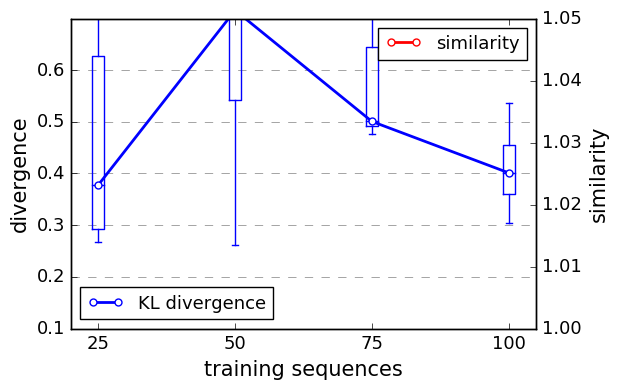

In [27]:
a,b=result
import oneclasscurve  as occ
occ.plot('123',sizes,a,b)

In [ ]:
 a=eval('[1,2]')
print a

In [ ]:
import numpy as np
a=np.array([[ 0.09634476 , 0.90365524],
 [ 0.06088005,  0.93911995],
 [ 0.07065094 , 0.92934906],
 [ 0.04671271,  0.95328729],
 [ 0.02970209 , 0.97029791],
 [ 0.29515478 , 0.70484522],
 [ 0.86338974 , 0.13661026],
 [ 0.80168559 , 0.19831441],
 [ 0.80968646 , 0.19031354],
 [ 0.12463197  ,0.87536803],
 [ 0.1517372   ,0.8482628 ],
 [ 0.34249768,  0.65750232],
 [ 0.07255634,  0.92744366],
 [ 0.02922214,  0.97077786],
 [ 0.77822639,  0.22177361],
 [ 0.81886221,  0.18113779],
 [ 0.16694517,  0.83305483],
 [ 0.12744298,  0.87255702],
 [ 0.09078483,  0.90921517],
 [ 0.04598973,  0.95401027],
 [ 0.80762083 , 0.19237917],
 [ 0.03582149 , 0.96417851],
 [ 0.82493818  ,0.17506182],
 [ 0.07749642 , 0.92250358],
 [ 0.52502072 , 0.47497928],
 [ 0.20059041 , 0.79940959],
 [ 0.54677554  ,0.45322446],
 [ 0.75185612  ,0.24814388],
 [ 0.72276445 , 0.27723555],
 [ 0.78464842 , 0.21535158],
 [ 0.41365199 , 0.58634801],
 [ 0.09839525 , 0.90160475],
 [ 0.03955736  ,0.96044264],
 [ 0.39204652  ,0.60795348],
 [ 0.58669915  ,0.41330085],
 [ 0.09951188  ,0.90048812],
 [ 0.69697943  ,0.30302057],
 [ 0.7775214   ,0.2224786 ]])

print a[:,0]
